# Analysing Song Exploder Transcripts

In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from empath import Empath
from scipy import stats
from IPython.display import Markdown, display

In [2]:
def printmd(string):
    display(Markdown(string))

## Load All Datasets
If the below function does not work, check your "output" folder to make sure all files are present. The code should load 65 files into the dataframe.

In [3]:
files = glob.glob('song_exploder_transcripts/txts/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 63 files and loaded 2297 rows into the dataframe.


## Empath Analysis

### Manage Categories in Empath
Some functions for keeping track of original categories present in Empath and new ones that you create.

In [4]:
def check_for_custom_caetgories():
    current_lexicon = Empath()
    empath_original_categories_list = [
         'achievement', 'affection', 'aggression', 'air_travel', 'alcohol', 'ancient', 'anger',
         'animal', 'anonymity', 'anticipation', 'appearance', 'art', 'attractive', 'banking',
         'beach', 'beauty', 'blue_collar_job', 'body', 'breaking', 'business', 'car',
         'celebration', 'cheerfulness', 'childish', 'children', 'cleaning', 'clothing', 'cold',
         'college', 'communication', 'competing', 'computer', 'confusion', 'contentment',
         'cooking', 'crime', 'dance', 'death', 'deception', 'disappointment', 'disgust',
         'dispute', 'divine', 'domestic_work', 'dominant_heirarchical', 'dominant_personality',
         'driving', 'eating', 'economics', 'emotional', 'envy', 'exasperation', 'exercise',
         'exotic', 'fabric', 'family', 'farming', 'fashion', 'fear', 'feminine', 'fight',
         'fire', 'friends', 'fun', 'furniture', 'gain', 'giving', 'government', 'hate',
         'healing', 'health', 'hearing', 'help', 'heroic', 'hiking', 'hipster', 'home',
         'horror', 'hygiene', 'independence', 'injury', 'internet', 'irritability',
         'journalism', 'joy', 'kill', 'law', 'leader', 'legend', 'leisure', 'liquid', 'listen',
         'love', 'lust', 'magic', 'masculine', 'medical_emergency', 'medieval', 'meeting',
         'messaging', 'military', 'money', 'monster', 'morning', 'movement', 'music',
         'musical', 'negative_emotion', 'neglect', 'negotiate', 'nervousness', 'night',
         'noise', 'occupation', 'ocean', 'office', 'optimism', 'order', 'pain', 'party',
         'payment', 'pet', 'philosophy', 'phone', 'plant', 'play', 'politeness', 'politics',
         'poor', 'positive_emotion', 'power', 'pride', 'prison', 'programming', 'rage',
         'reading', 'real_estate', 'religion', 'restaurant', 'ridicule', 'royalty', 'rural',
         'sadness', 'sailing', 'school', 'science', 'sexual', 'shame', 'shape_and_size',
         'ship', 'shopping', 'sleep', 'smell', 'social_media', 'sound', 'speaking', 'sports',
         'stealing', 'strength', 'suffering', 'superhero', 'surprise', 'swearing_terms',
         'swimming', 'sympathy', 'technology', 'terrorism', 'timidity', 'tool', 'torment',
         'tourism', 'toy', 'traveling', 'trust', 'ugliness', 'urban', 'vacation', 'valuable',
         'vehicle', 'violence', 'war', 'warmth', 'water', 'weakness', 'wealthy', 'weapon',
         'weather', 'wedding', 'white_collar_job', 'work', 'worship', 'writing', 'youth', 'zest'
    ]
    empath_original_set = set(empath_original_categories_list)
    empath_current_set = set(lexicon.cats.keys())
    new_categories = empath_current_set.difference(empath_original_set)
    return new_categories
    

def delete_custom_categories():
    cats_to_delete = check_for_custom_caetgories()
    empath_lexicon = Empath()
    for cat in list(cats_to_delete) :
        empath_lexicon.delete_category(cat)
    print("Categories Deleted: ")
    print(cats_to_delete)
        

## Create your own Empath Category
Make sure the category name is an English word, it can help. Read the original paper for details on how.

In [5]:
lexicon = Empath()
lexicon.create_category('reflection', ['believe', 'realise', 'realize', 'retrospect', 'introspect', 'know'], size=100)

["realize", "realise", "believe", "understand", "Because", "mean", "knowing", "though", "thought", "care", "honestly", "actually", "remember", "knew", "wonder", "admit", "guess", "anymore", "Honestly", "matter", "thinking", "suppose", "trust", "probably", "blame", "assume", "Maybe", "explain", "Obviously", "realized", "seem", "wish", "imagine", "though", "right", "deny", "notice", "doubt", "knows", "anything", "anyway", "realizing", "exactly", "forget", "either", "expect", "seriously", "figured", "pretend", "why", "Actually", "truly", "idea", "seeing", "realised", "Even", "If", "meant", "realise", "bet", "regret", "suspect", "yet", "sure", "happen", "slightest_clue", "understood", "Knowing", "accept", "question", "funny_thing"]


In [6]:
check_for_custom_caetgories()

{'reflection'}

In [7]:
# delete_custom_categories()

## Get Words from New Category
We will not be using Empath's default matching functions, so that we can do a bit more that what Empath functions allow (identify matching words, create plots, etc.). So we create our own regular expression matching which can definitely be improved upon (see if you want to work on this!)

In [8]:
reflection_words = lexicon.cats['reflection']
reflection_words = [w.lower() for w in reflection_words]
reflection_words = sorted(list(set(reflection_words)))
reflection_words = [w.replace("_", " ") for w in reflection_words]

In [9]:
def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence.lower())))
    return num_matches

def count_words(sentence):
    words = sentence.split()
    return len(words)

## Add the number of matches to the dataframe
We use total matches here, but we also keep a count of words so that we can normalize later if needed.

In [10]:
df[0:10]

dataset session     speaker  \
0  song_exploder_transcripts    haim  Hrishikesh   
1  song_exploder_transcripts    haim  Hrishikesh   
2  song_exploder_transcripts    haim    Danielle   
3  song_exploder_transcripts    haim       Ariel   
4  song_exploder_transcripts    haim    Danielle   
5  song_exploder_transcripts    haim       Ariel   
6  song_exploder_transcripts    haim    Danielle   
7  song_exploder_transcripts    haim       Ariel   
8  song_exploder_transcripts    haim       Ariel   
9  song_exploder_transcripts    haim    Danielle   

                                         speech_turn  
0  You’re listening to Song Exploder, where music...  
1  This episode contains explicit language. HAIM ...  
2                          My name is Danielle Haim.  
3     My name is Ariel Rechtshaid. (Music fades out)  
4  I’ll never forget, I had heard a Cass McCombs ...  
5  We had a chemistry and did a few songs, and at...  
6  I think we were just trying to get through, so...  
7  I don't know if there are words for how suppor...  
8                                        (Synth pad)  
9  I think it was the summer of 2018 and we had j...

In [11]:
def add_measure(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    empath_measures = []
    word_counts = []
    for ind, speech_turn in enumerate(list(df['speech_turn'])) :
        if speech_turn != '' and speech_turn != ' ' :
            empath_measure = count_lexicon_terms(speech_turn, lex_category_list)
            num_words = count_words(speech_turn)
            word_counts.append(num_words)
            if normalize_measure :
                empath_measures.append(empath_measure/num_words)
            else :
                empath_measures.append(empath_measure)
    df.insert(column_index, lex_category_name, empath_measures, True)
    if not 'word count' in df.columns :
        df.insert(column_index+1, 'word count', word_counts, True)
    return df


In [12]:
df = add_measure(df, 'reflection', reflection_words, normalize_measure=False)
df[0:10]

dataset session     speaker  \
0  song_exploder_transcripts    haim  Hrishikesh   
1  song_exploder_transcripts    haim  Hrishikesh   
2  song_exploder_transcripts    haim    Danielle   
3  song_exploder_transcripts    haim       Ariel   
4  song_exploder_transcripts    haim    Danielle   
5  song_exploder_transcripts    haim       Ariel   
6  song_exploder_transcripts    haim    Danielle   
7  song_exploder_transcripts    haim       Ariel   
8  song_exploder_transcripts    haim       Ariel   
9  song_exploder_transcripts    haim    Danielle   

                                         speech_turn  reflection  word count  
0  You’re listening to Song Exploder, where music...           0          32  
1  This episode contains explicit language. HAIM ...           1         109  
2                          My name is Danielle Haim.           0           5  
3     My name is Ariel Rechtshaid. (Music fades out)           0           8  
4  I’ll never forget, I had heard a Cass McCombs ...           3         102  
5  We had a chemistry and did a few songs, and at...           3         201  
6  I think we were just trying to get through, so...           0          17  
7  I don't know if there are words for how suppor...           4          99  
8                                        (Synth pad)           0           2  
9  I think it was the summer of 2018 and we had j...           0          44

## Plot Occurrences
A number of plotting functions to plot occurrences by dataset, by session, by speaker, and on a timeline. 

In [13]:
def plot_cats_by_dataset(df, category, normalize=False):
    dataset_df = df
    dataset_category_df = df[df[category] > 0]
    datasets = sorted(list(set(df['dataset'])))
    num_datasets = len(datasets)
    fig = plt.figure(figsize=[num_datasets,4], dpi=300)
    if normalize == False :
        p=sns.countplot(data=dataset_df, x='dataset', color='#eee', order=datasets)
        p=sns.countplot(data=dataset_category_df, x='dataset', color='#777', order=datasets)
        p.set_title('proportion of ' + category + ' turns')
    else :
        total_turns_list = []
        category_turns_list = []
        for dataset in datasets :
            total_turns = df[df['dataset'] == dataset].shape[0]
            category_turns = dataset_category_df[dataset_category_df['dataset'] == dataset].shape[0]
            total_turns_normalized = 100
            category_turns_normalized = category_turns/total_turns * 100
            total_turns_list.append(total_turns_normalized)
            category_turns_list.append(category_turns_normalized)
        p=sns.barplot(x=datasets, y=total_turns_list, orient='v', color='#eee')
        p=sns.barplot(x = datasets, y=category_turns_list, orient='v', color='#777')
        p.set_title('proportion of ' + category + ' turns')
        
    plt.savefig('plots/empath'+category+'-turns-count.pdf', bbox_inches='tight')
    plt.show()


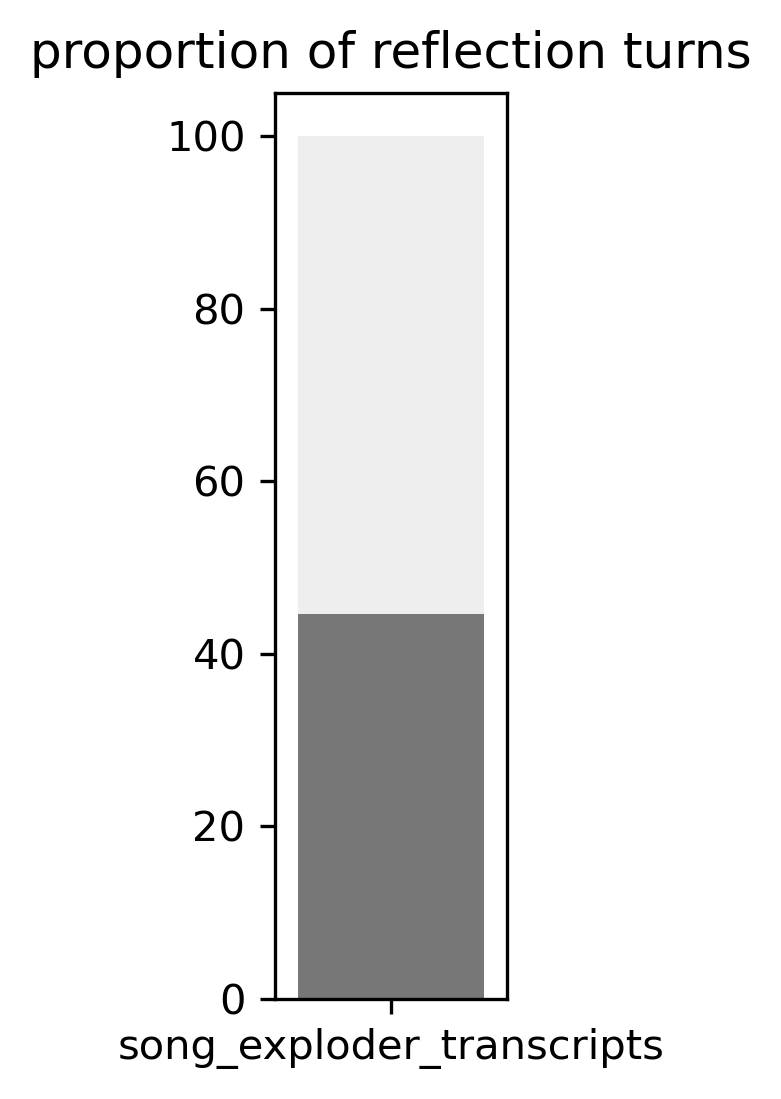

In [14]:
plot_cats_by_dataset(df, 'reflection', normalize=True)


In [15]:
def plot_cats_by_session(df, dataset_name, category, color='default', normalize=False):
    dataset_df = df[df['dataset'] == dataset_name]
    dataset_category_df = dataset_df[dataset_df[category] > 0]
    sessions = sorted(list(set(dataset_df['session'])))
    num_sessions = len(sessions)
    fig = plt.figure(figsize=[num_sessions,4], dpi=300)
    if normalize == False :
        p=sns.countplot(data=dataset_df, x='session', color='#eee', order=sessions)
        p=sns.countplot(data=dataset_category_df, x='session', color='#777', order=sessions)
        p.set_title('proportion of ' + category + ' turns')
    else :
        total_turns_list = []
        category_turns_list = []
        for session in sessions :
            total_turns = dataset_df[dataset_df['session'] == session].shape[0]
            category_turns = dataset_category_df[dataset_category_df['session'] == session].shape[0]
            total_turns_normalized = 100
            category_turns_normalized = category_turns/total_turns * 100
            total_turns_list.append(total_turns_normalized)
            category_turns_list.append(category_turns_normalized)
        p=sns.barplot(x=sessions, y=total_turns_list, orient='v', color='#eee')
        p=sns.barplot(x = sessions, y=category_turns_list, orient='v', color='#777')
    p.set_title('proportion of ' + category + ' turns')
    p.set_xticklabels(sessions, rotation=30, ha='right')
    plt.savefig('plots/empath'+category+'-'+dataset_name+'-turns-count-by-session.pdf', bbox_inches='tight')
    plt.show()


In [16]:
set(list(df['session']))

{'100-gecs',
 'apparat',
 'arlo-parks',
 'aurora',
 'bat-for-lashes',
 'big-thief',
 'billie-eilish',
 'black-pumas',
 'bon-iver',
 'brittany-howard',
 'caribou',
 'cheap-trick',
 'clairo',
 'common',
 'deftones',
 'denzel-curry',
 'dua-lipa',
 'eric-nam',
 'fka-twigs',
 'foushee',
 'girl-in-red',
 'glass-animals',
 'haim',
 'imagine-dragons',
 'jamila-woods',
 'jay-som',
 'jewel',
 'jon-batiste',
 'kelly-lee-owens',
 'khruangbin',
 'laura-marling',
 'lianne-la-havas',
 'meek-mill',
 'mobb-deep',
 'mumford-and-sons',
 'nakhane',
 'nathaniel-rateliff',
 'panda-bear',
 'phoebe-bridgers',
 'pj-morton',
 'porter-robinson',
 'raleigh-ritchie',
 'raphael-saadiq',
 'robyn',
 'run-the-jewels',
 'sasha-sloan',
 'selena-gomez',
 'semisonic',
 'sharon-van-etten',
 'sheryl-crow',
 'sleater-kinney',
 'slipknot',
 'soccer-mommy',
 'sparks',
 'tame-impala',
 'the-1975',
 'the-cranberries',
 'the-mountain-goats',
 'vagabon',
 'vampire-weekend',
 'waxahatchee',
 'wonderly',
 'yusuf-cat-stevens'}

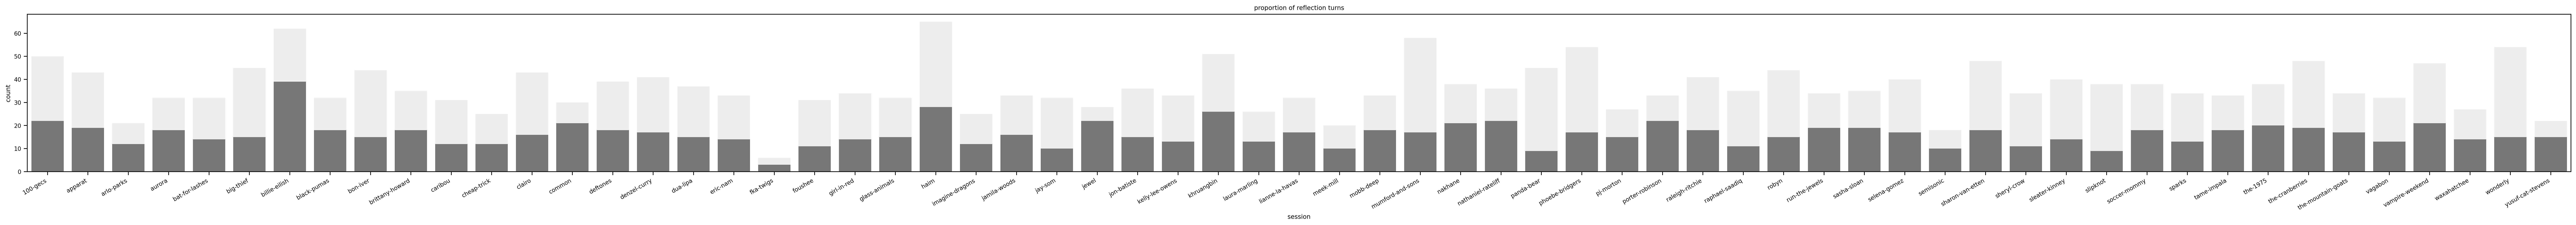

In [19]:
sns.set_context("paper", font_scale=0.9)
plot_cats_by_session(df, 'song_exploder_transcripts', 'reflection', normalize=False)


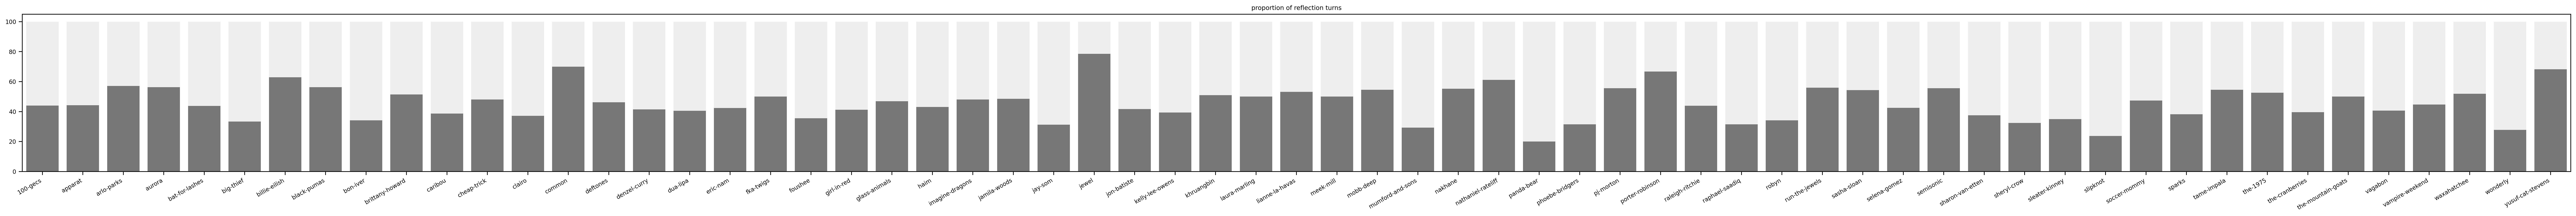

In [20]:
plot_cats_by_session(df, 'song_exploder_transcripts', 'reflection', normalize=True)


In [21]:
def plot_cats_by_speaker(df, dataset, category):
    sessions = list(set(df[df['dataset'] == dataset]['session']))
    for session in sessions :
        session_df = df[df['session'] == session]
        session_category_df = df[(df['session'] == session) & (df[category] > 0)]
        speakers = sorted(list(set(session_df['speaker'])))
        num_speakers = len(speakers)
        fig = plt.figure(figsize=[num_speakers,4], dpi=300)
        p=sns.countplot(data=session_df, x='speaker', color='#eee', order=speakers)
        p=sns.countplot(data=session_category_df, x='speaker', color='#777', order=speakers)
        p.set_title(category + ' turns count | ' + dataset + ' | ' + session)
        plt.savefig('plots/empath'+category+'-turns-count-'+ dataset +'-'+ session +'.pdf', bbox_inches='tight')
        plt.show()


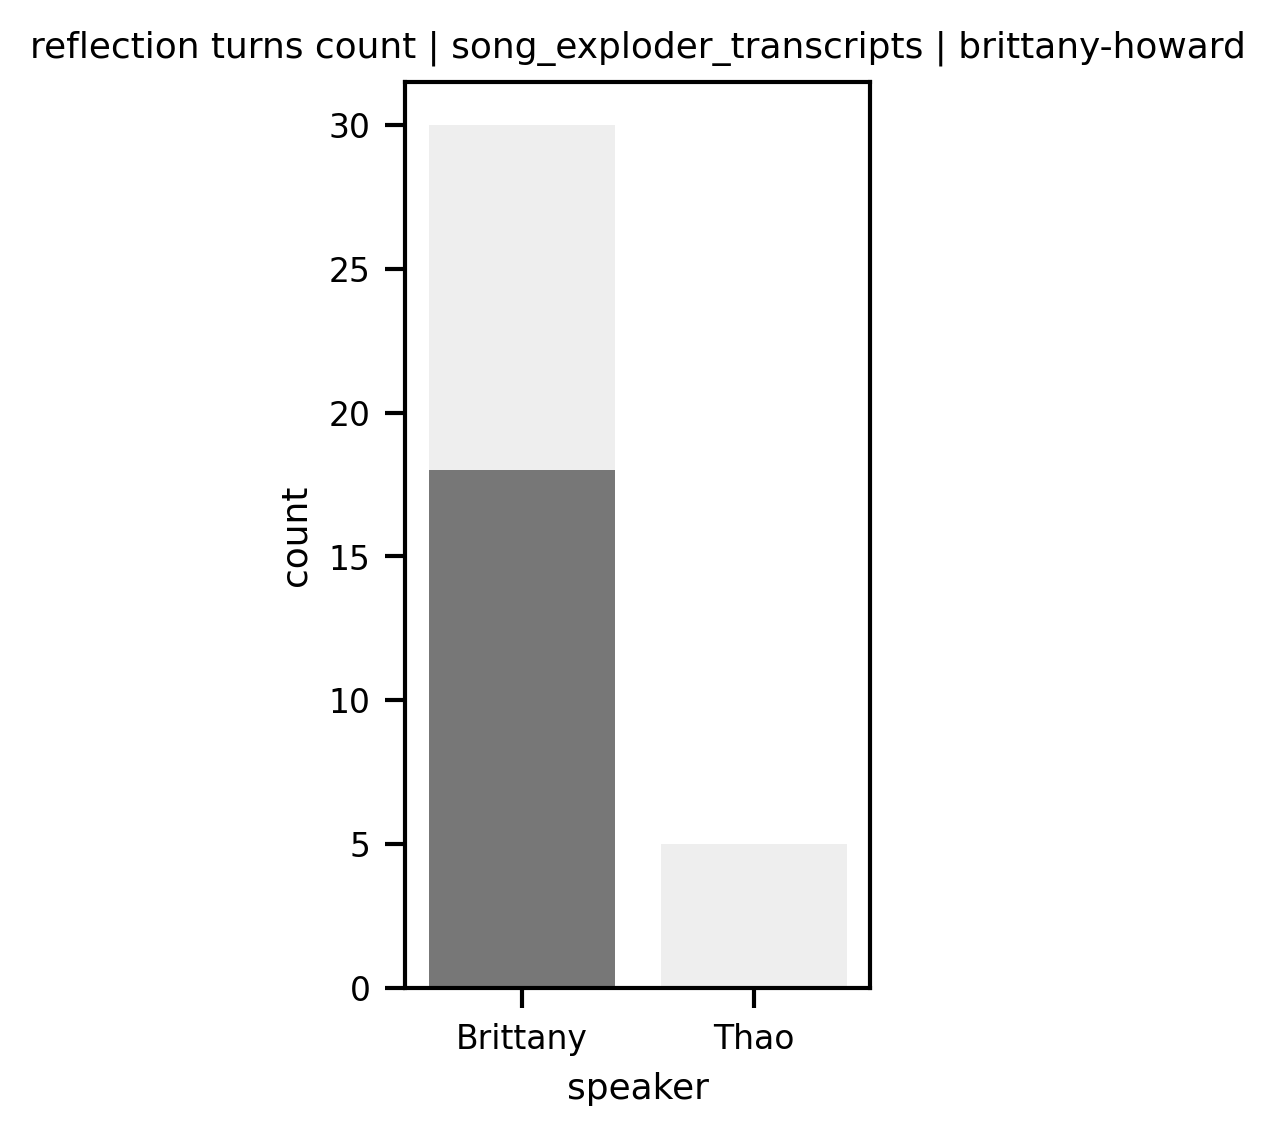

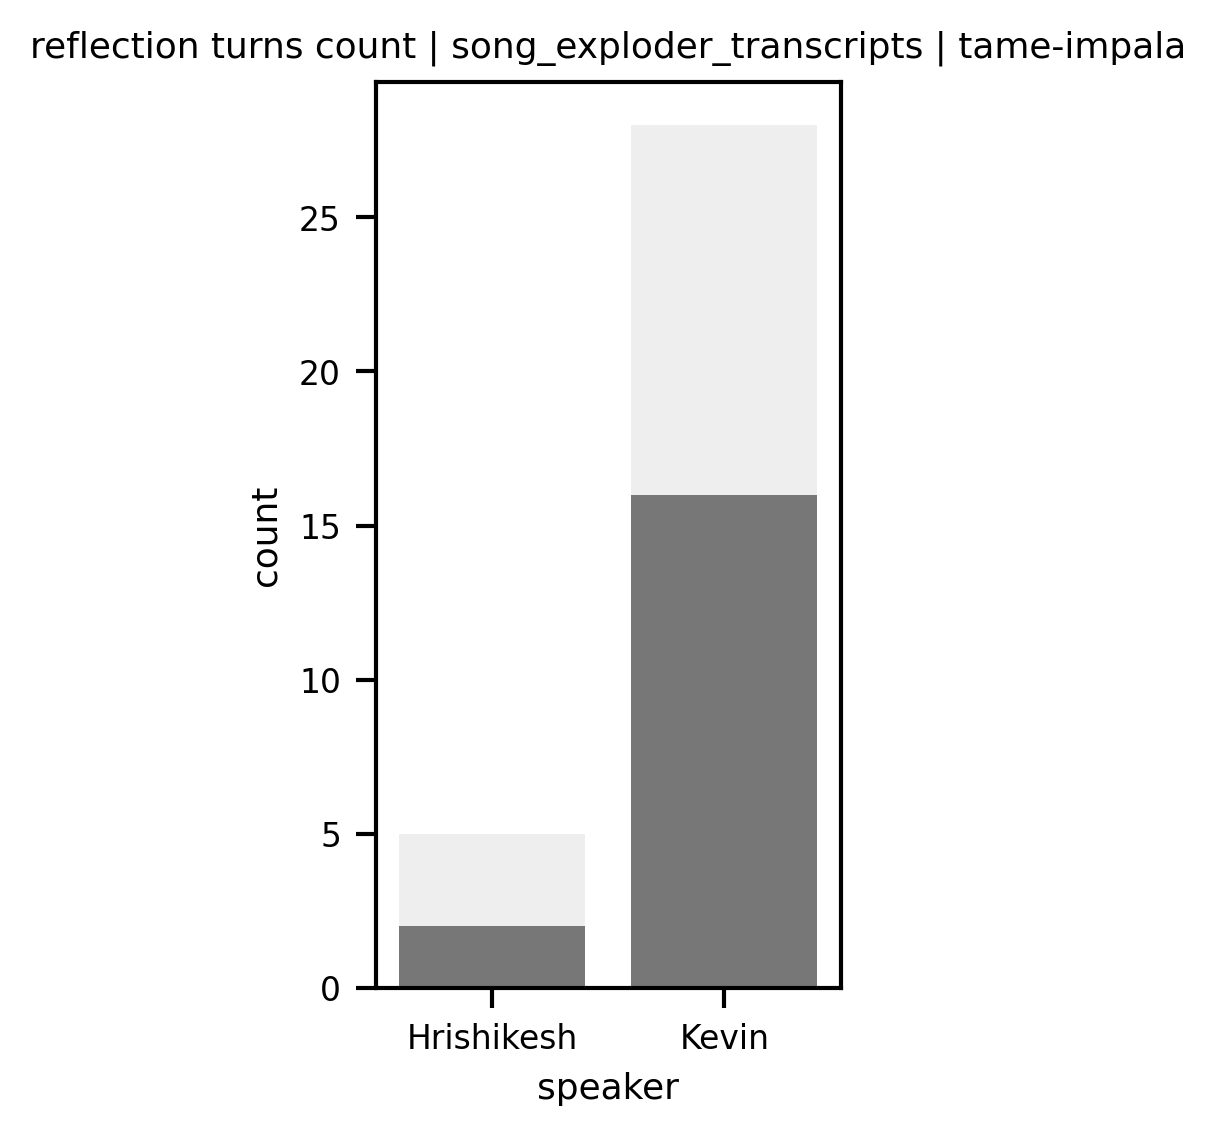

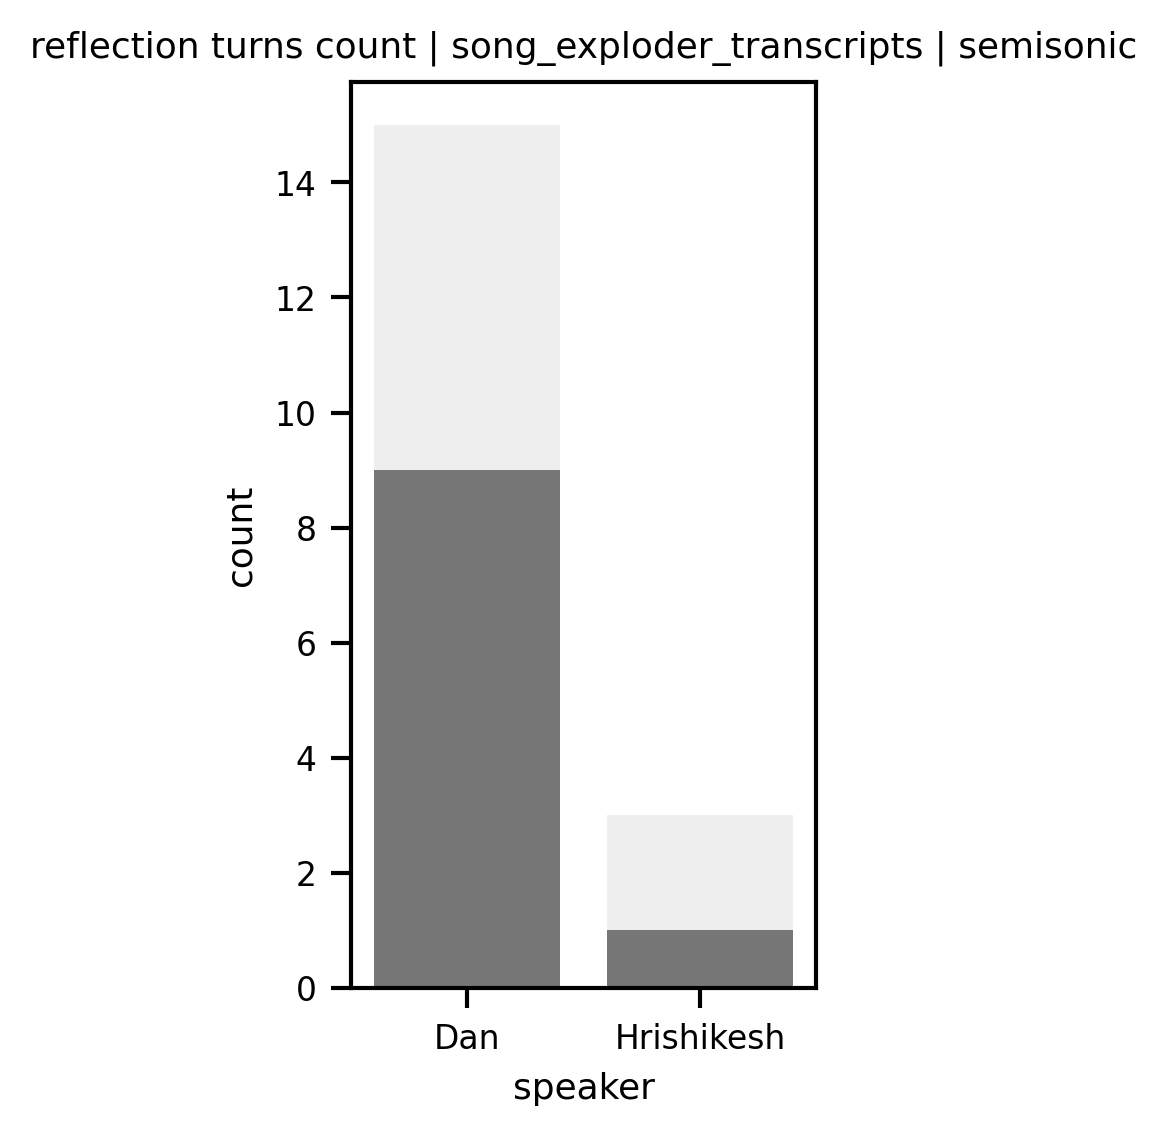

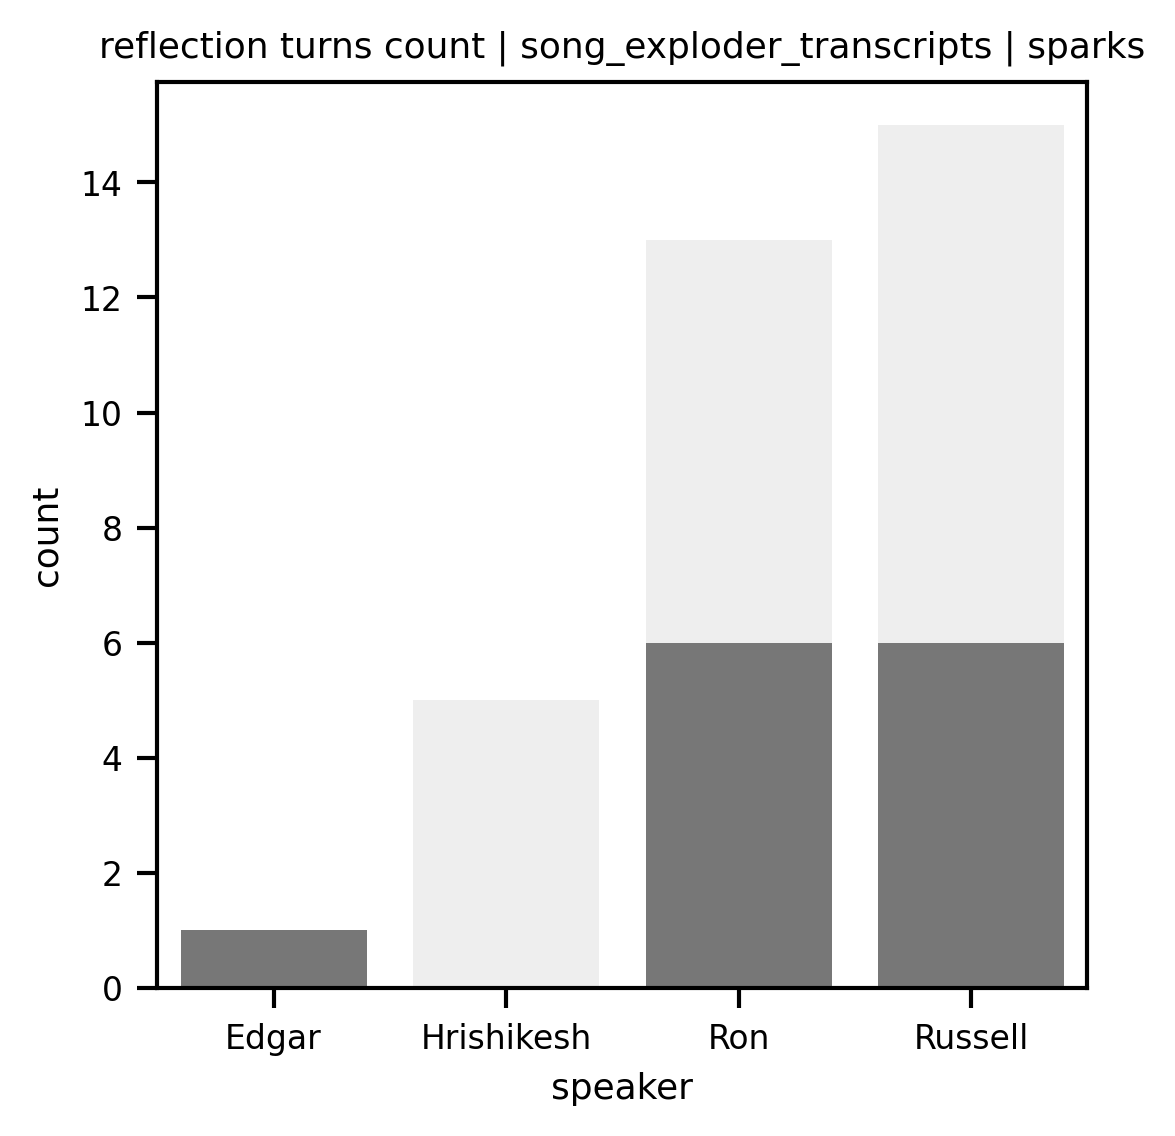

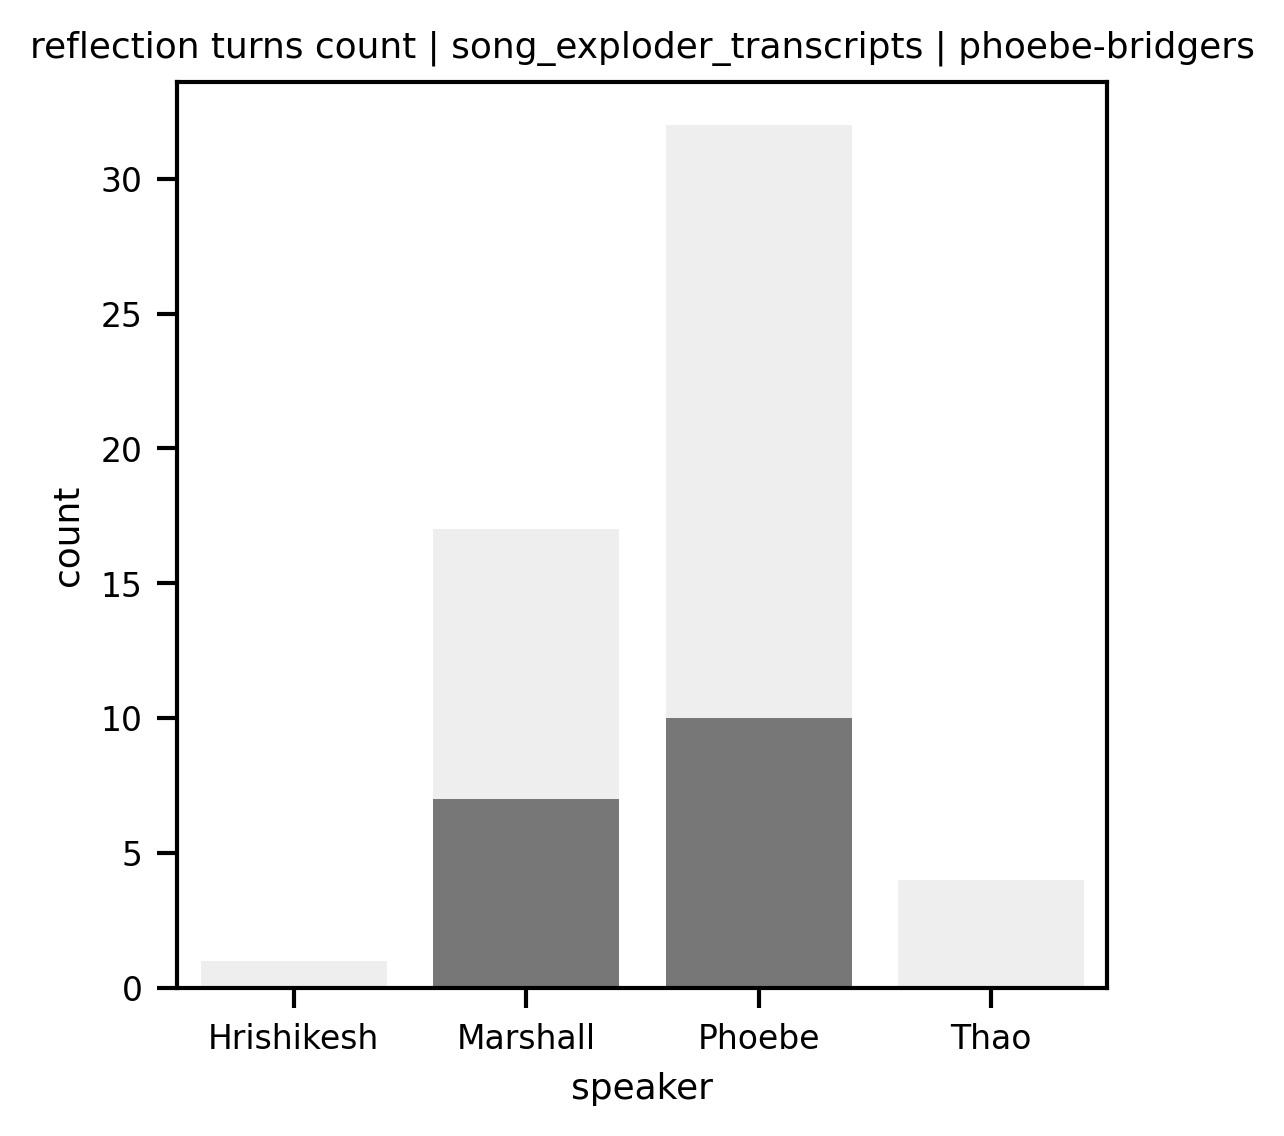

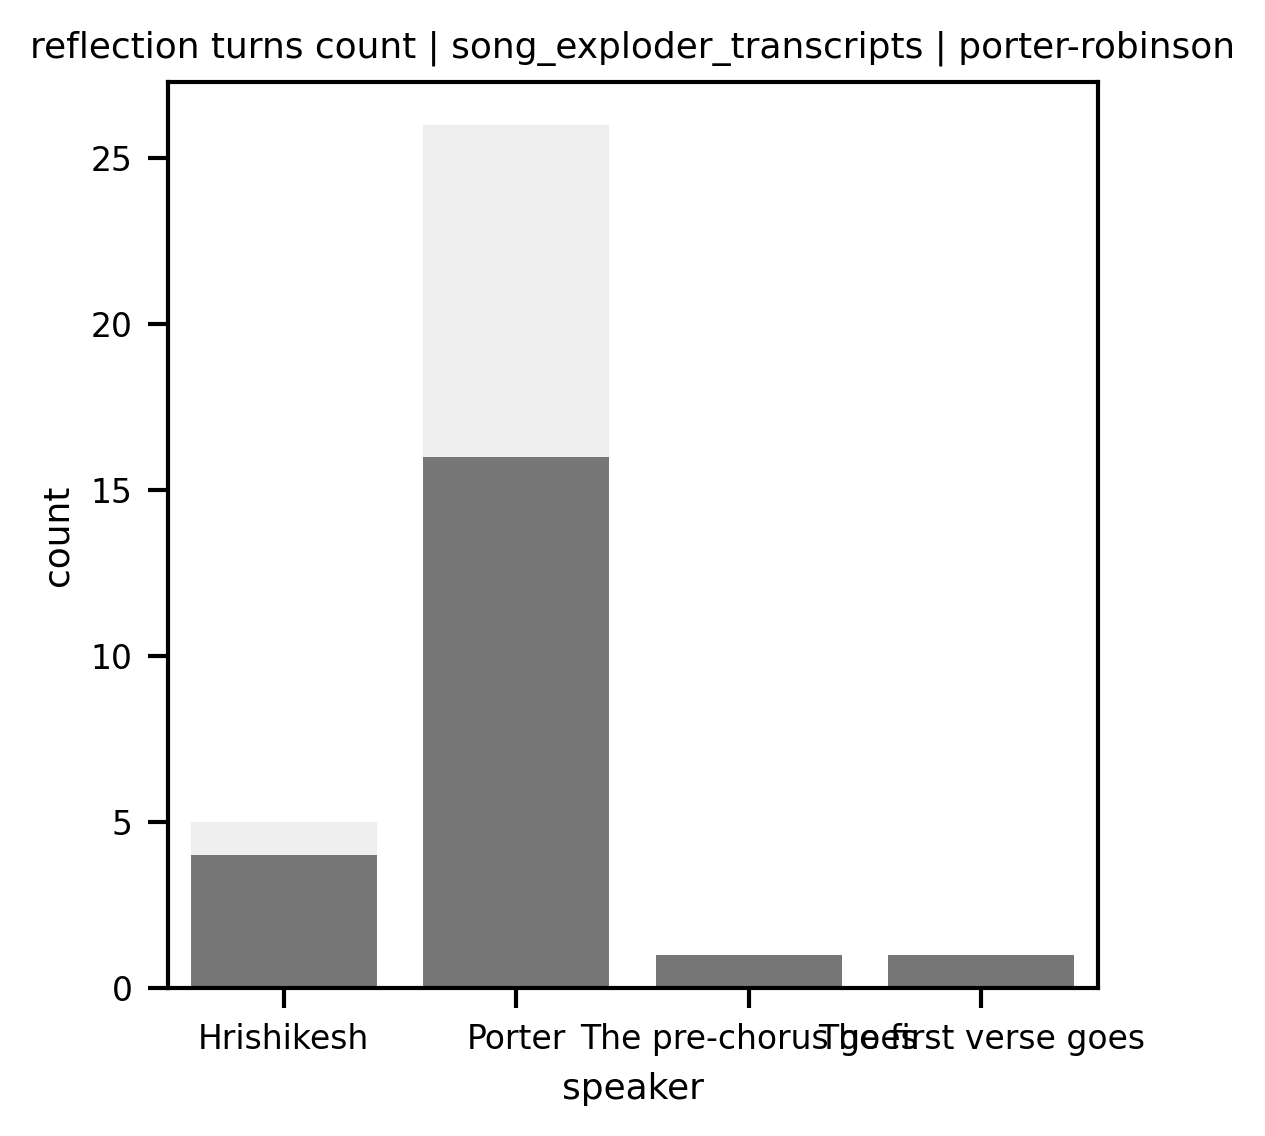

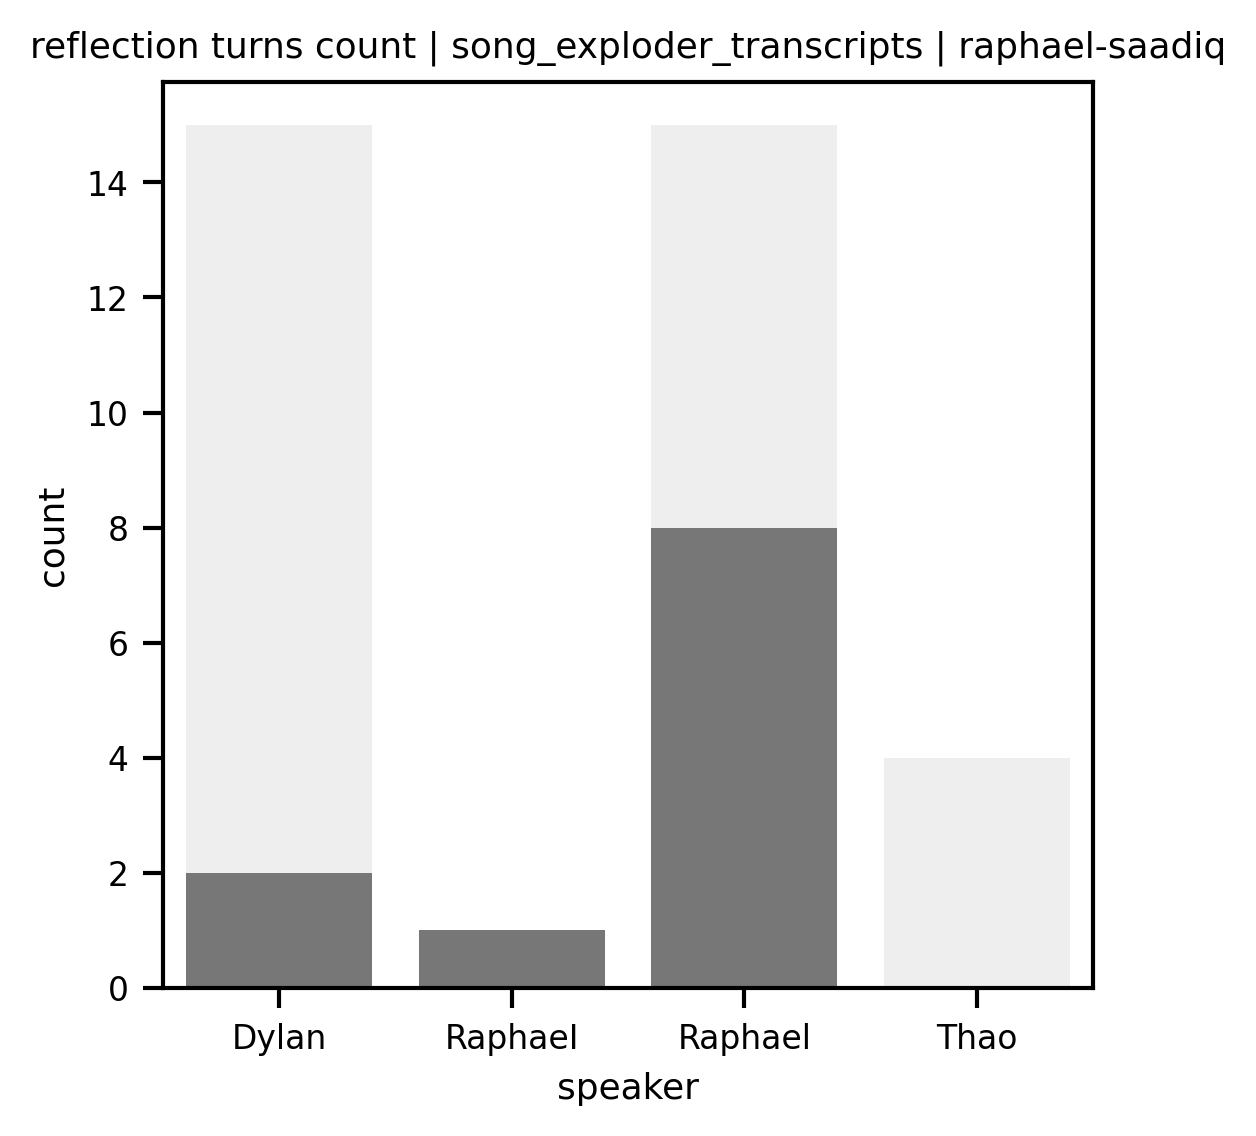

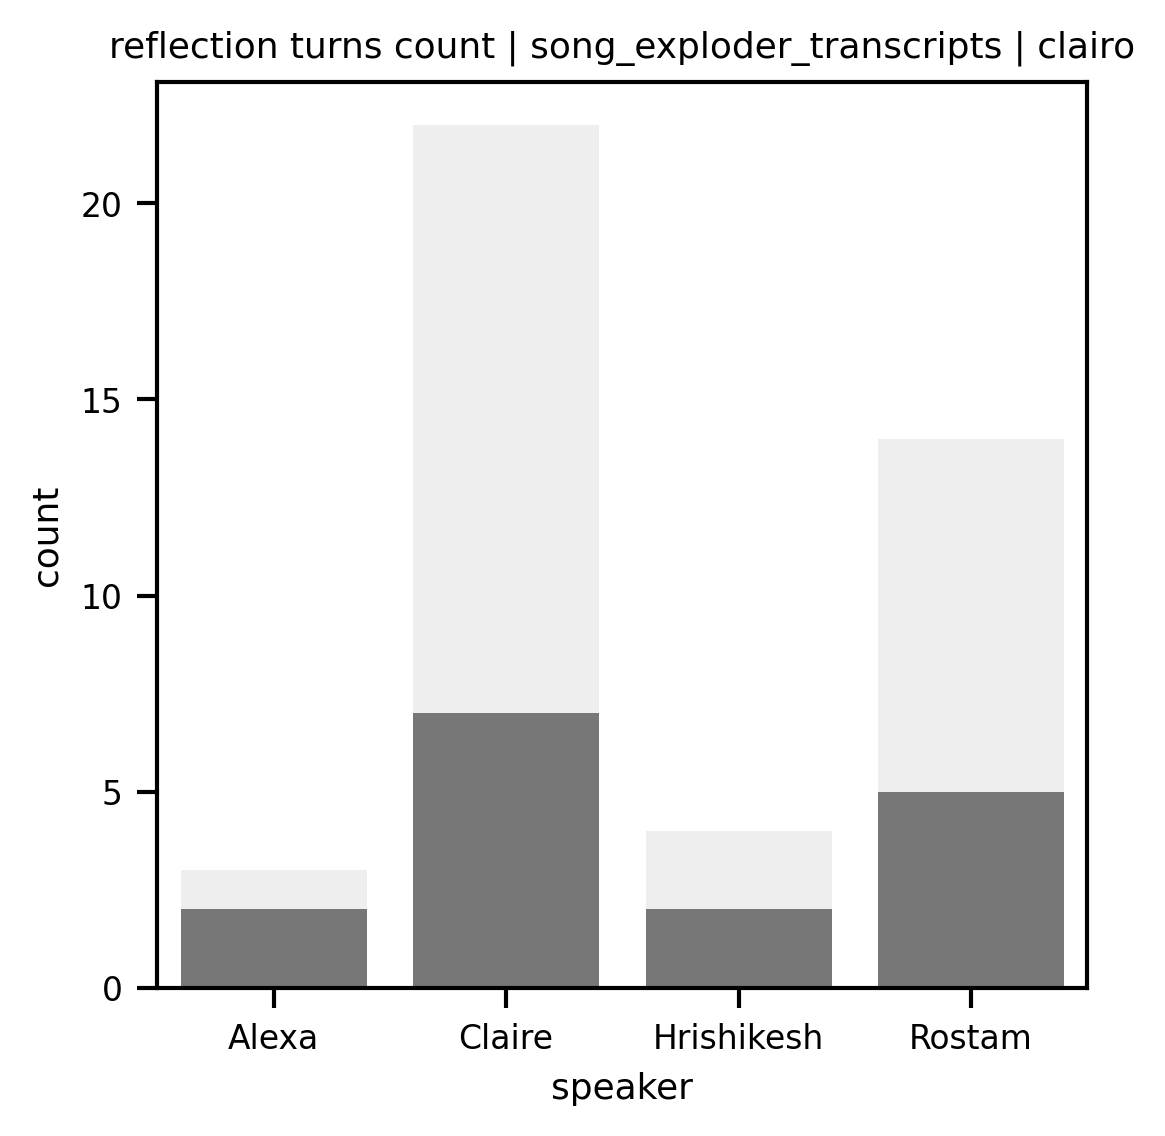

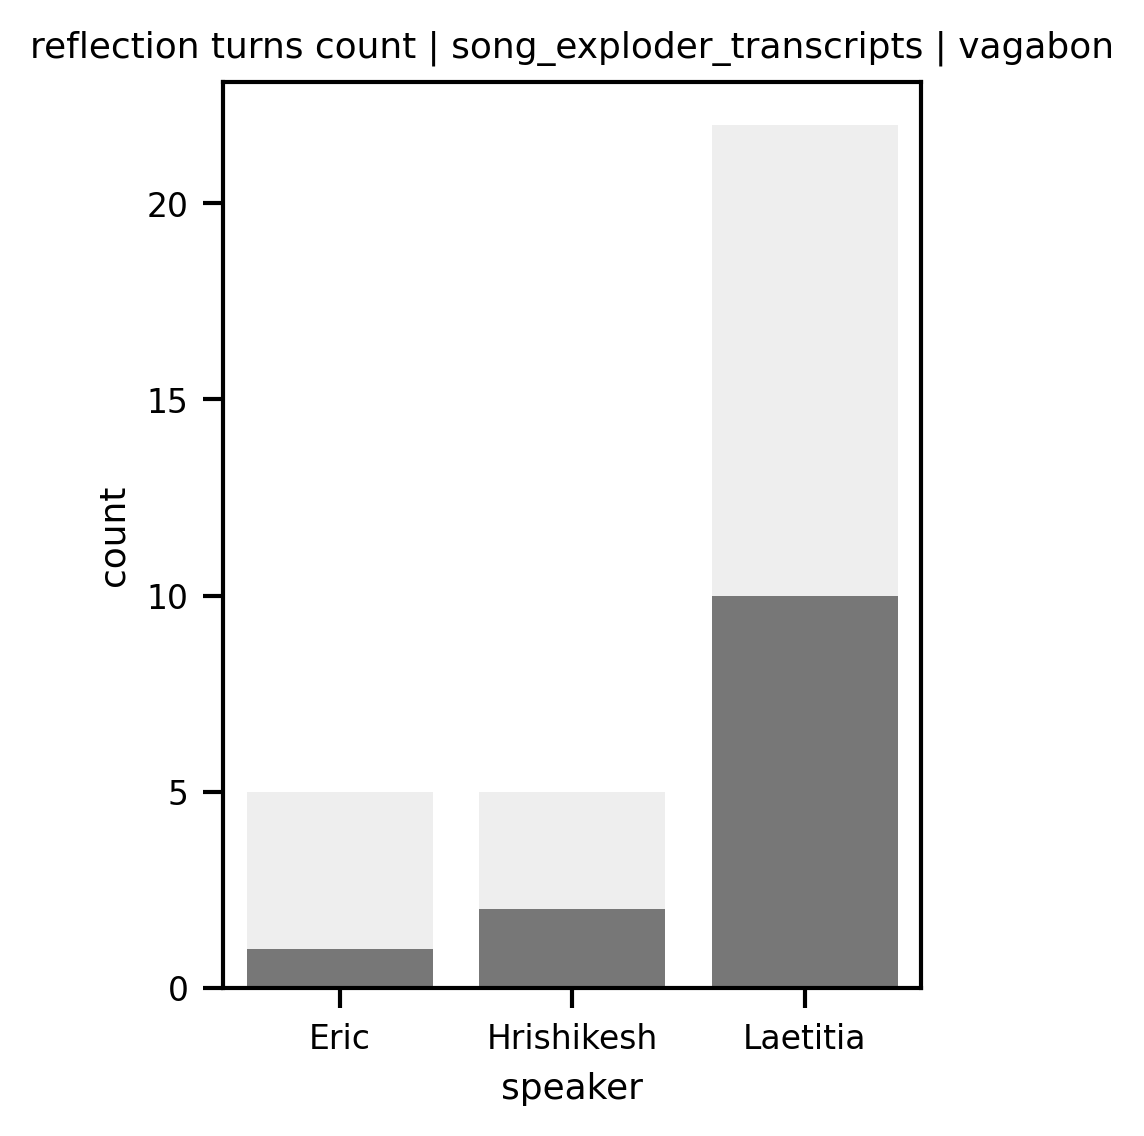

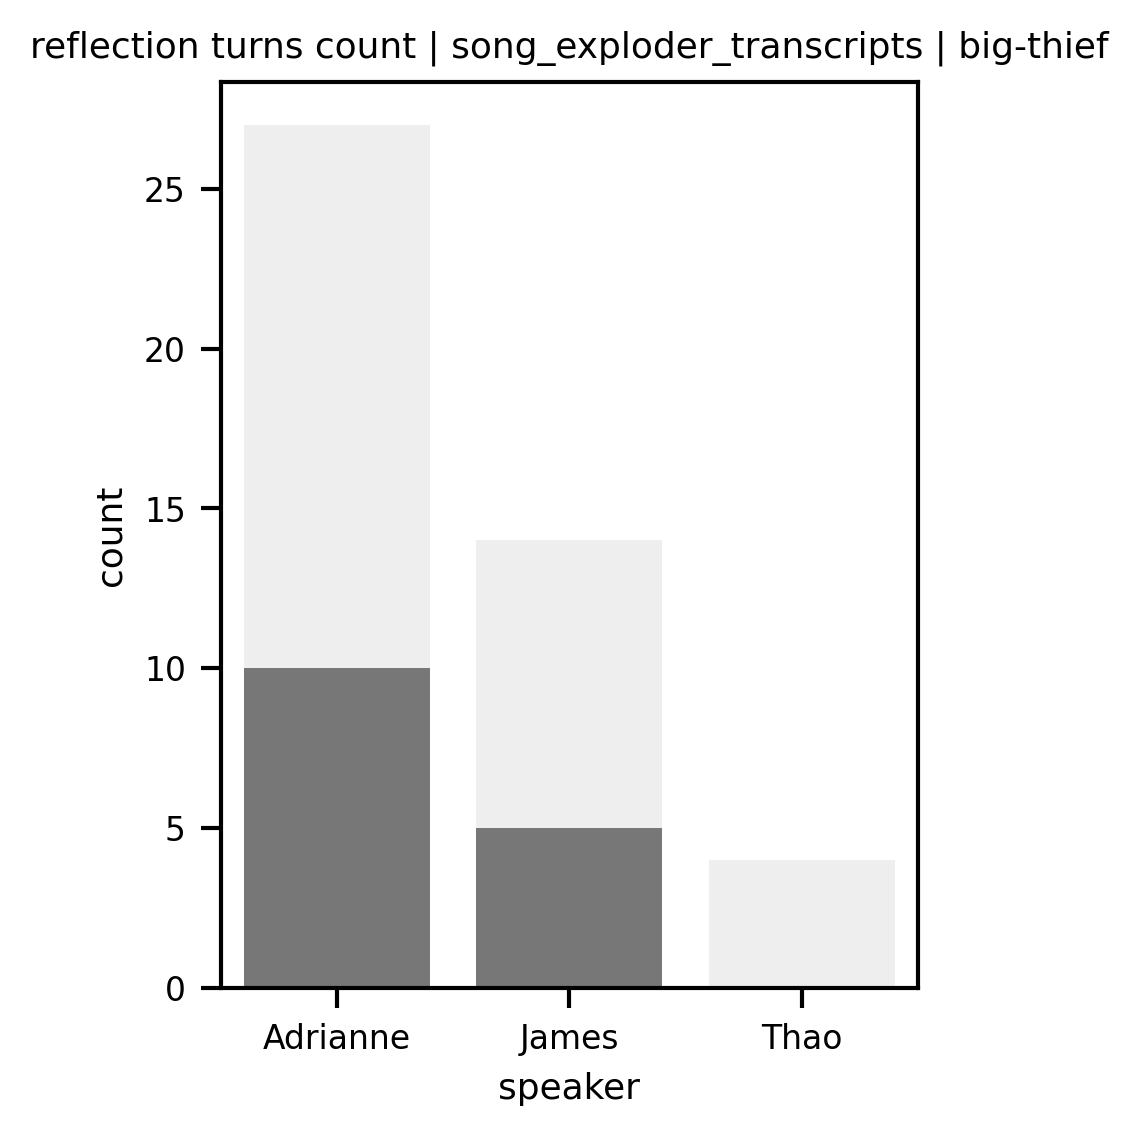

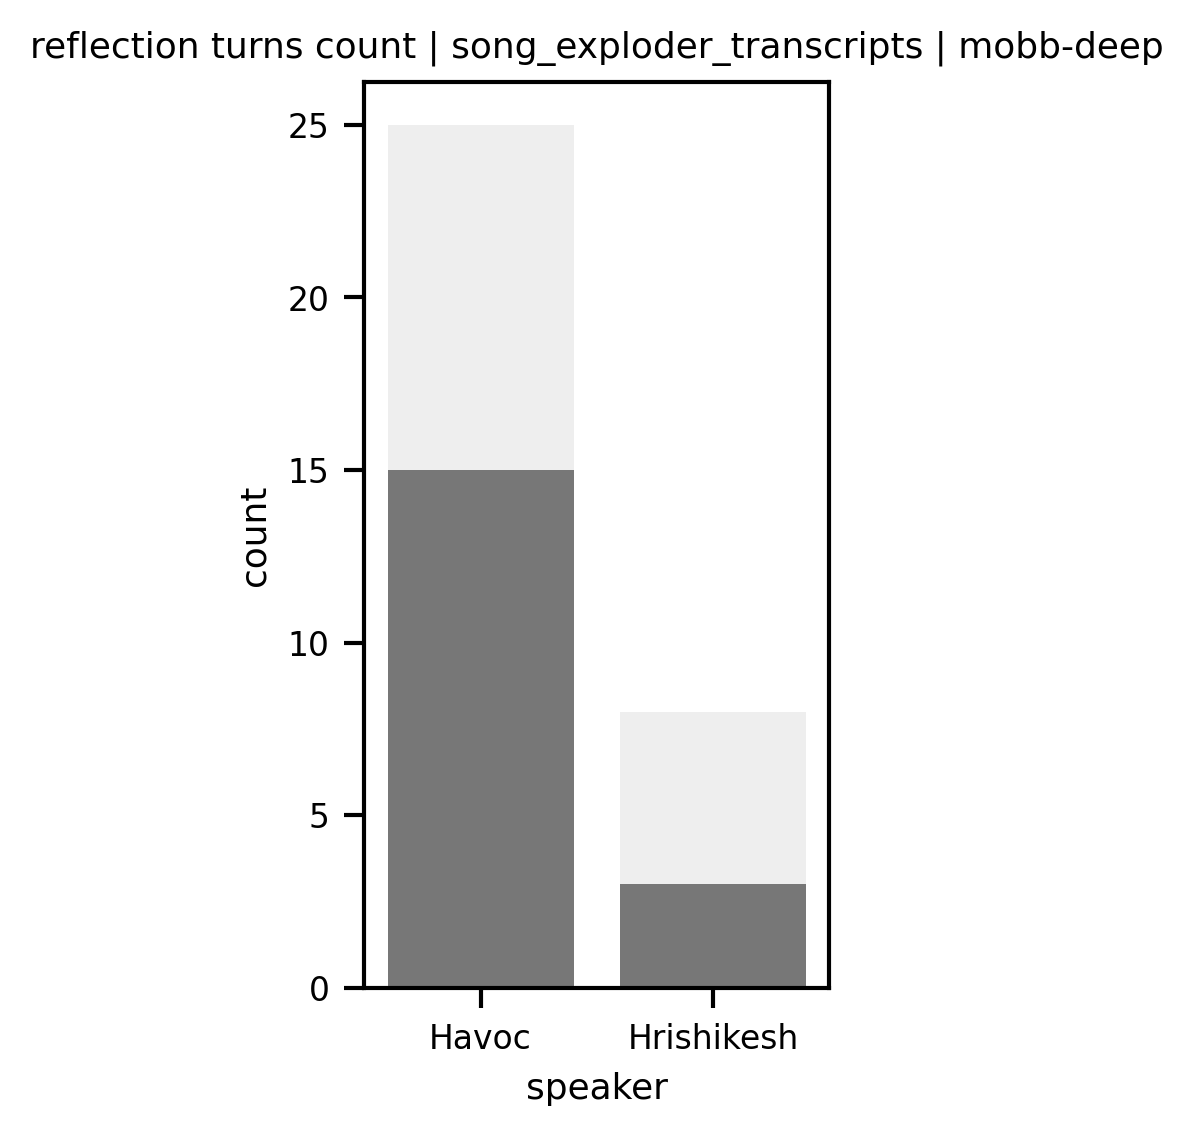

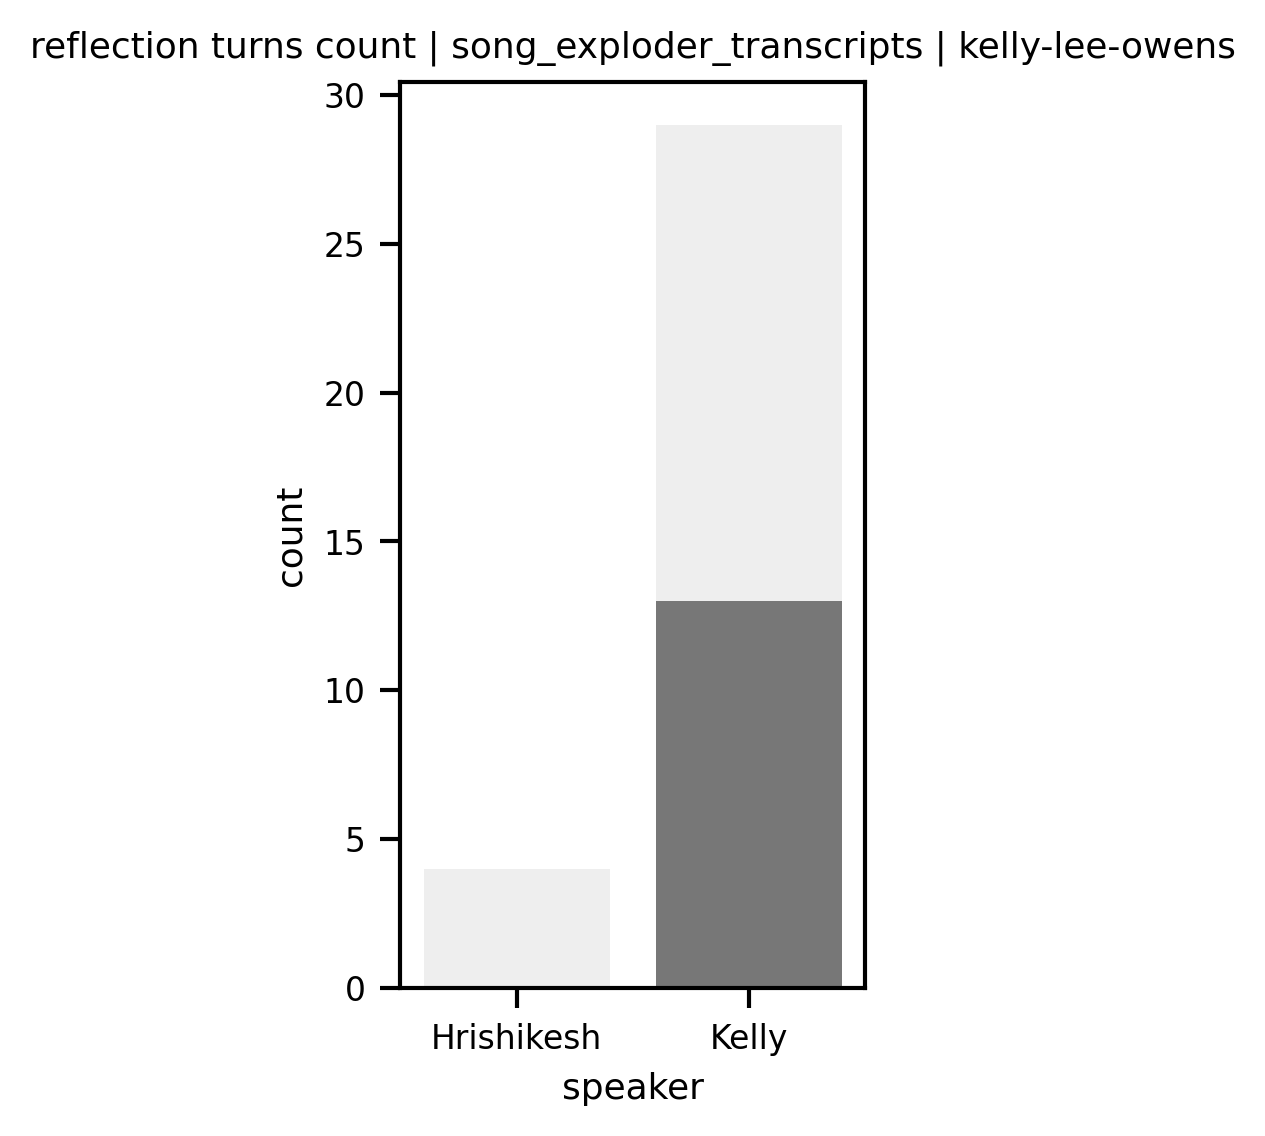

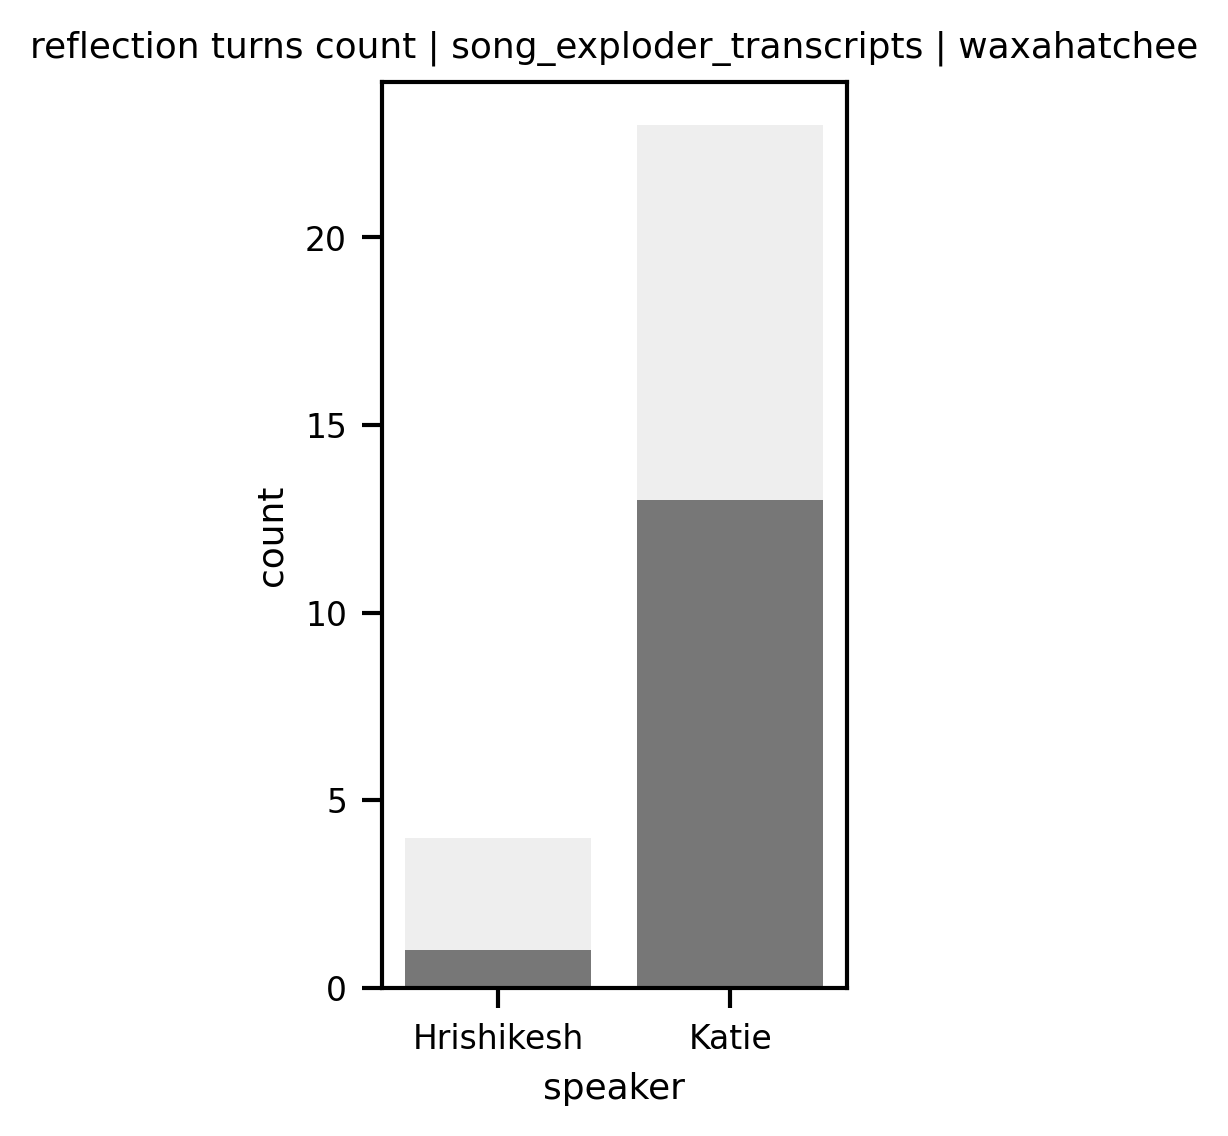

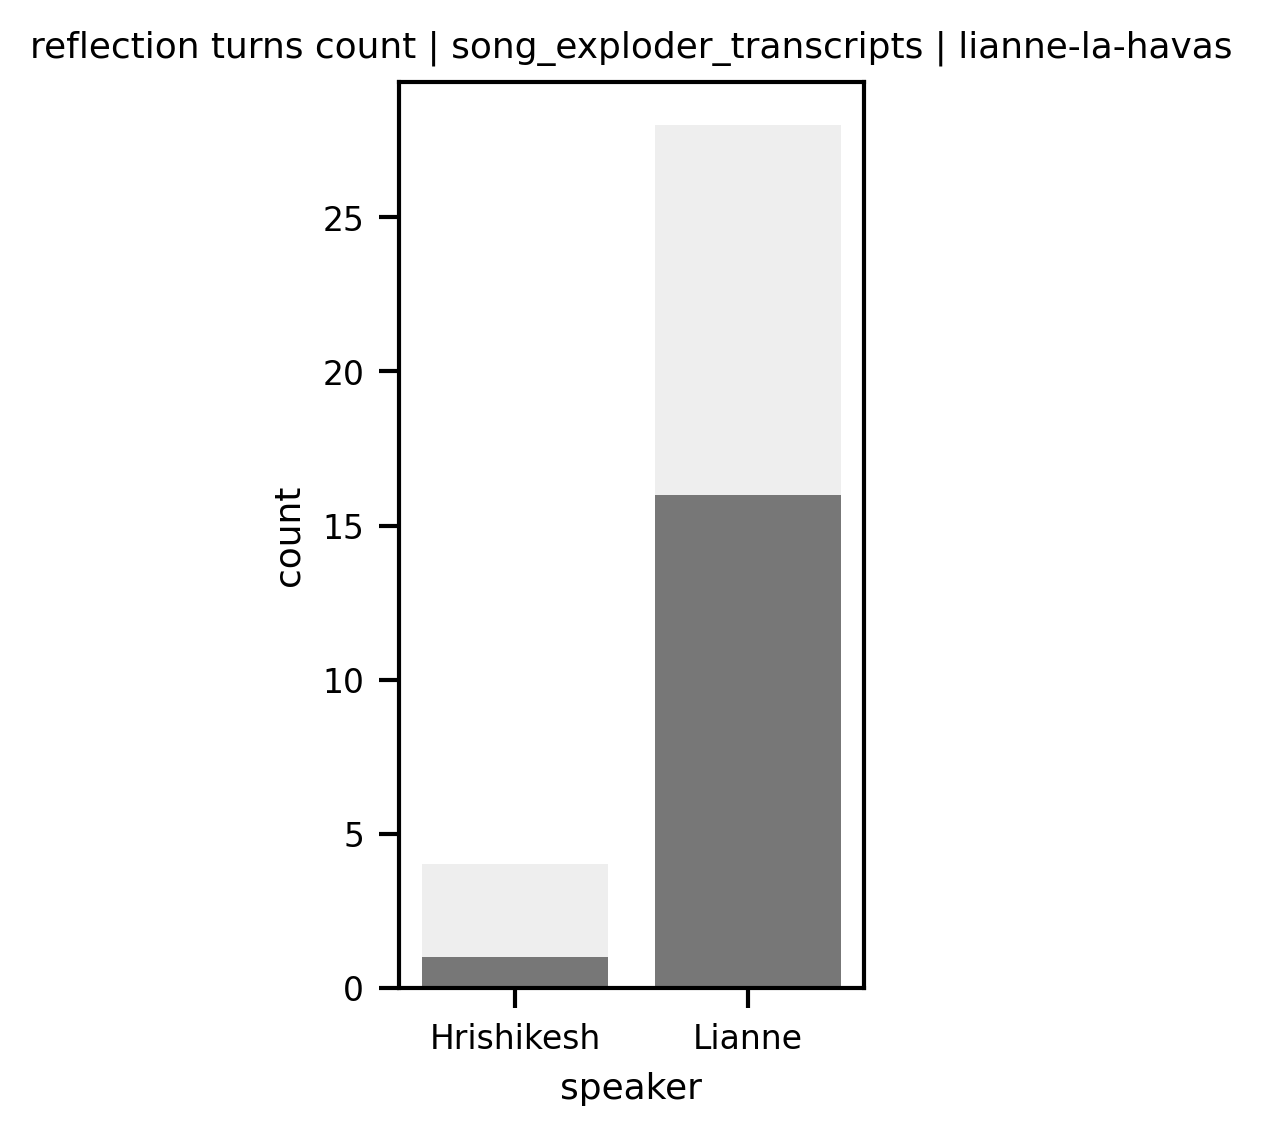

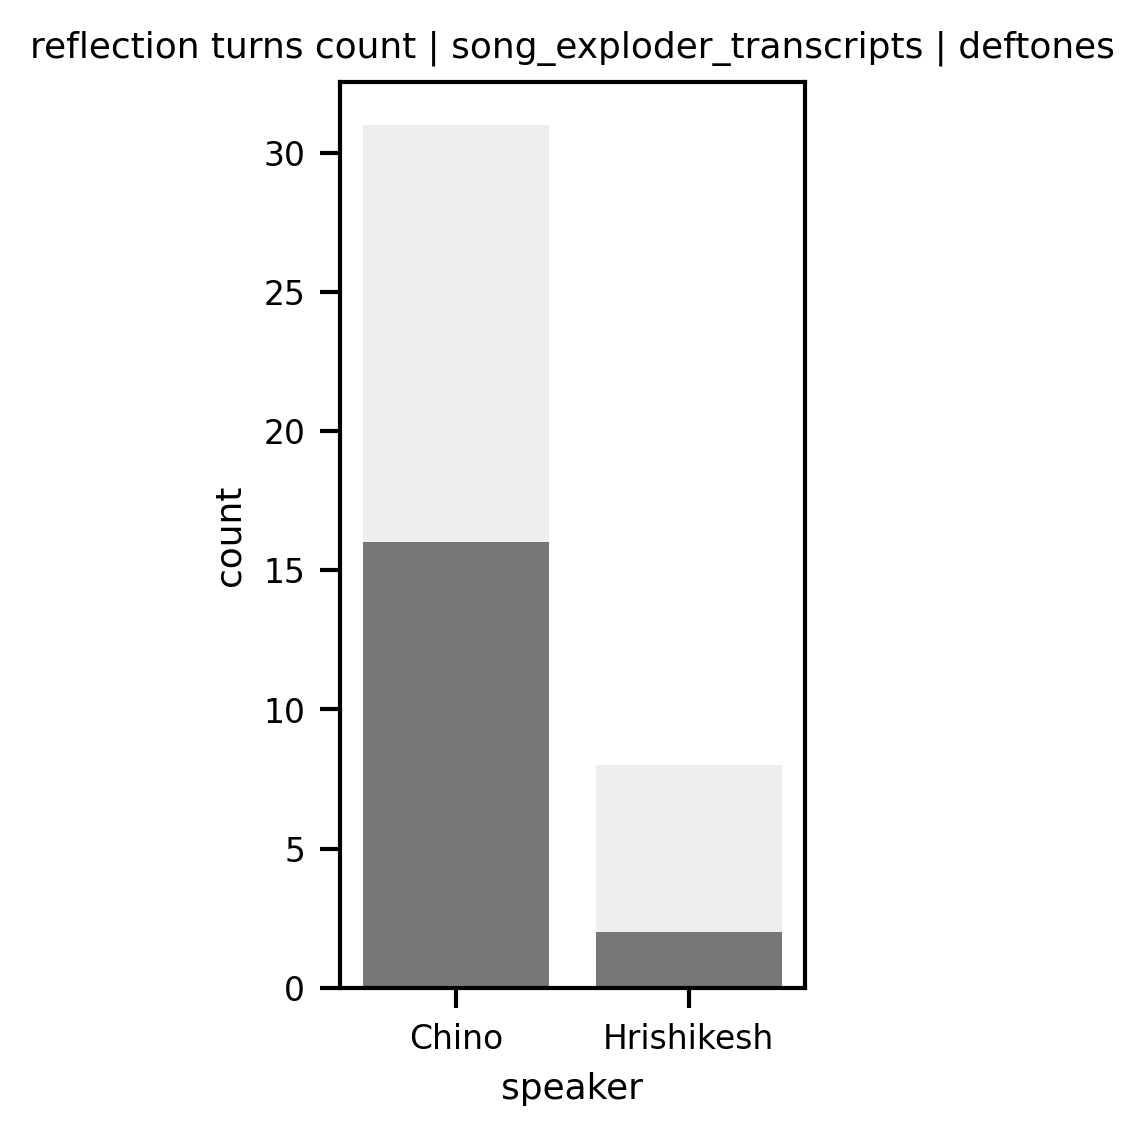

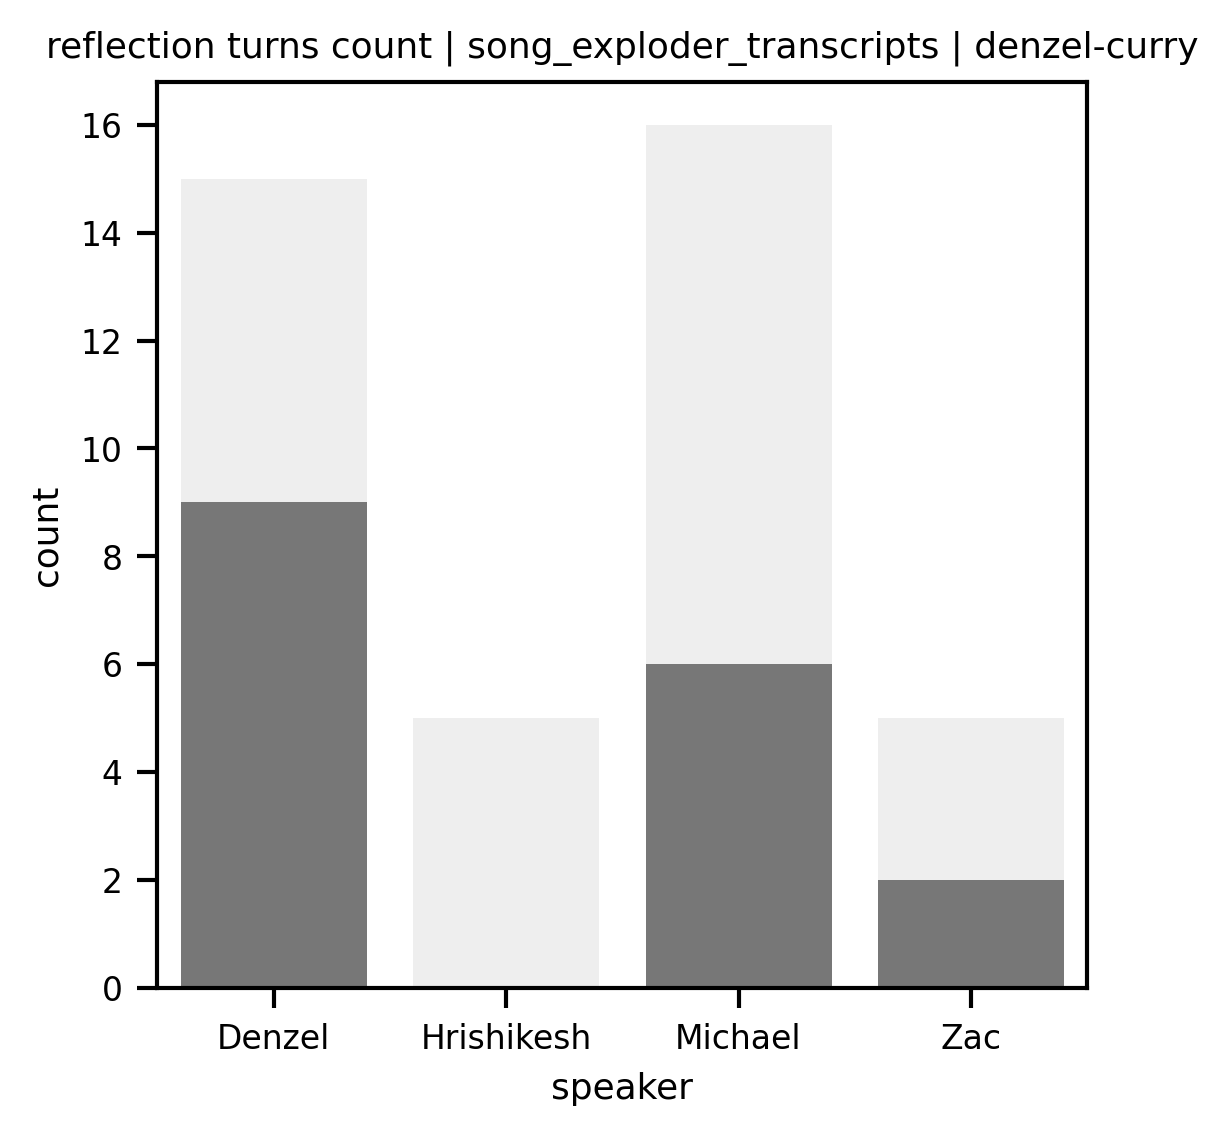

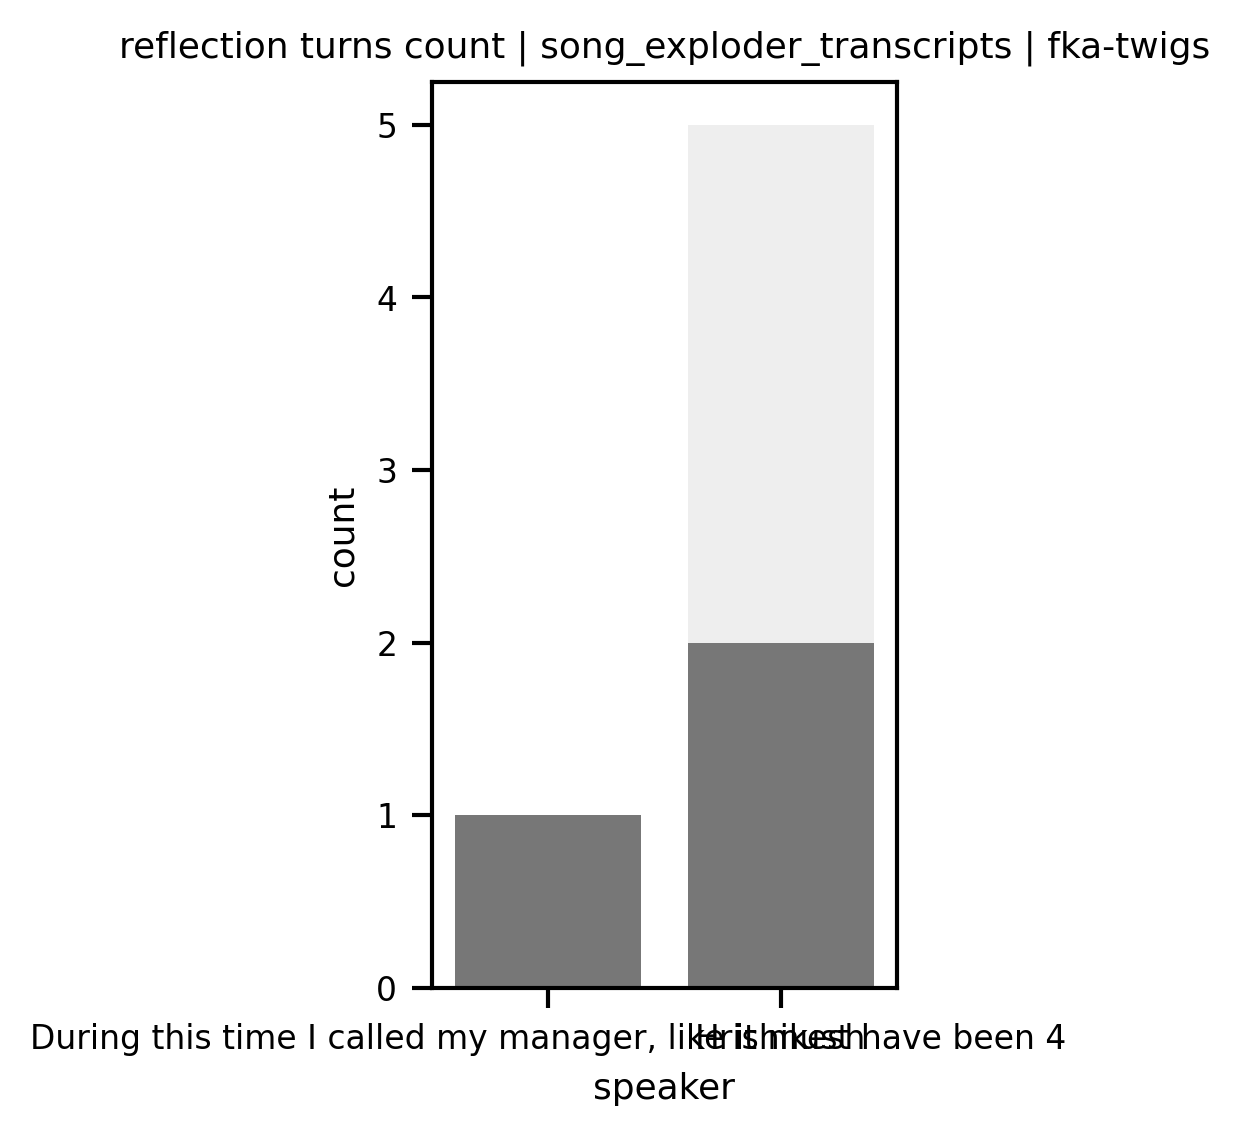

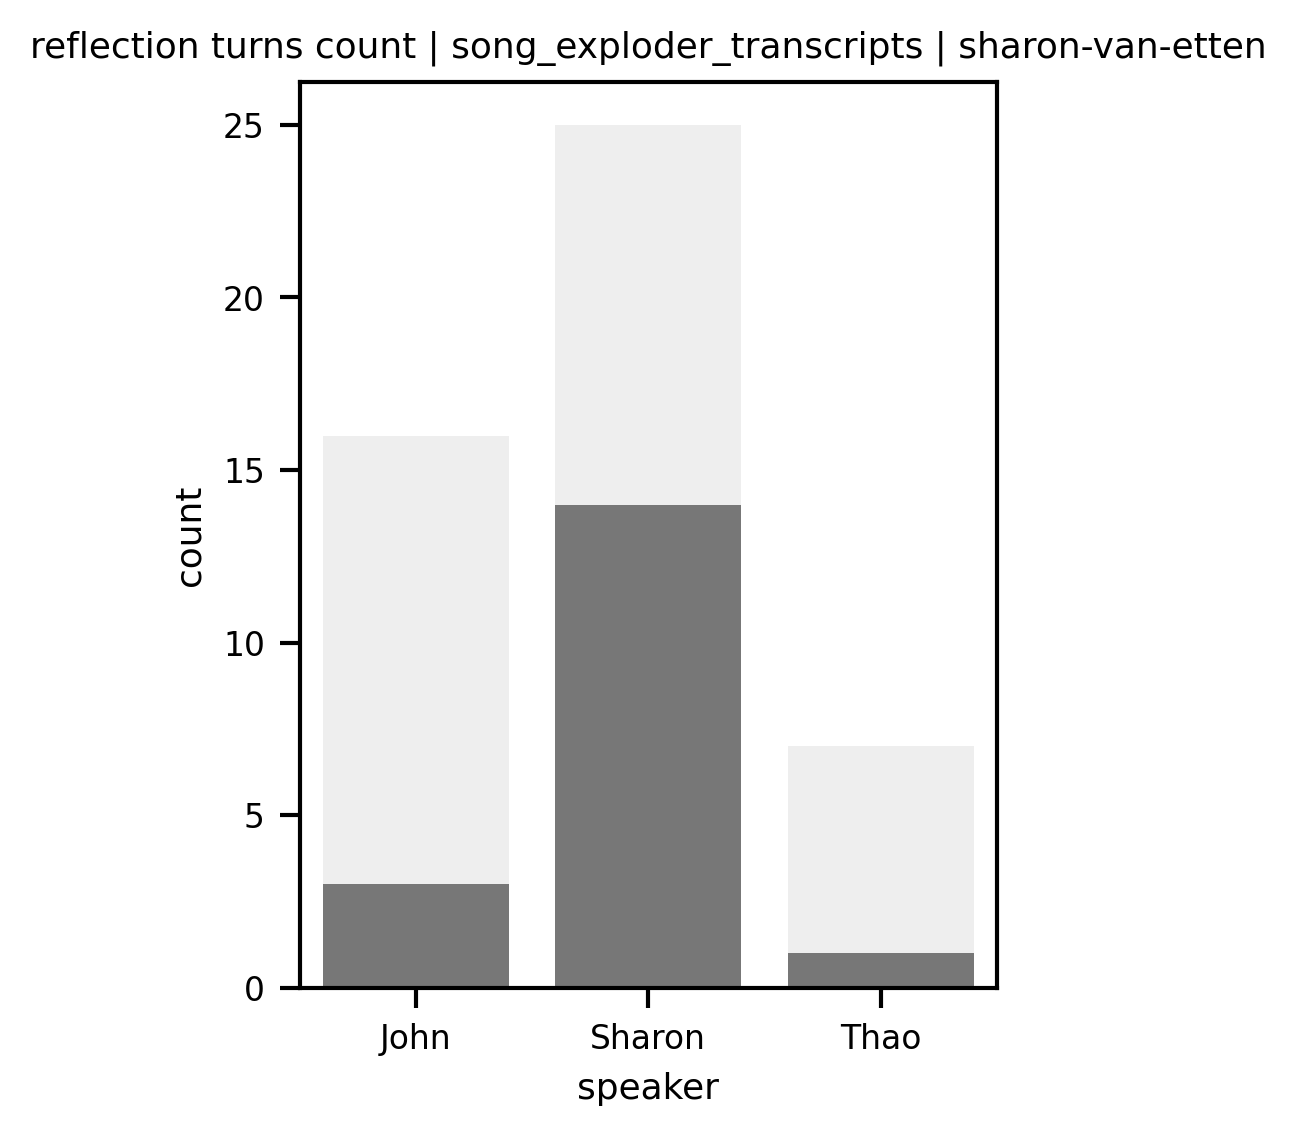

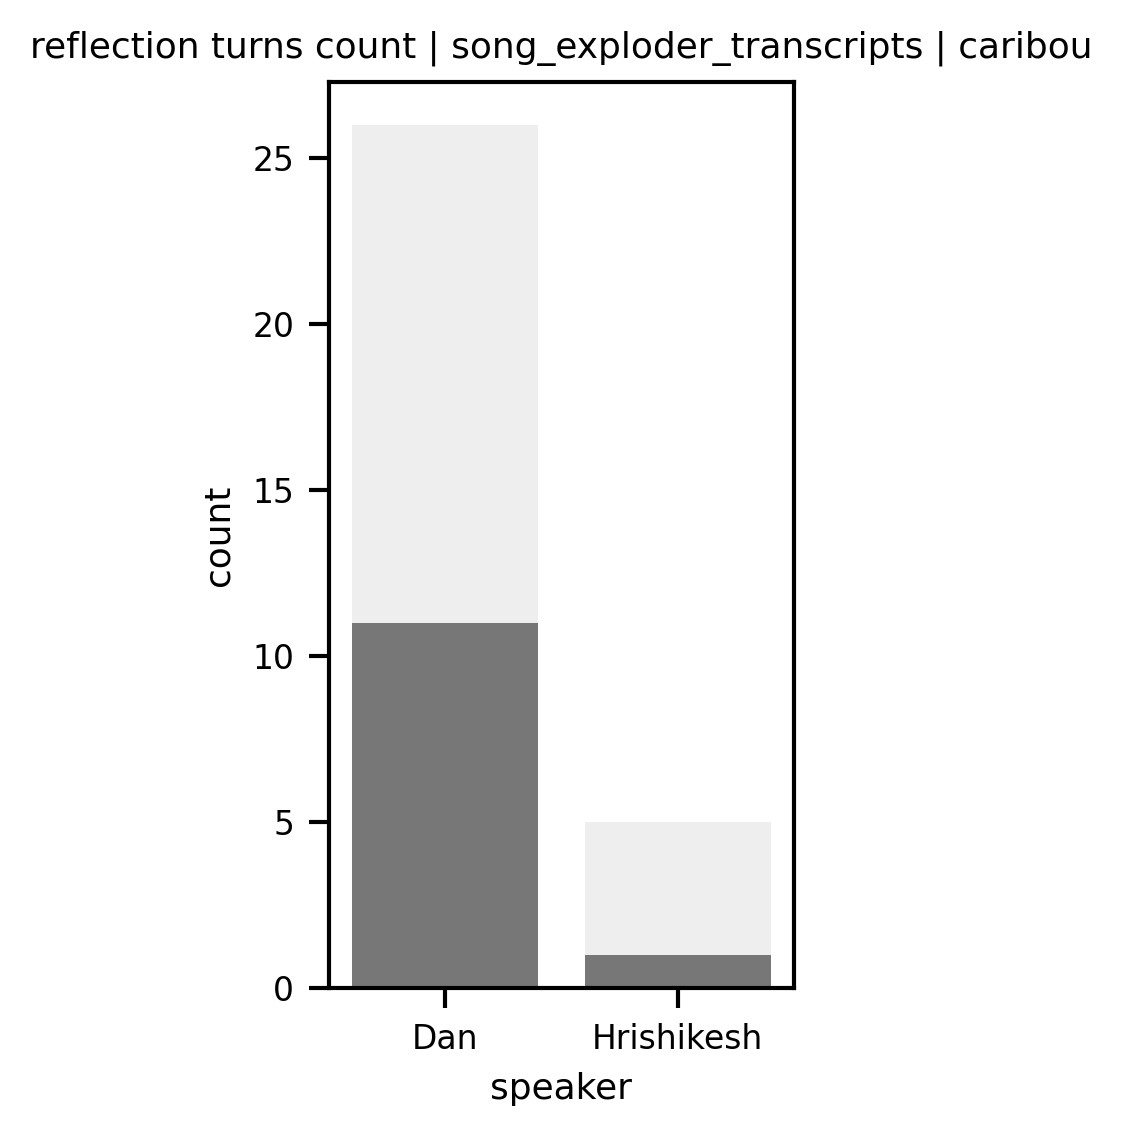

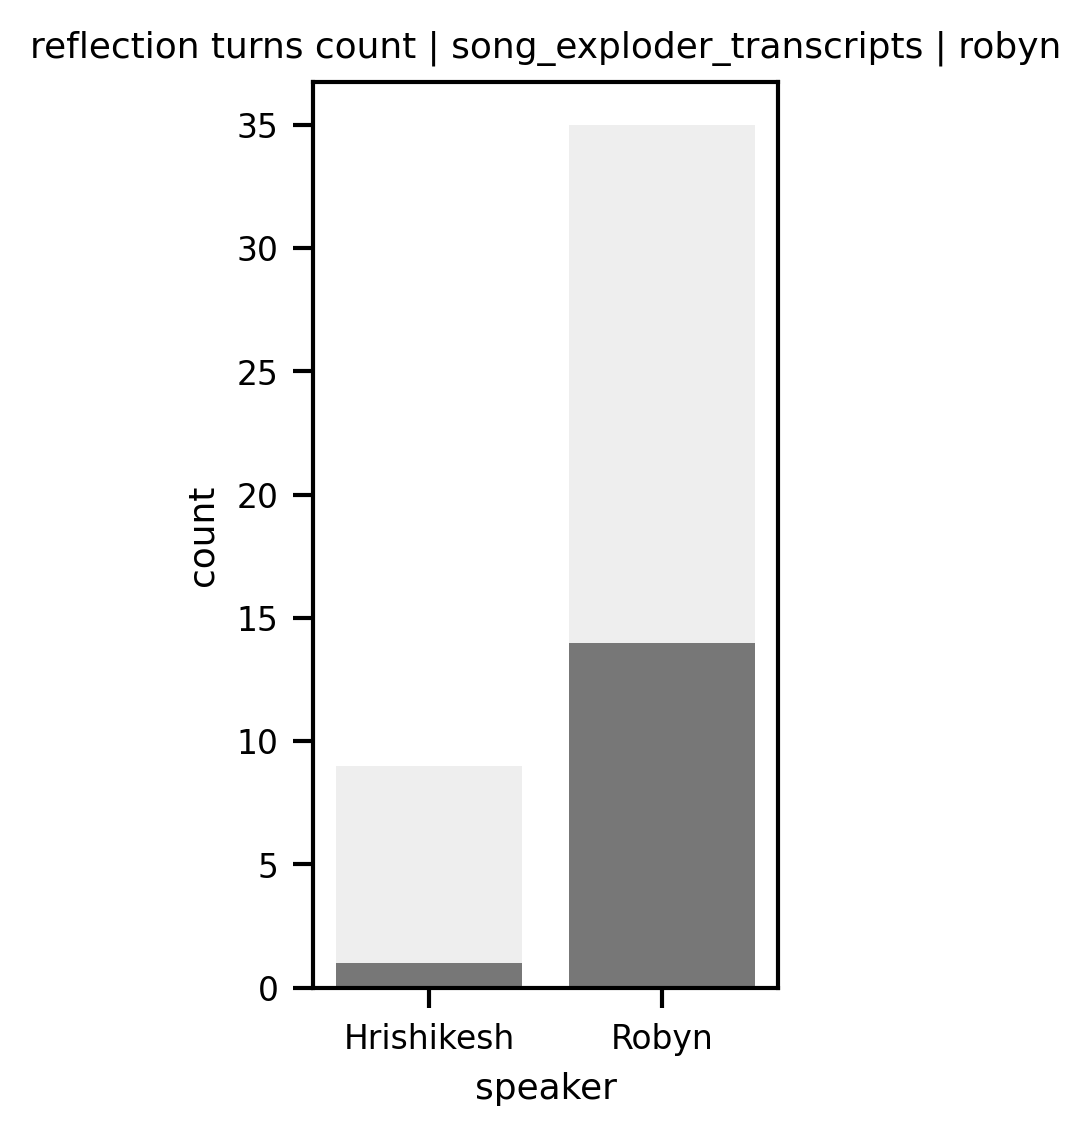

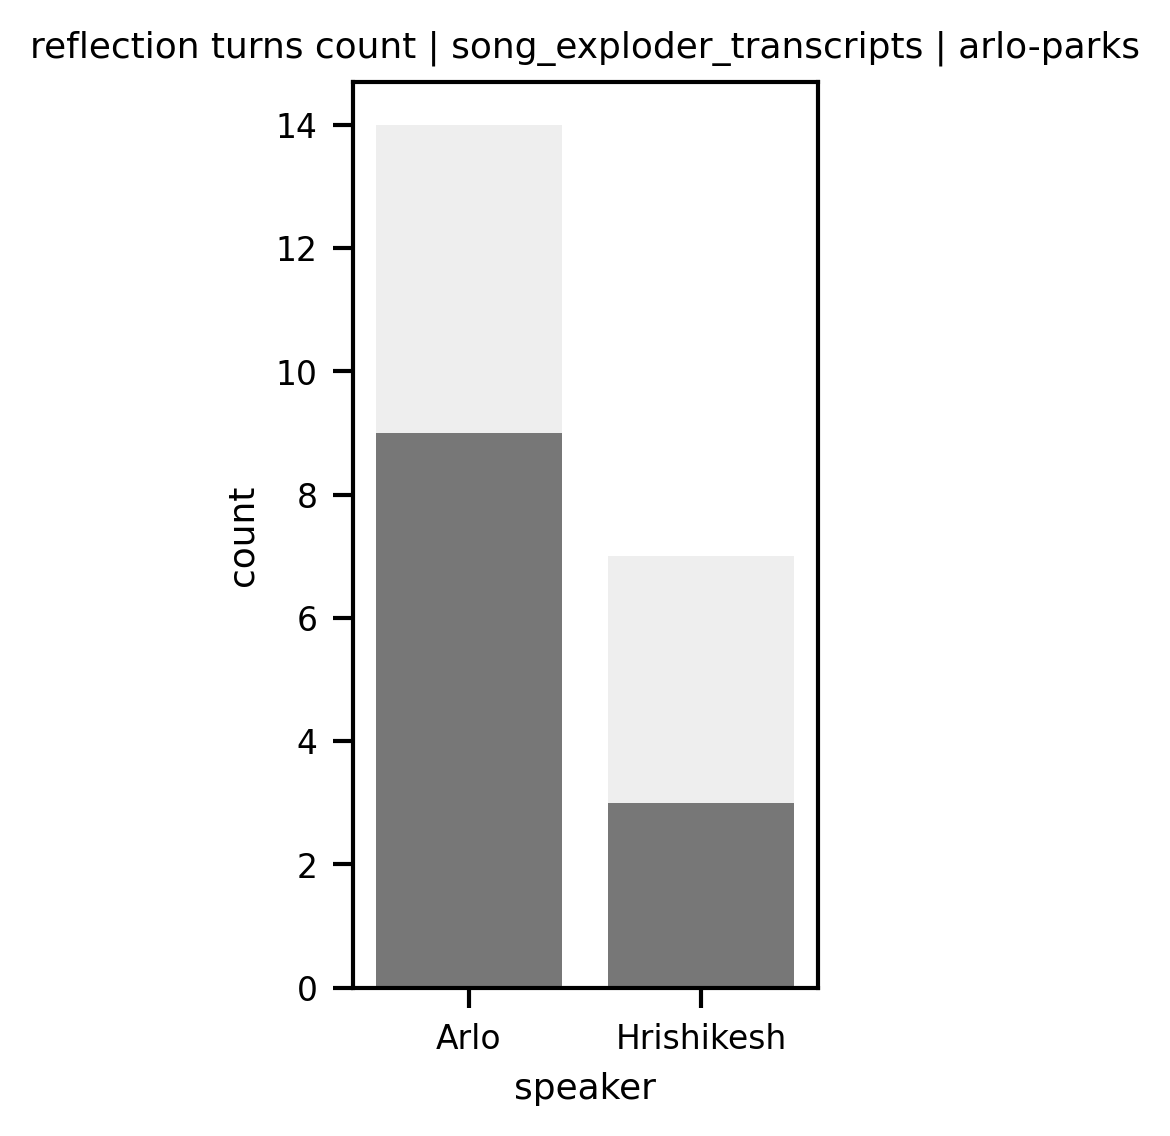

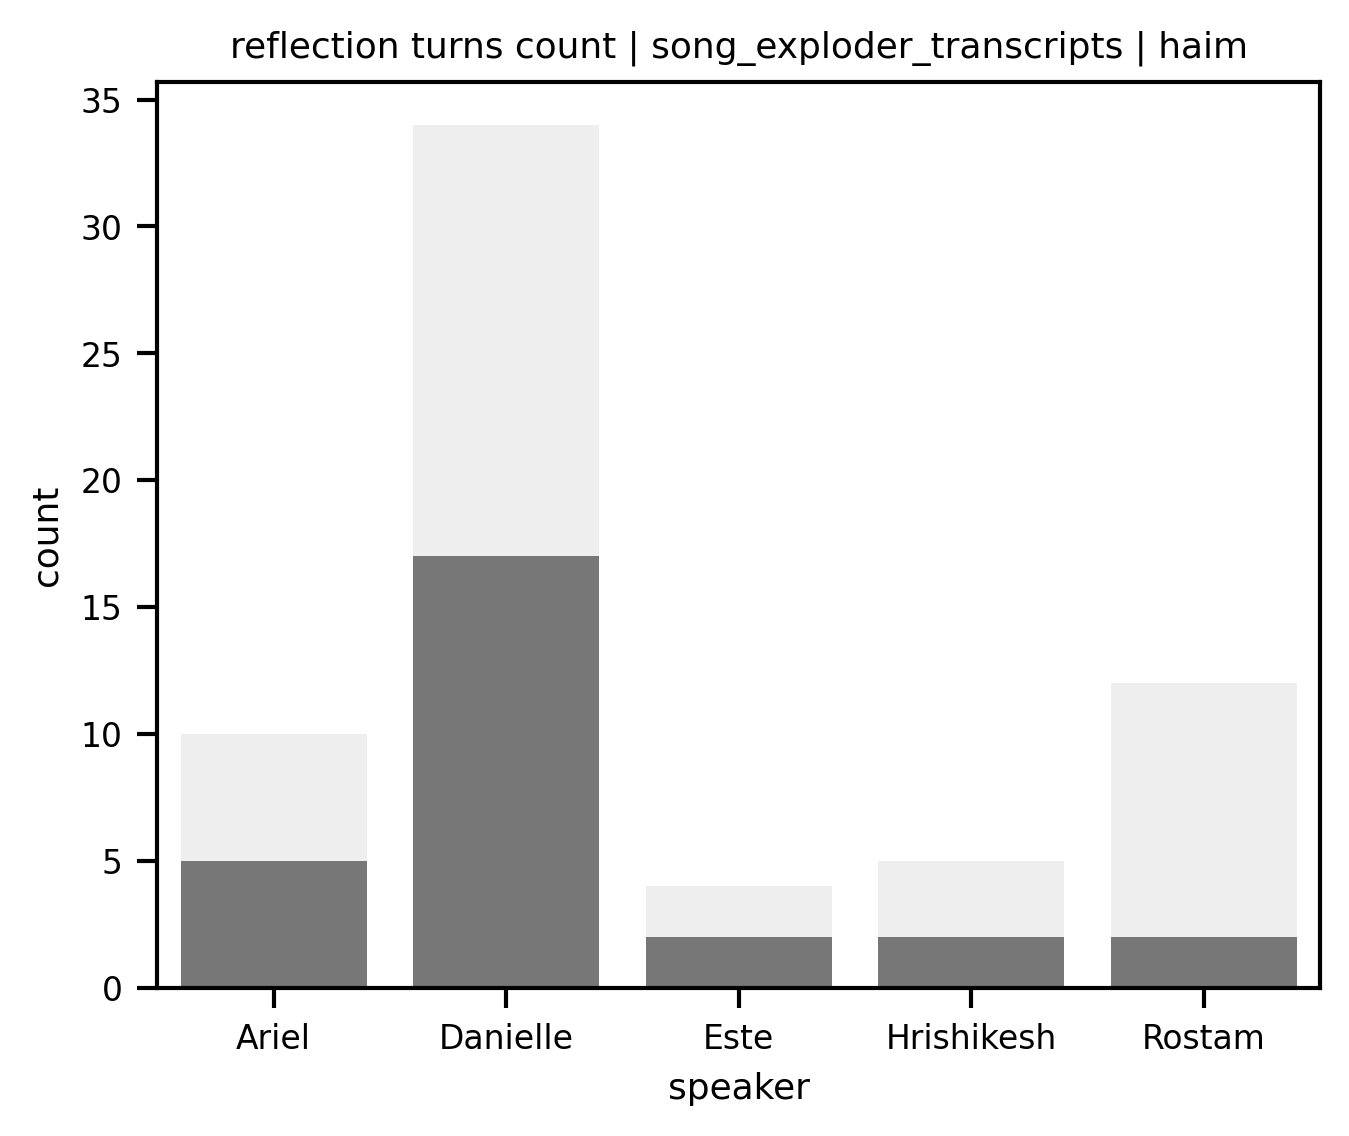

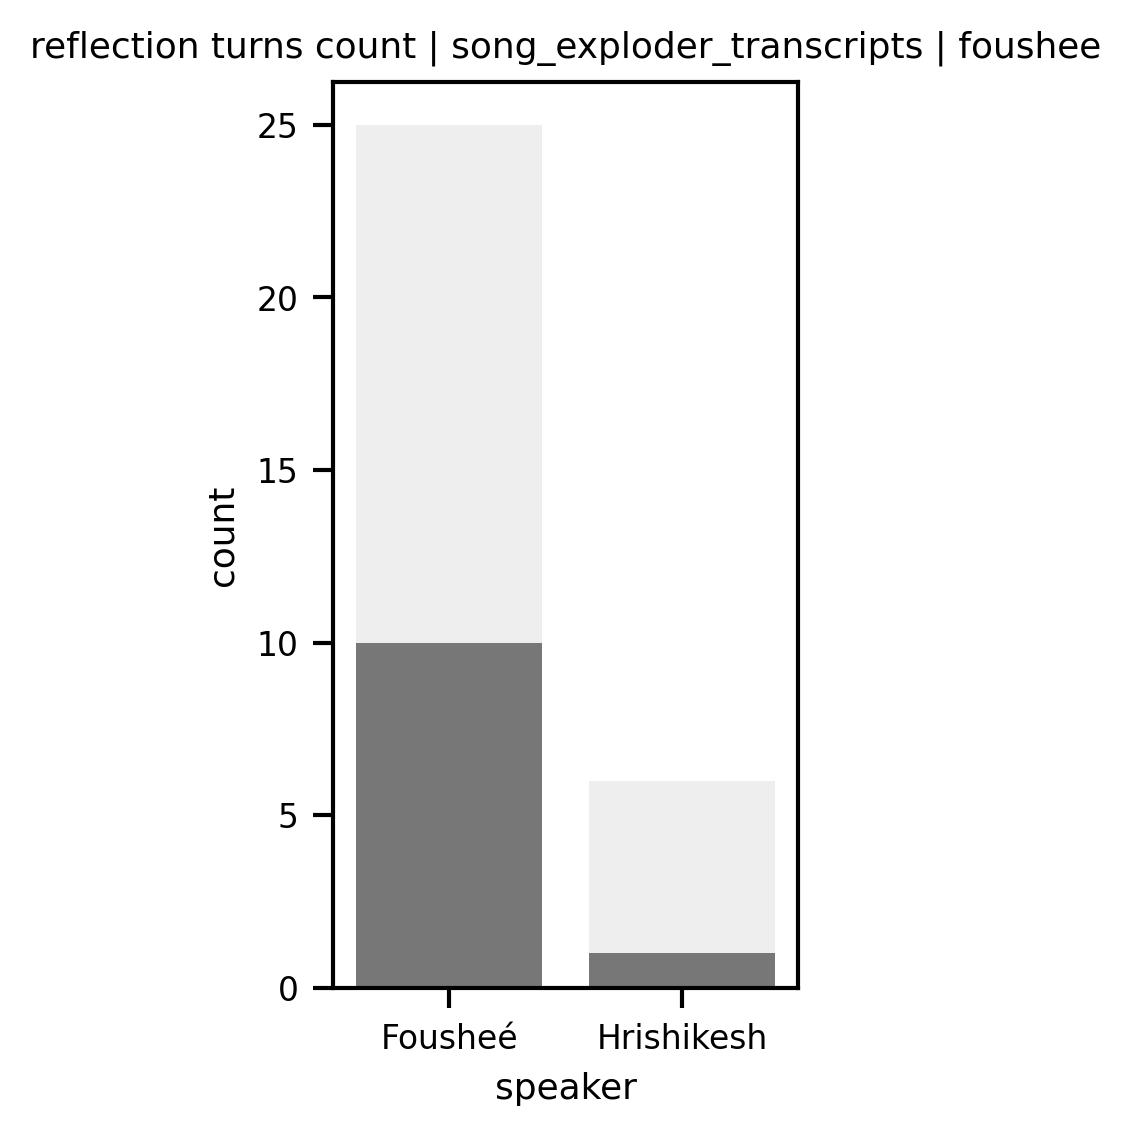

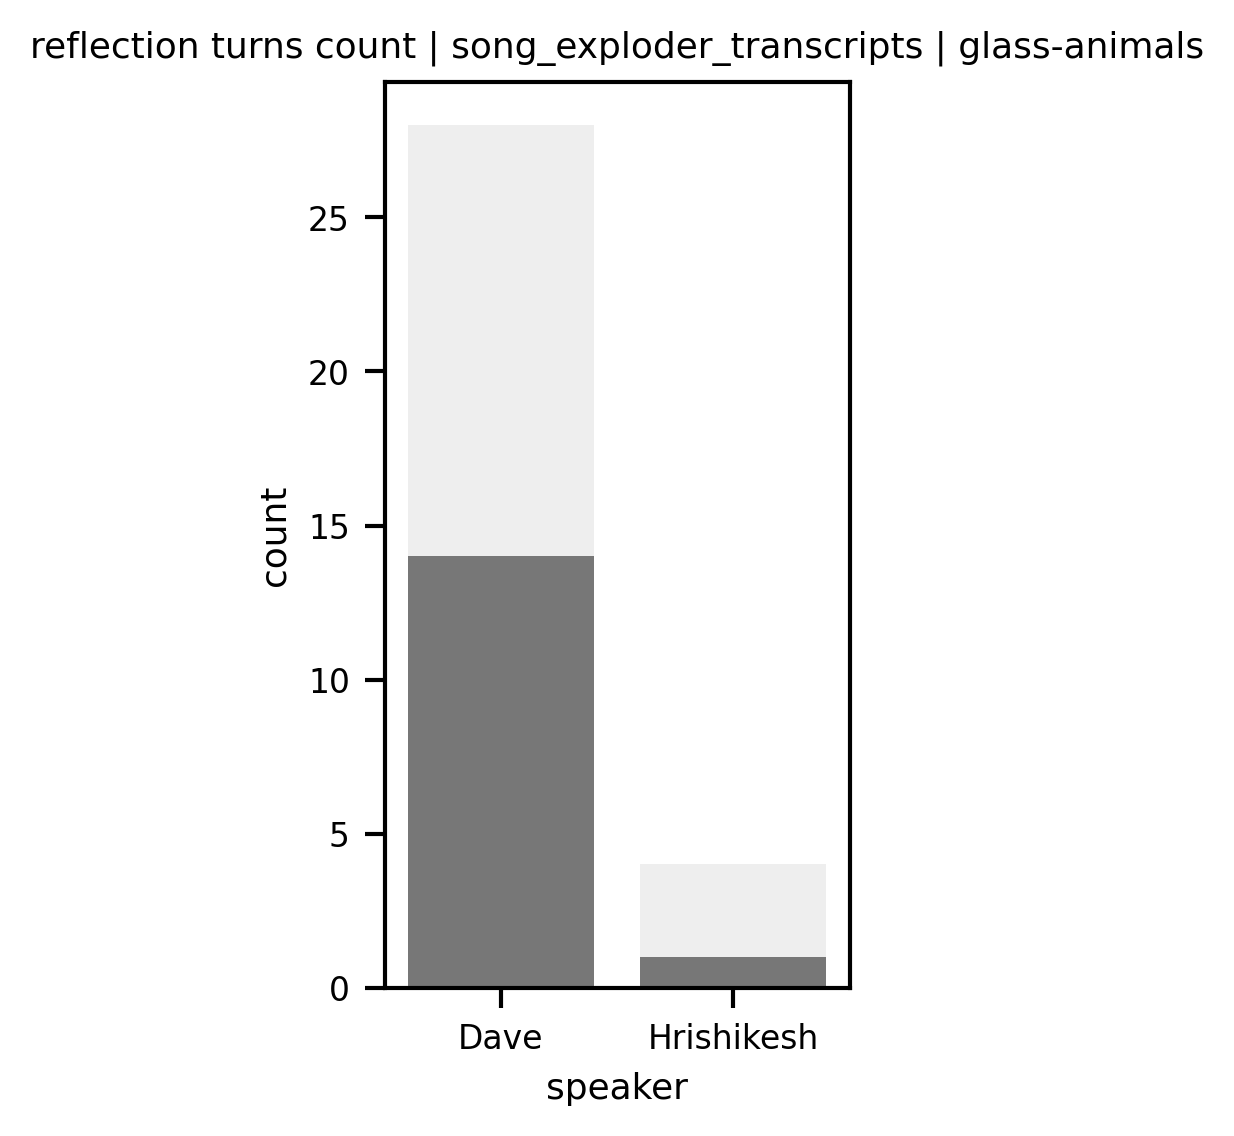

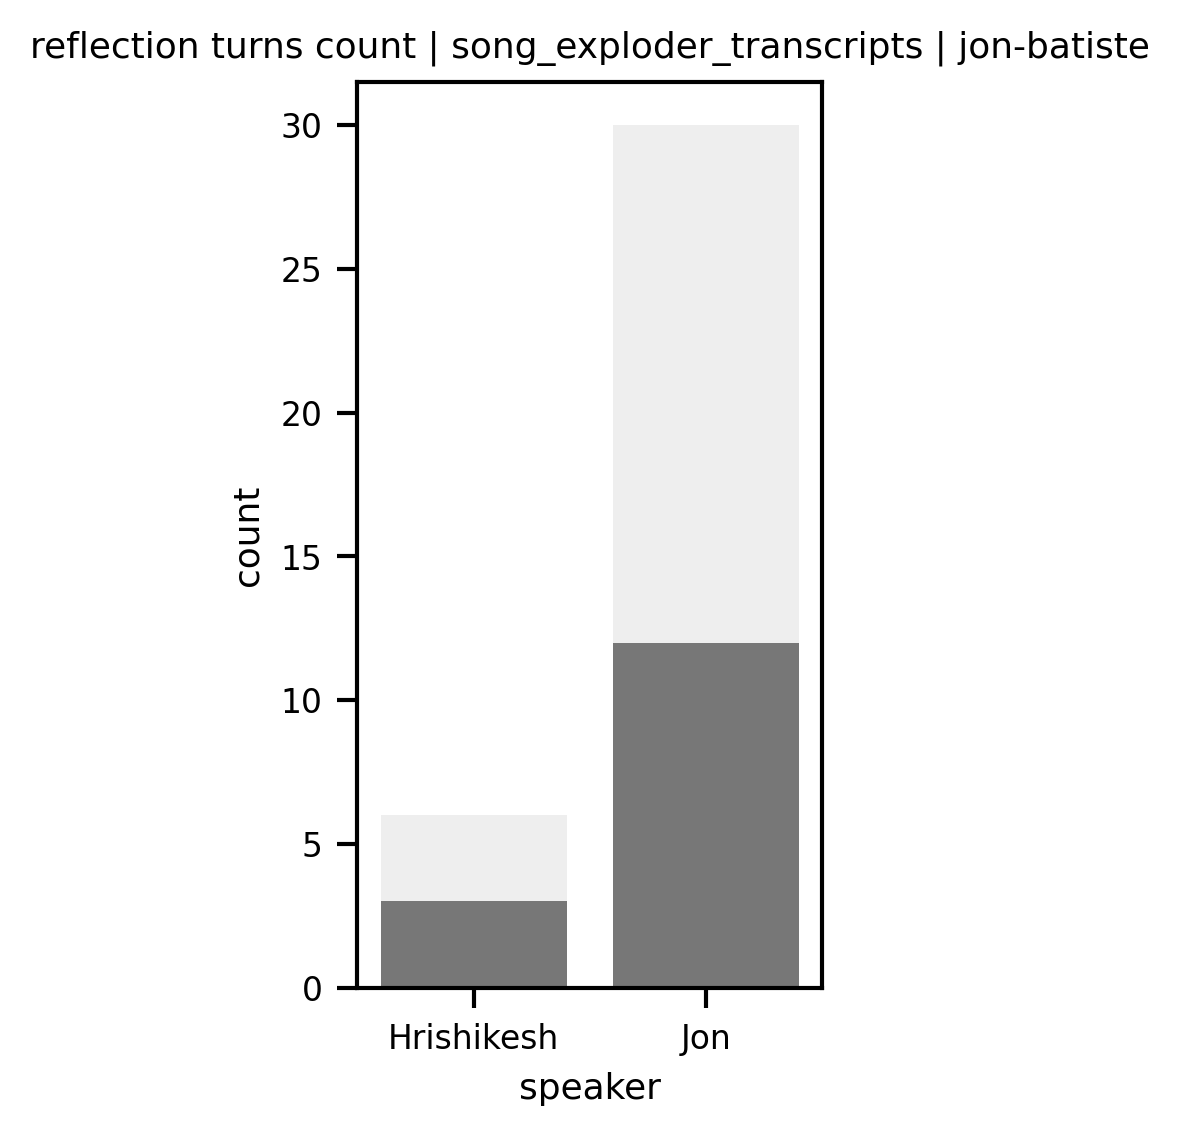

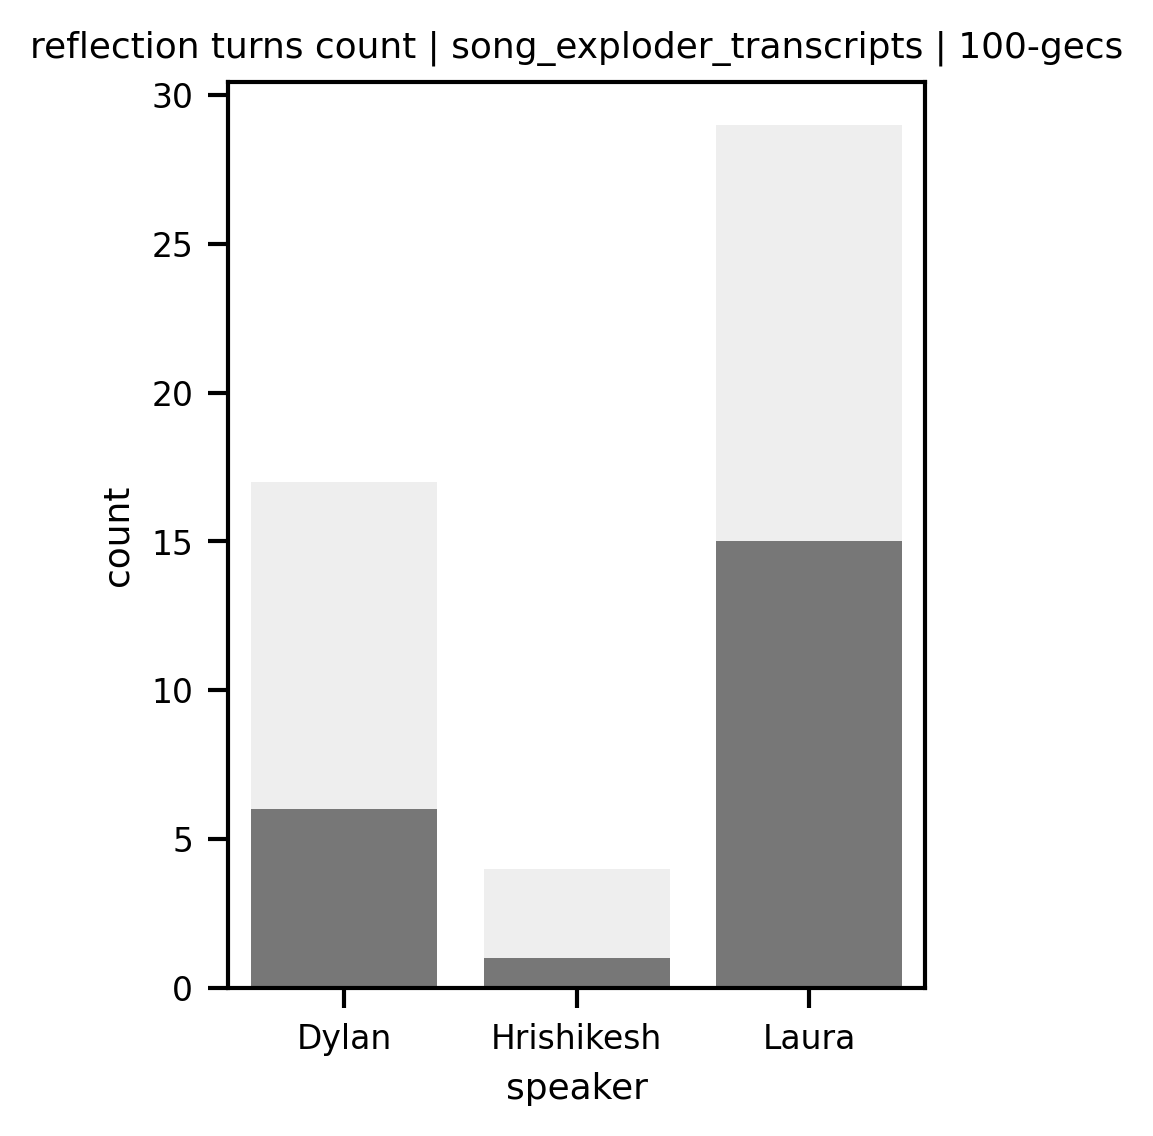

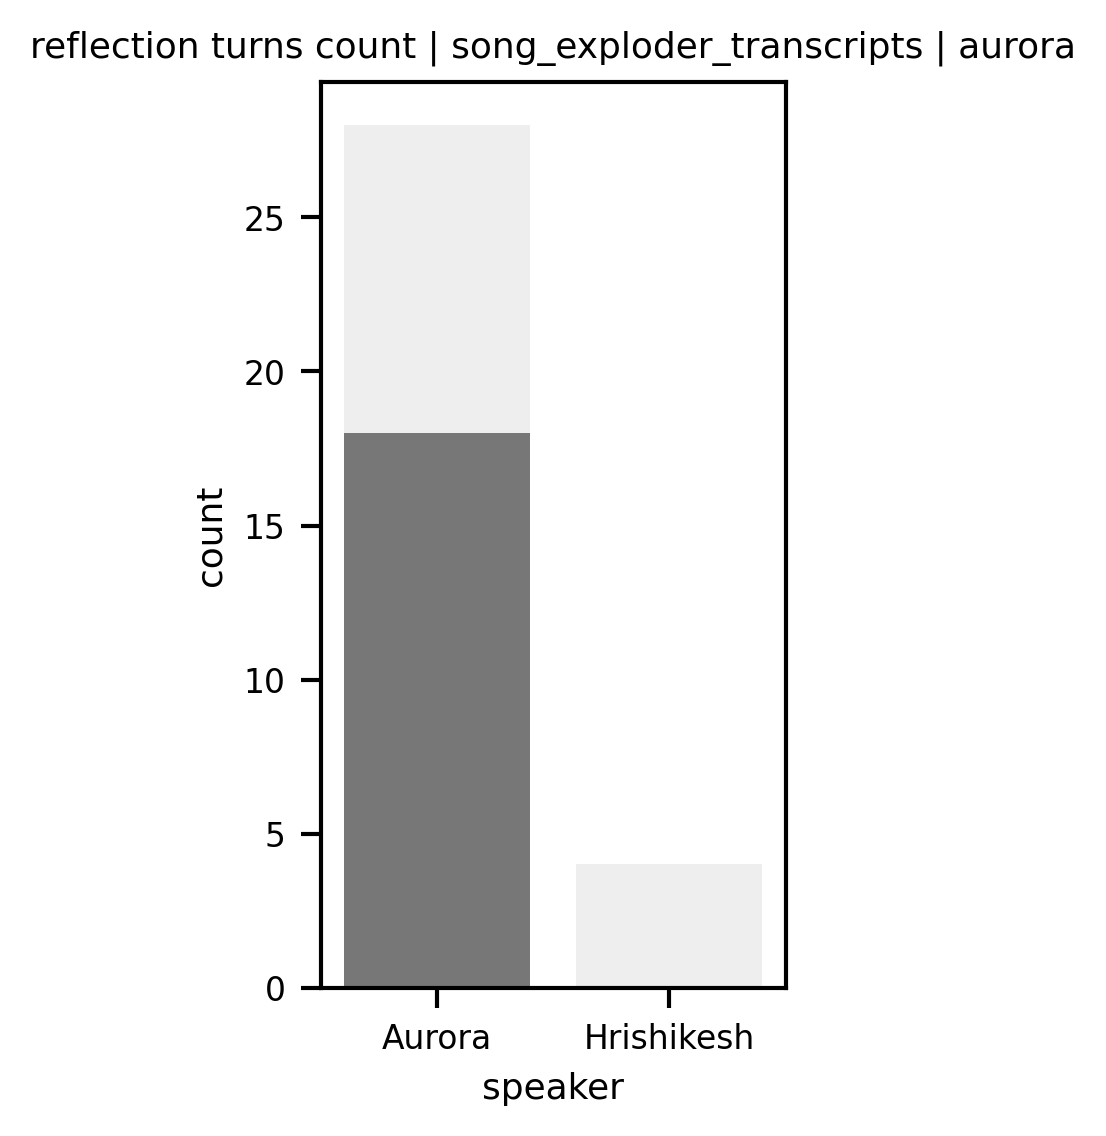

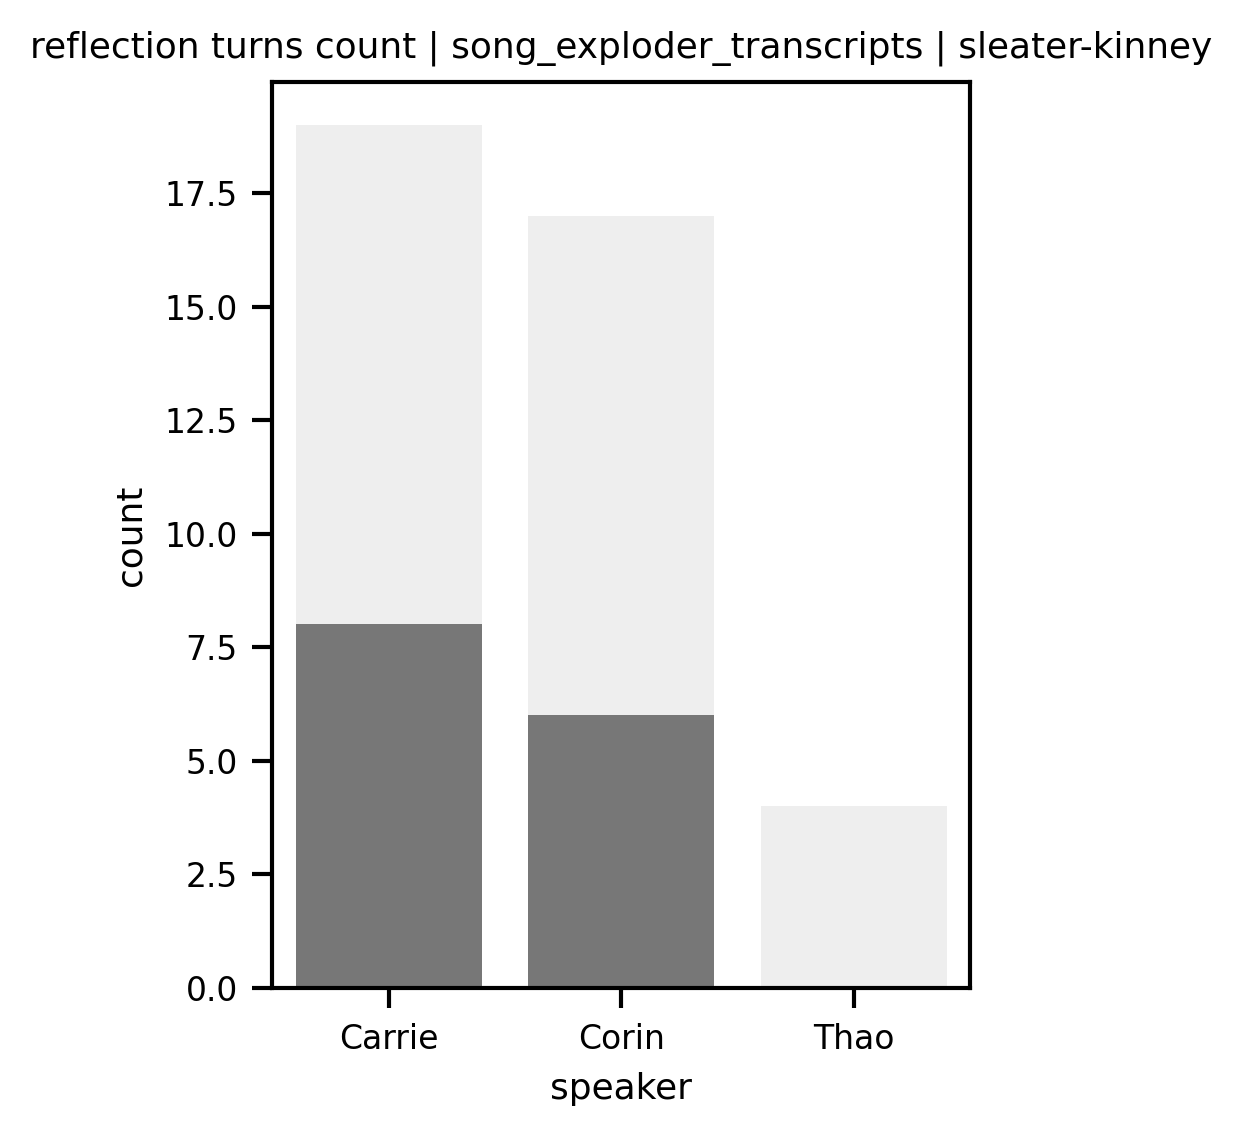

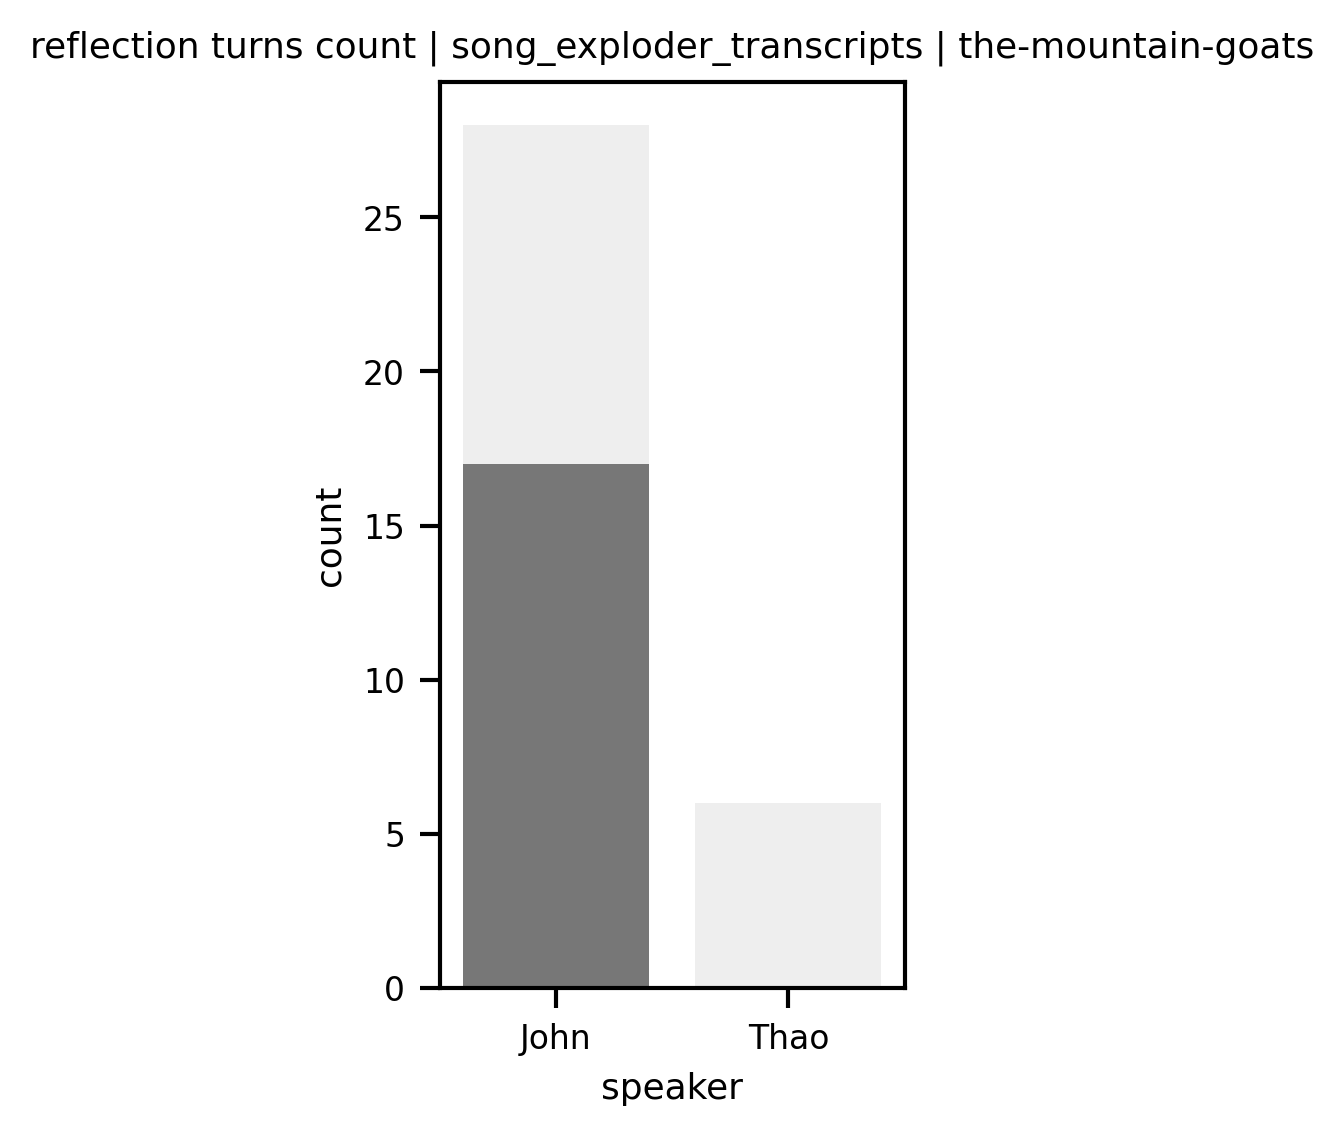

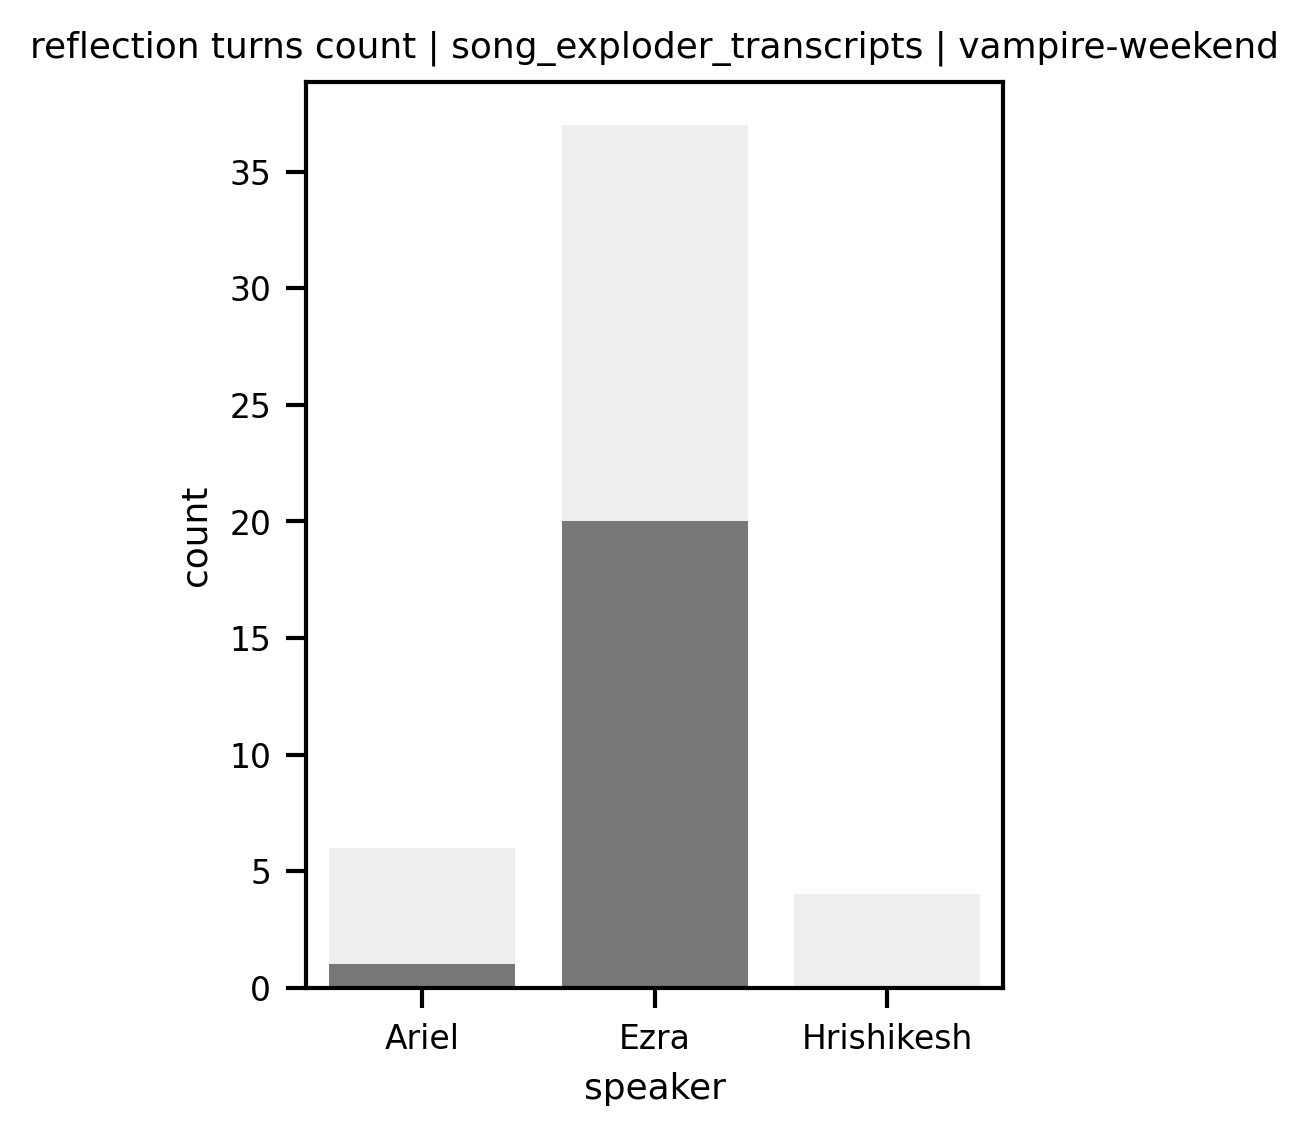

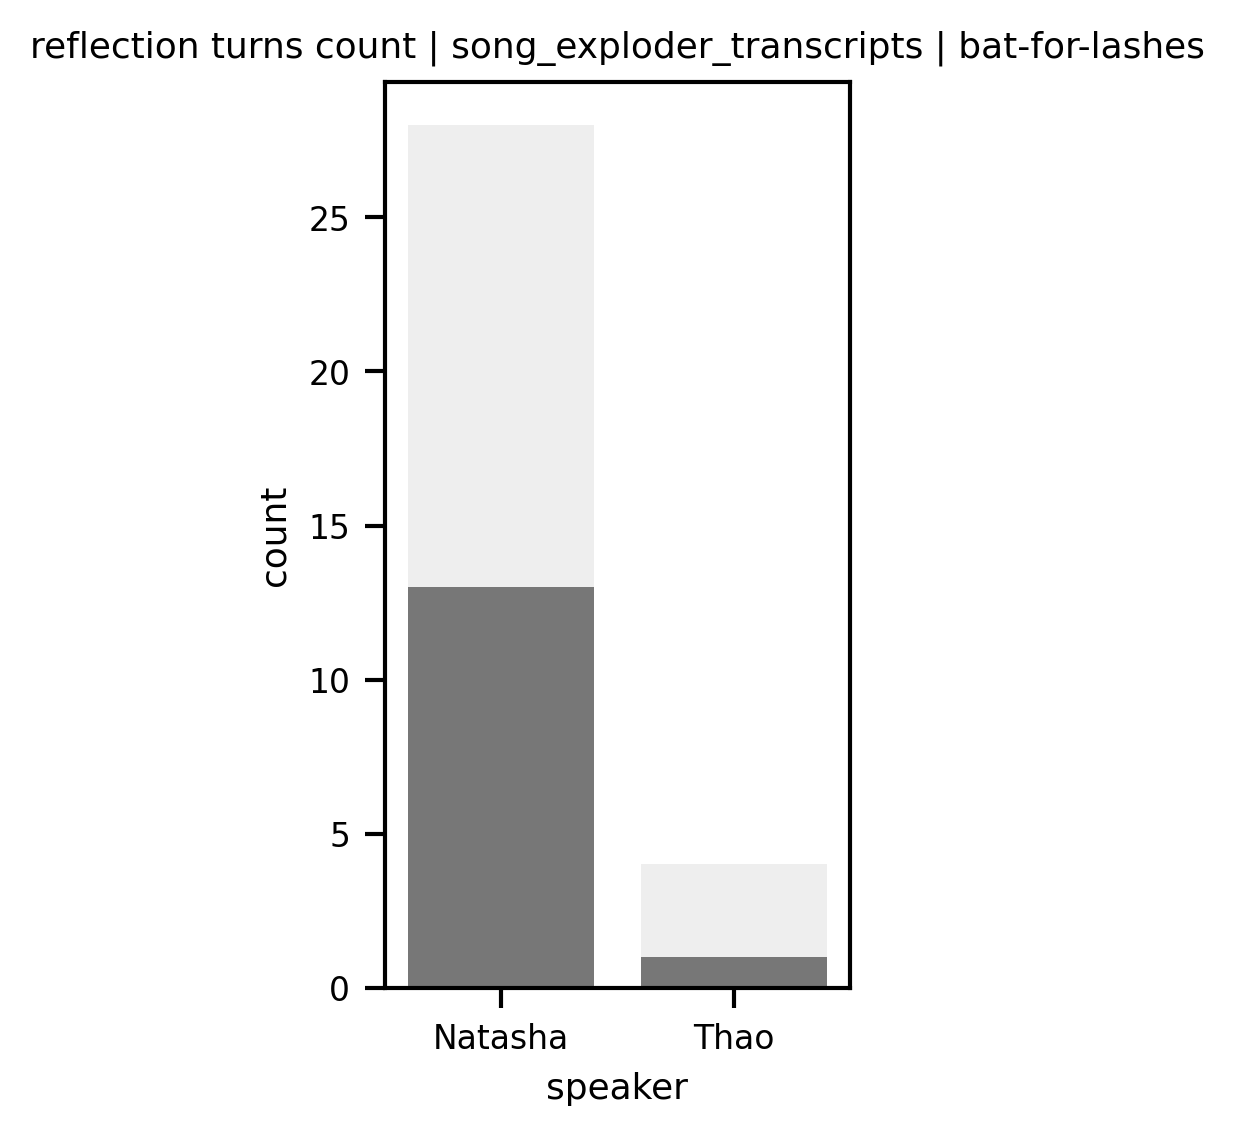

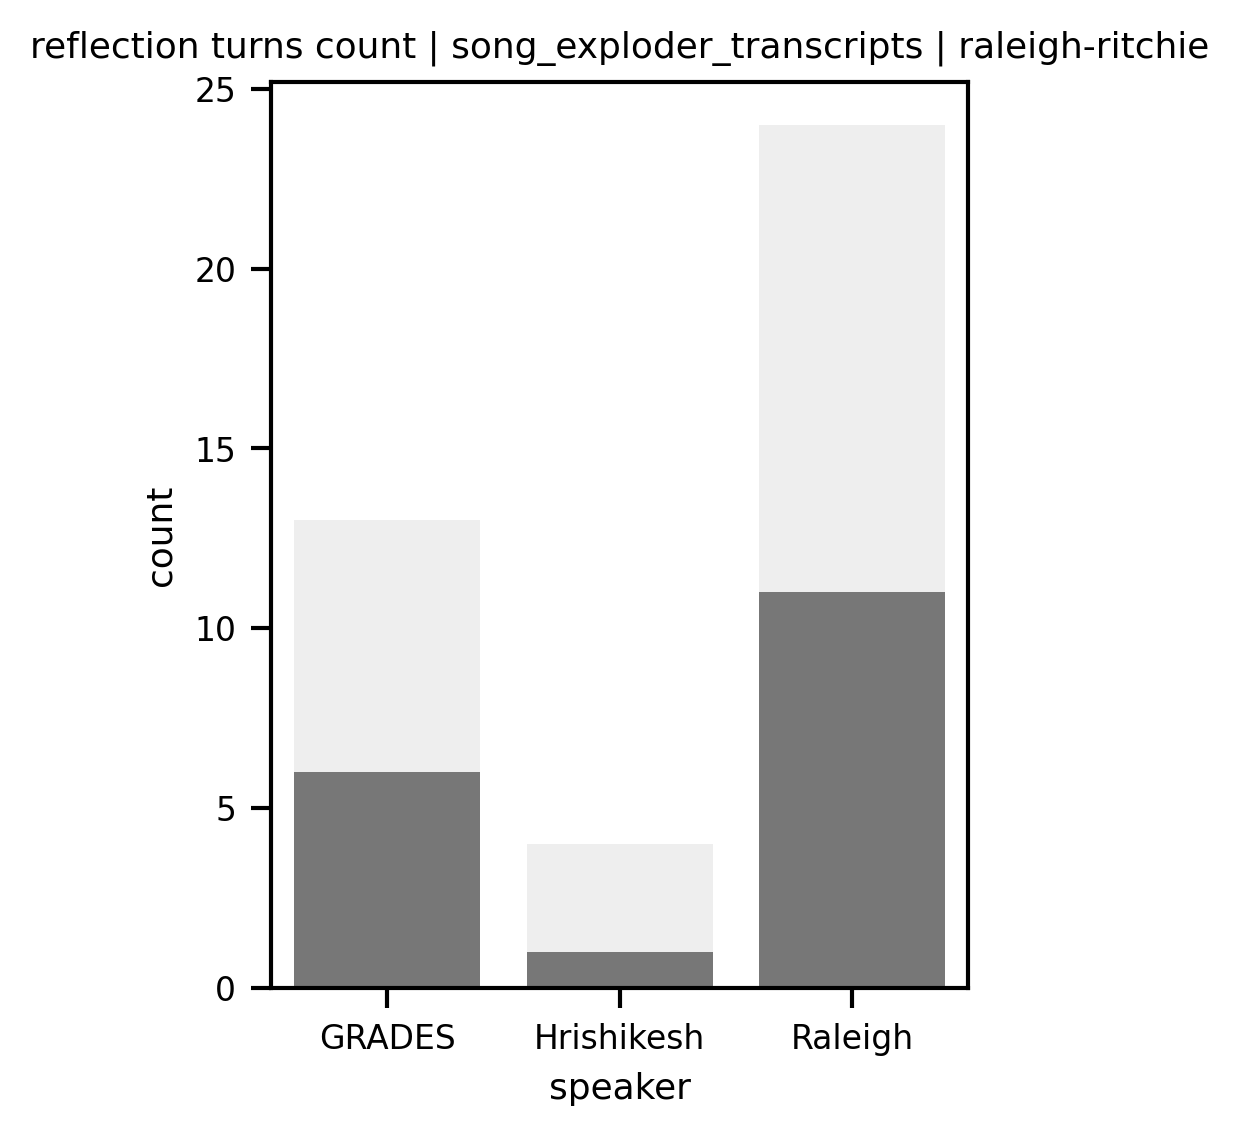

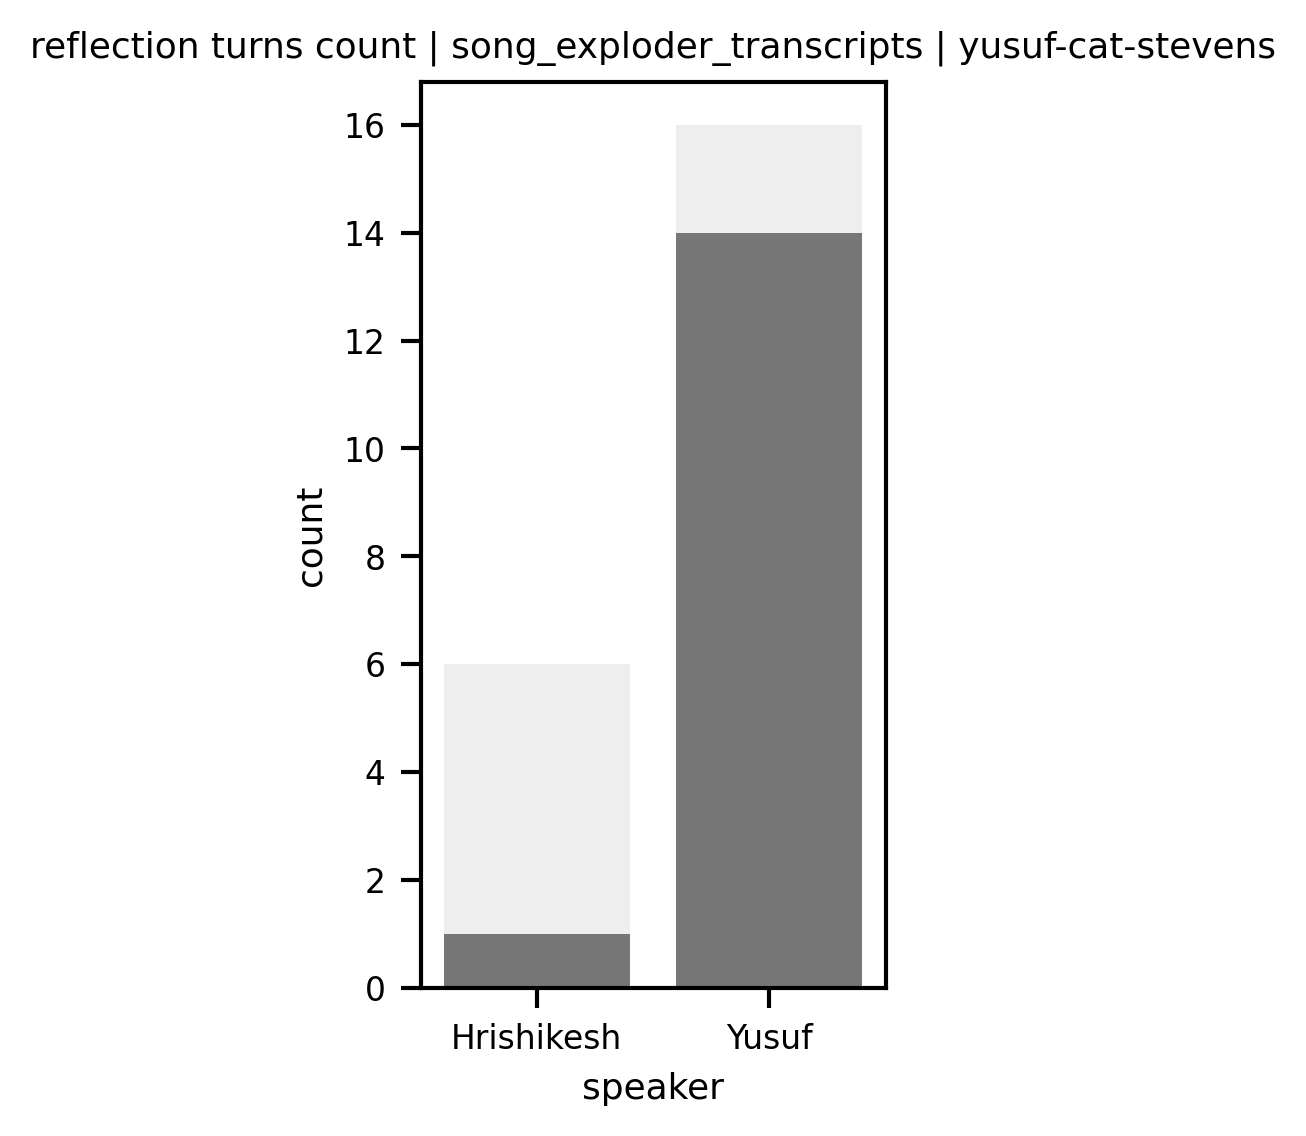

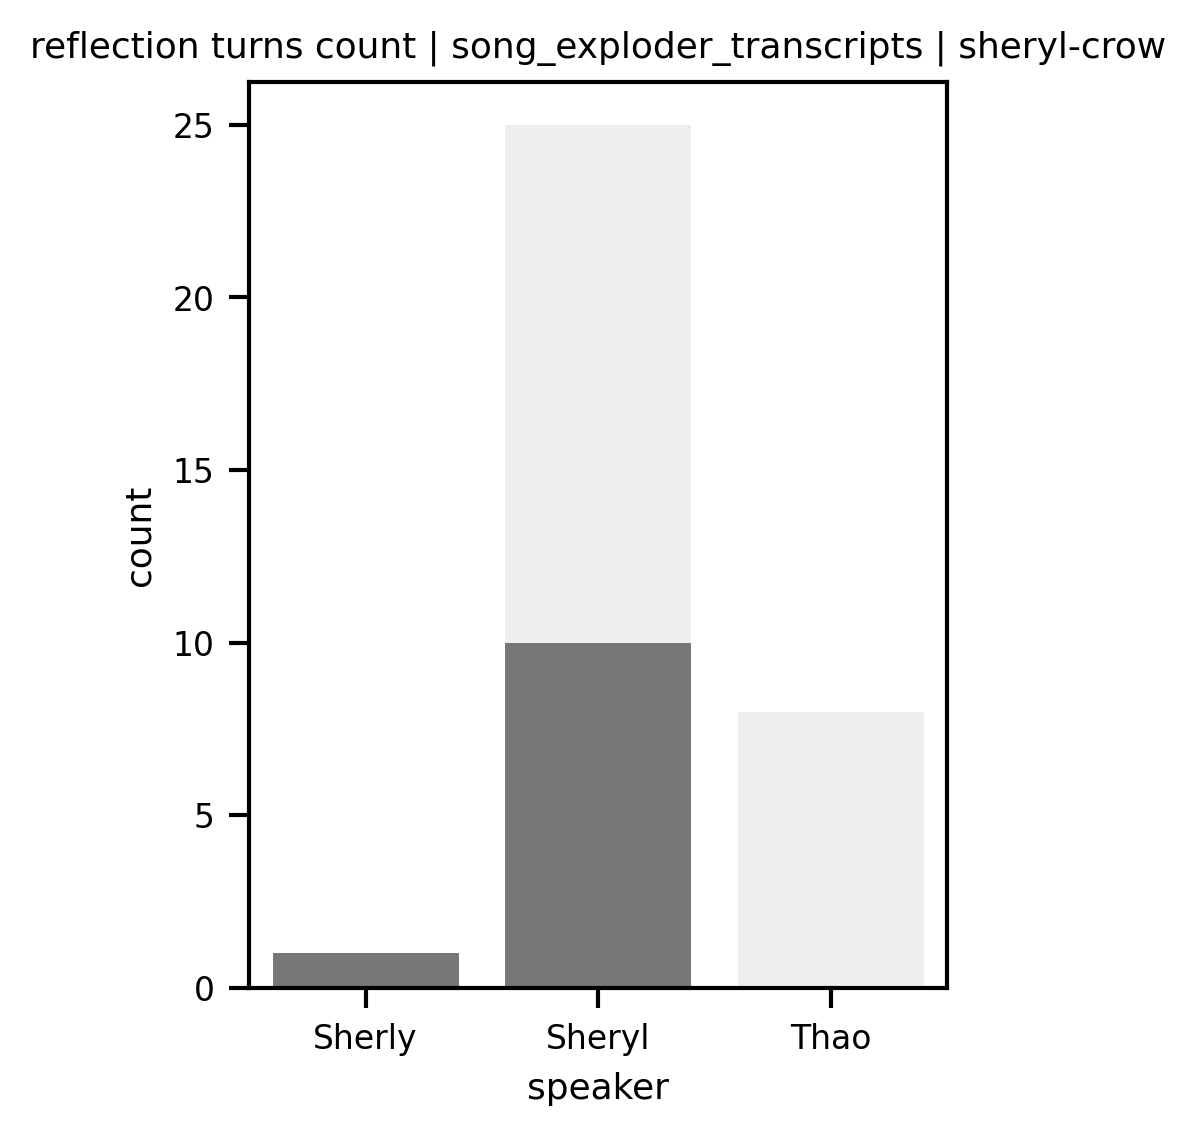

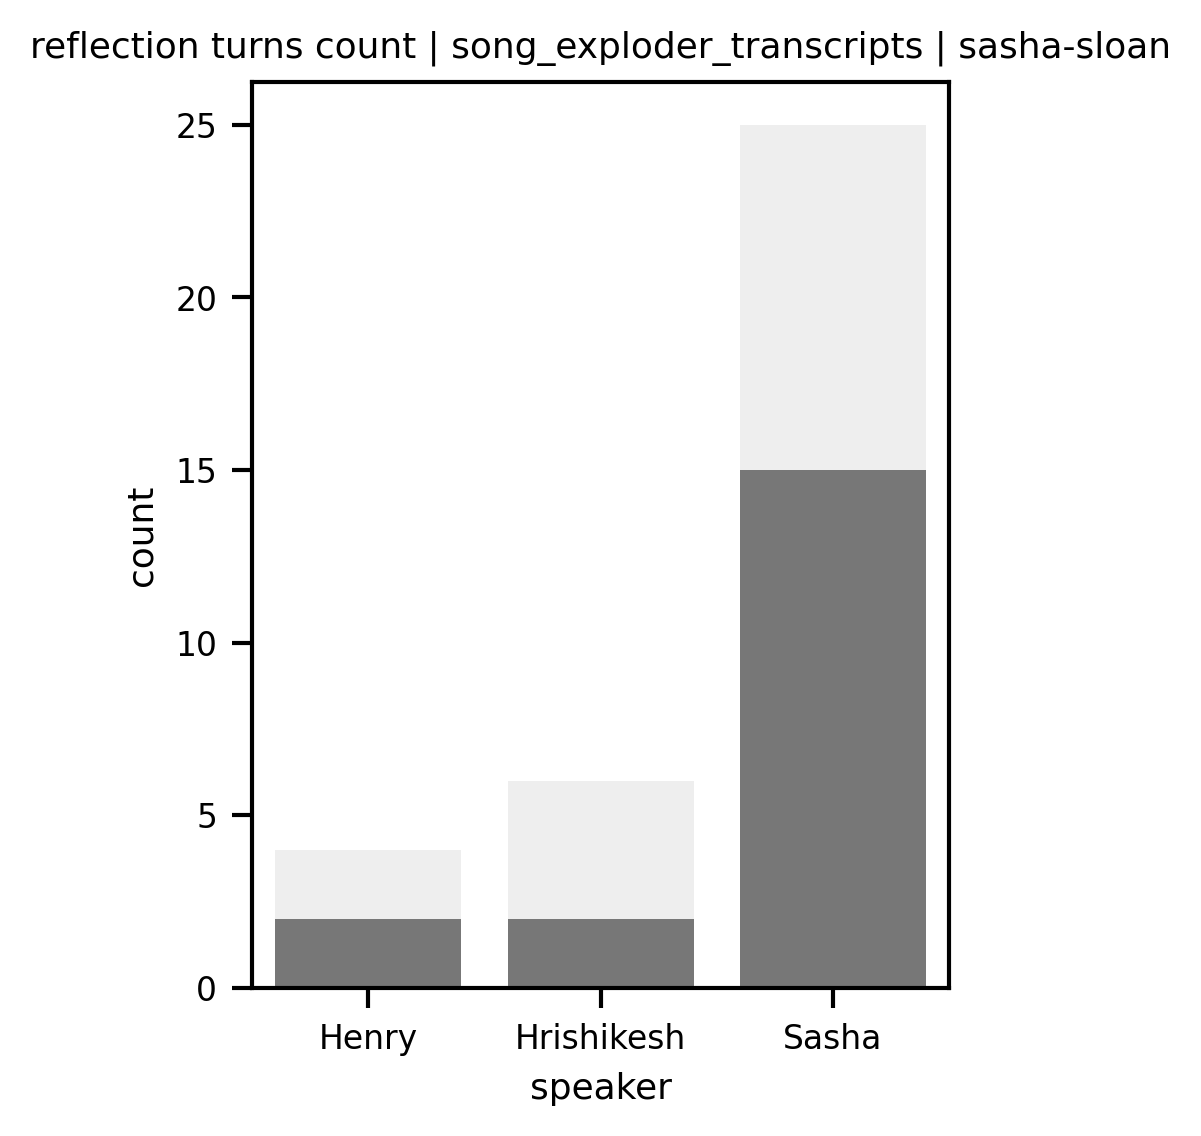

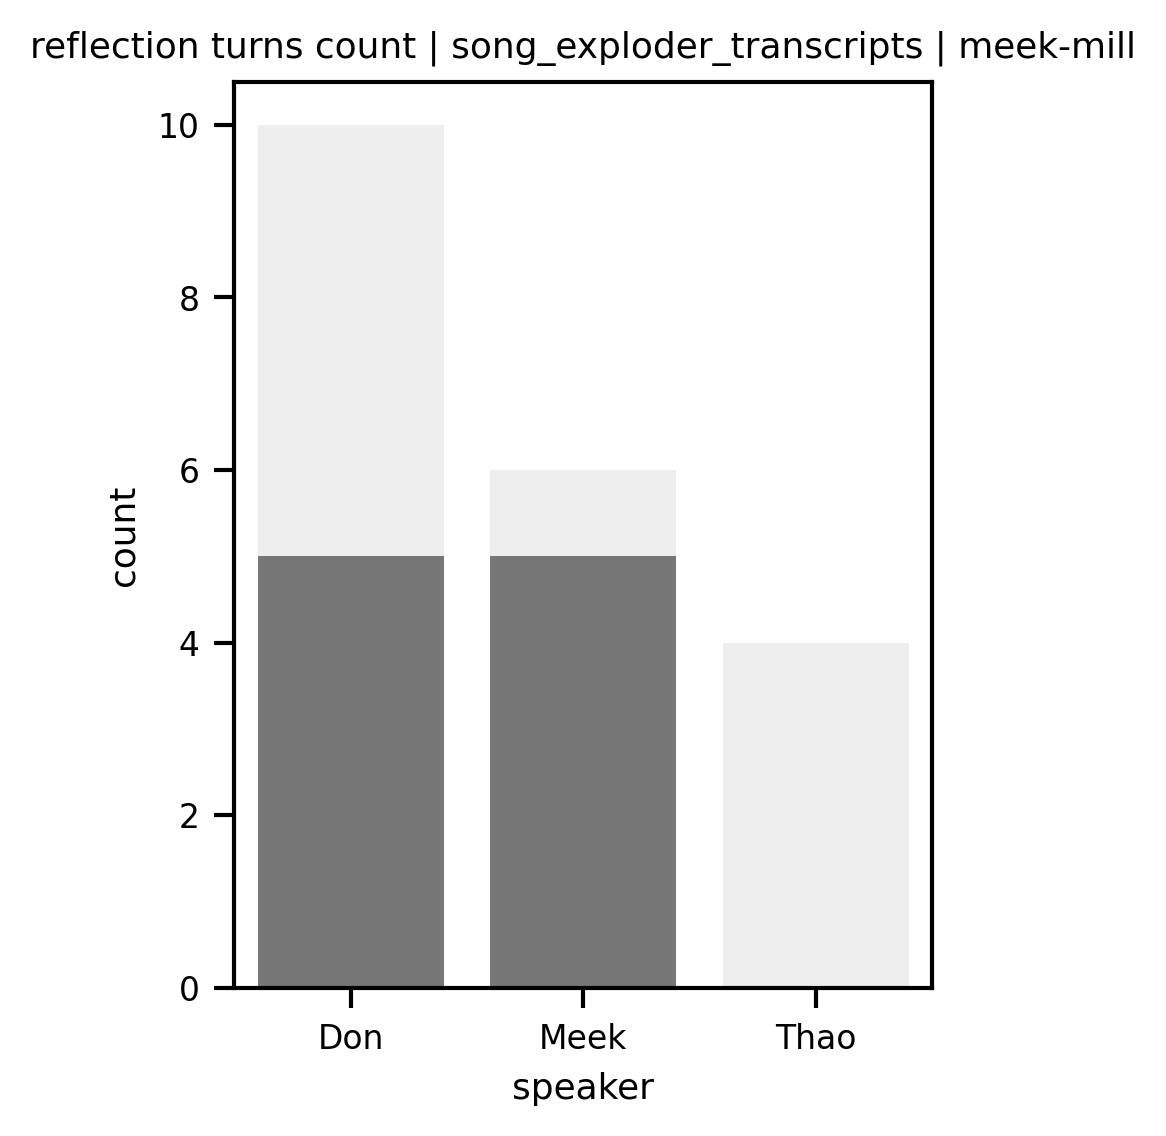

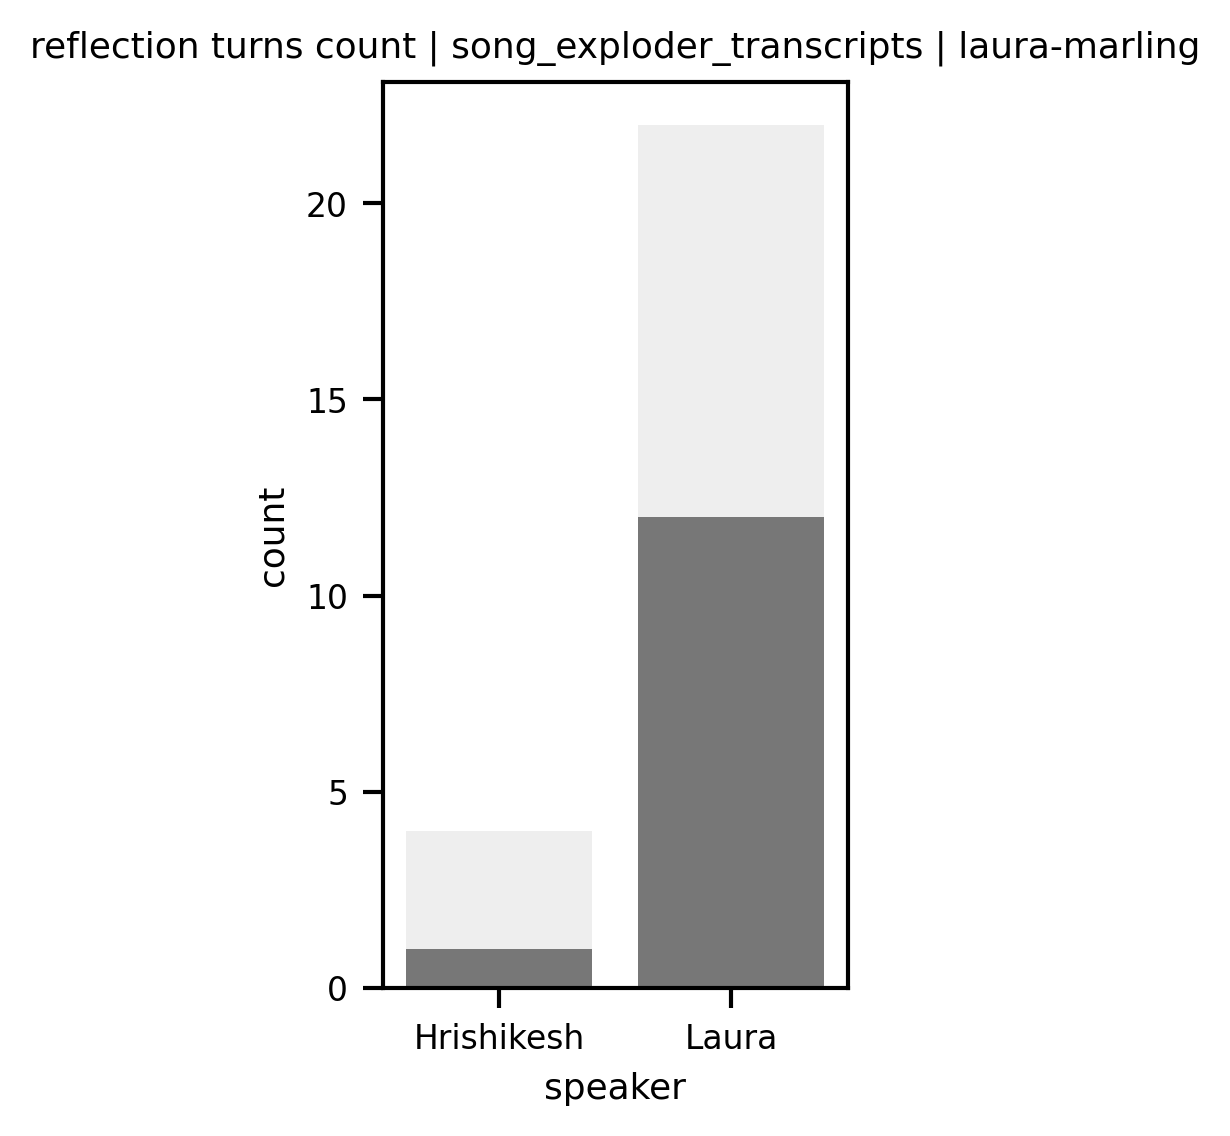

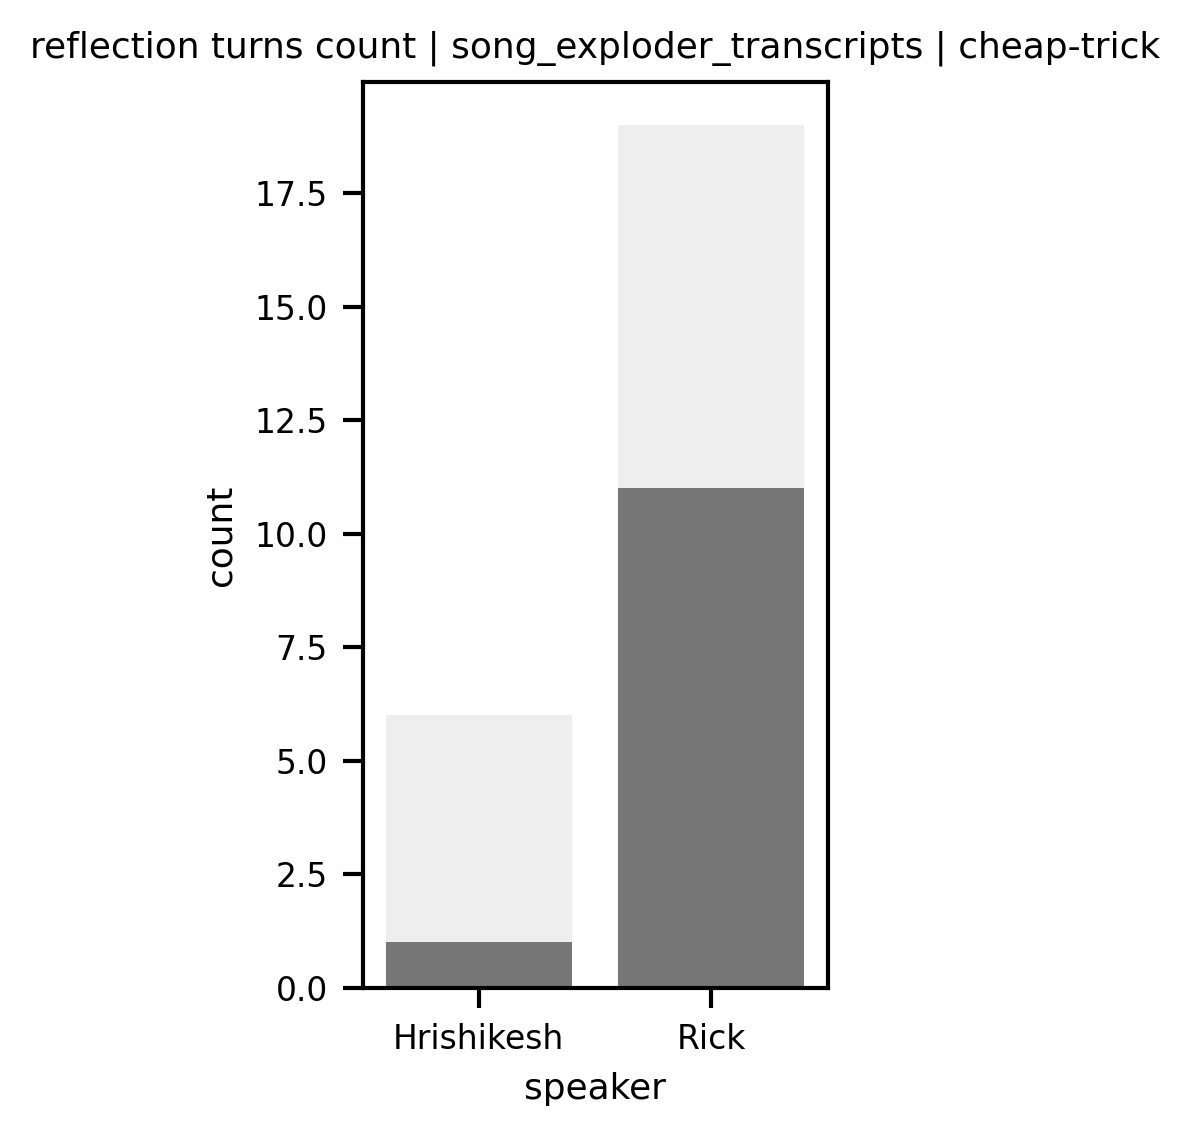

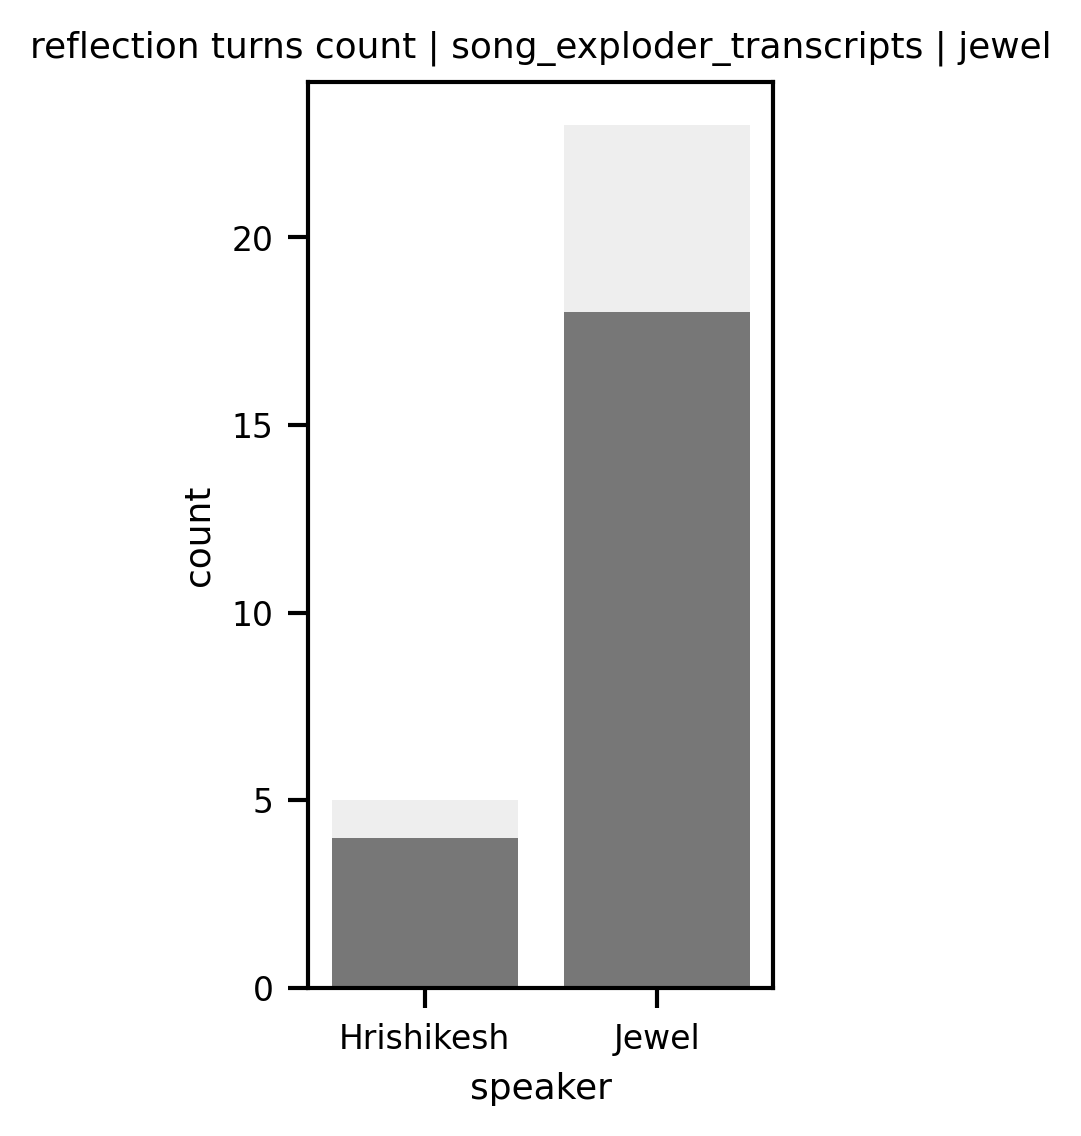

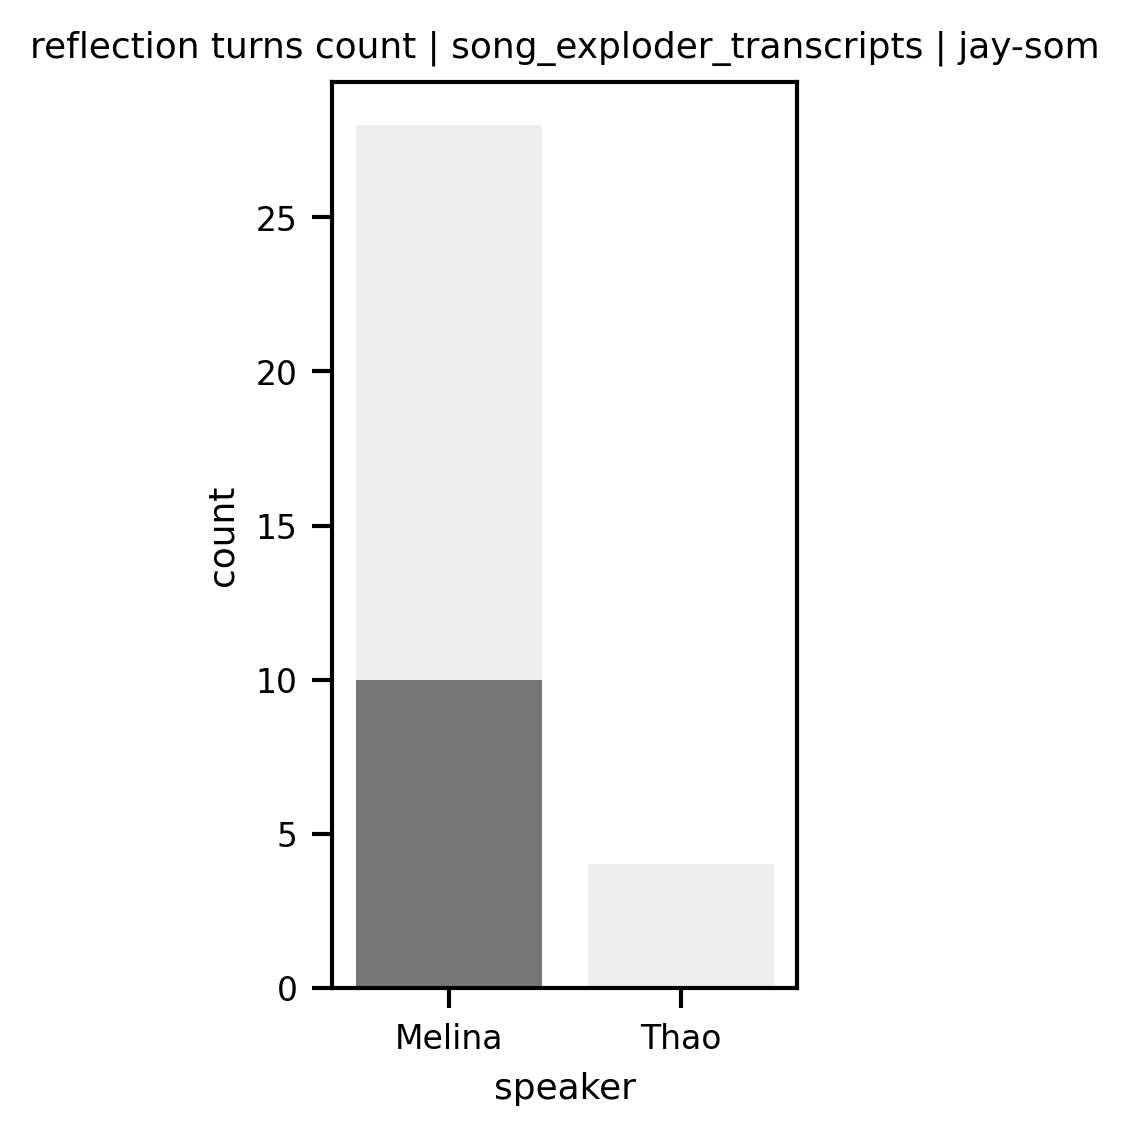

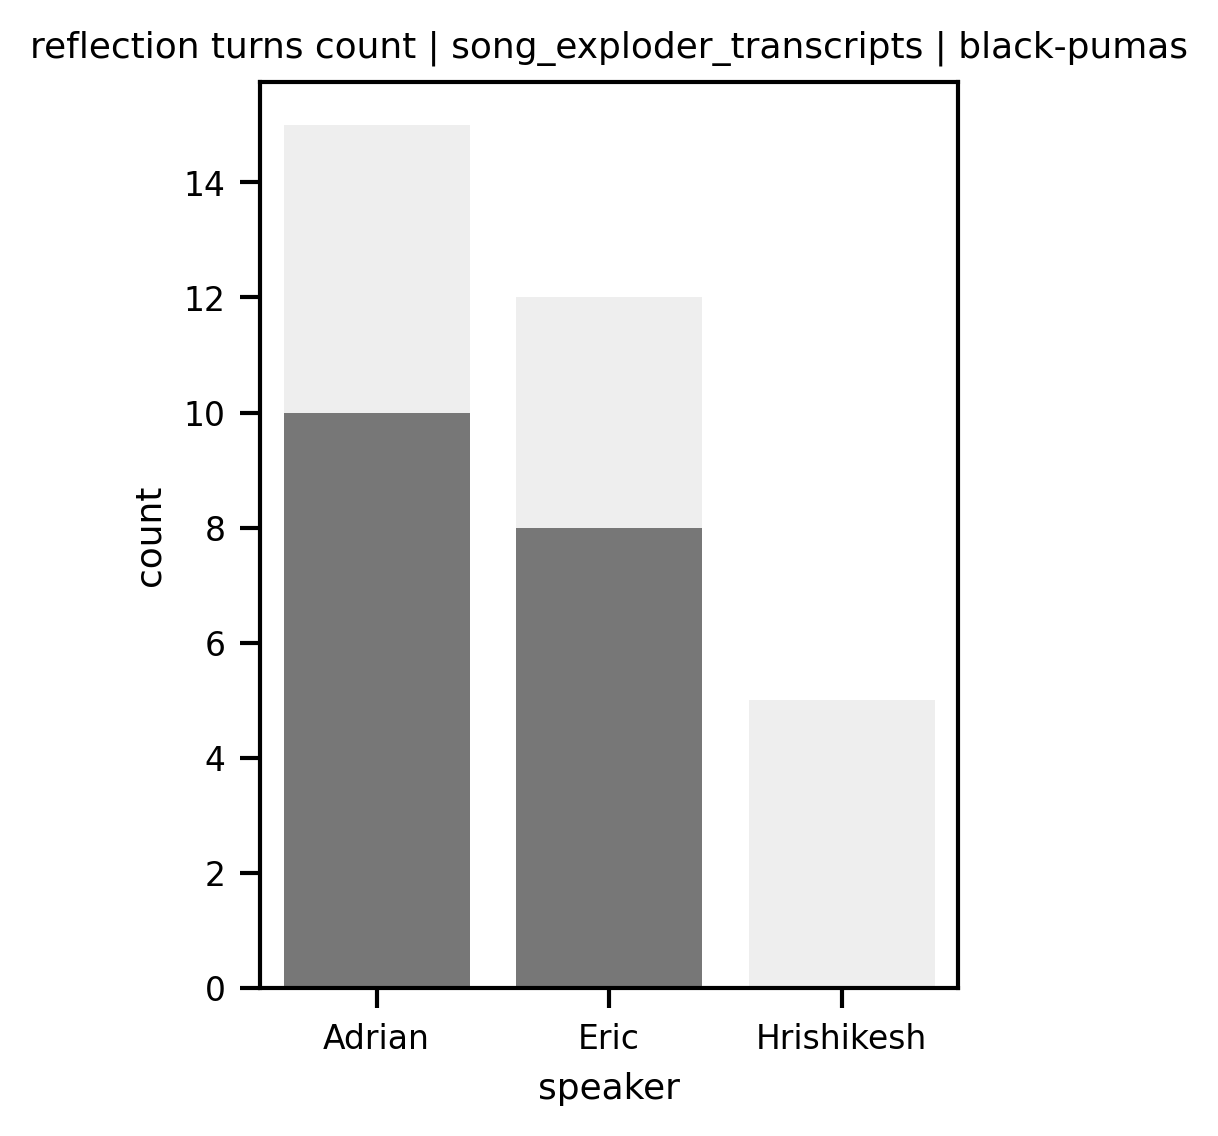

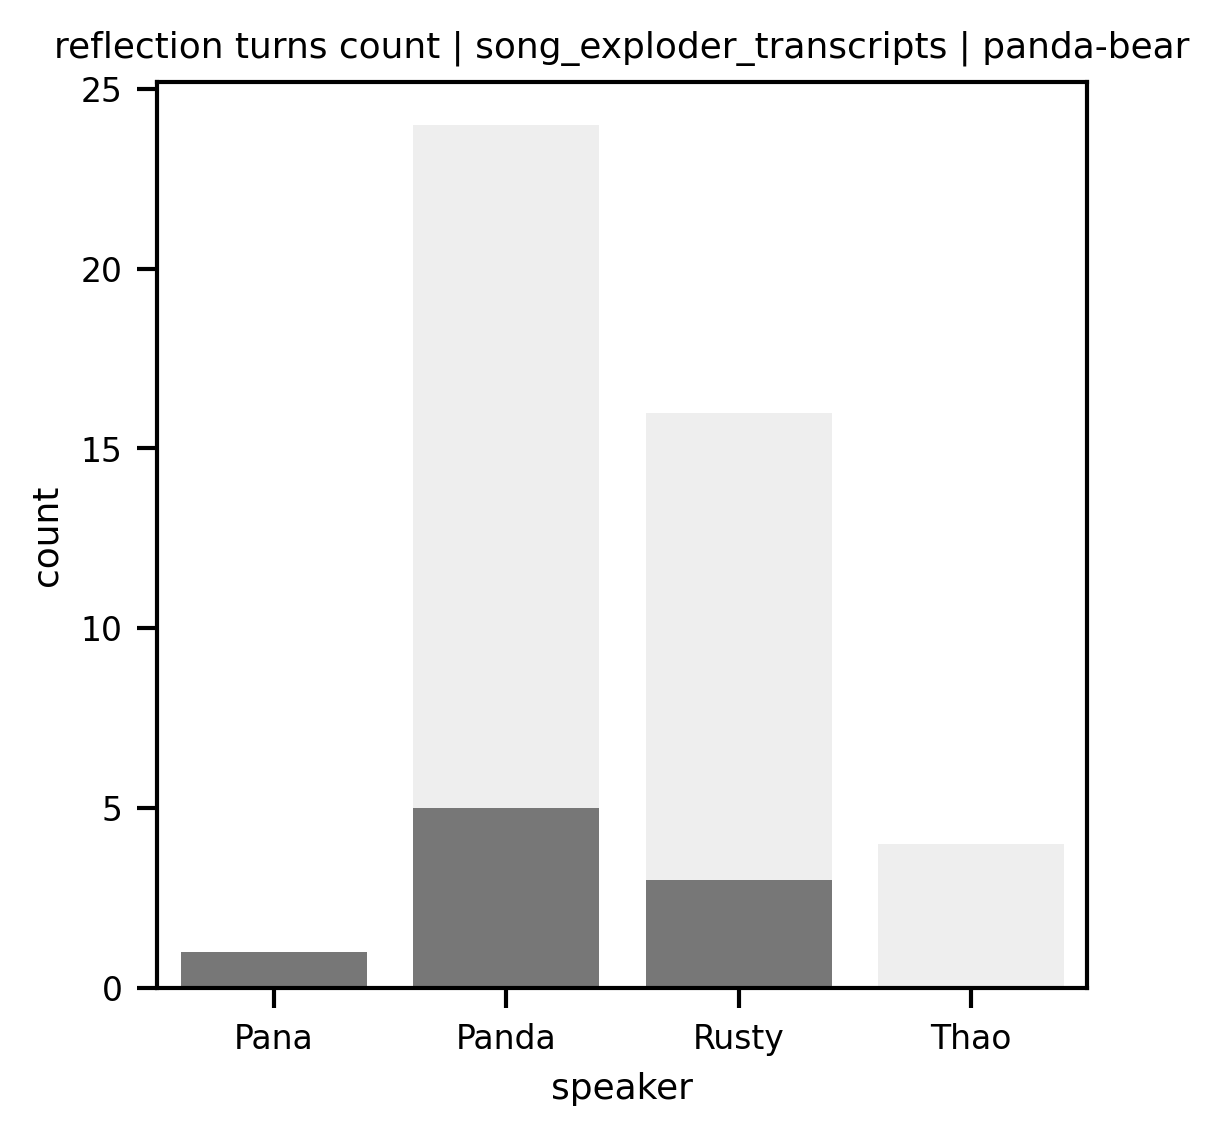

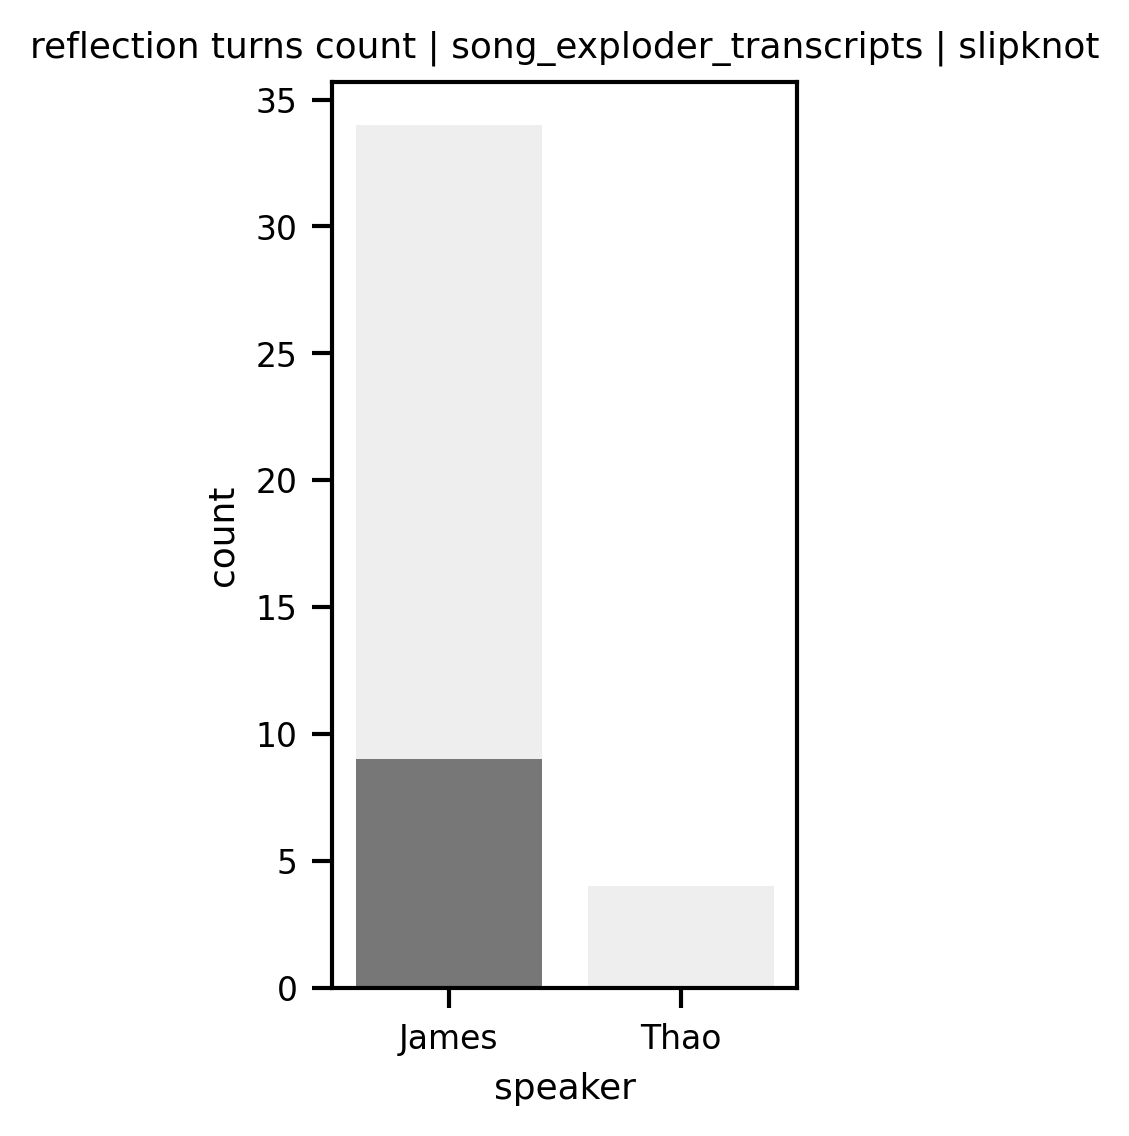

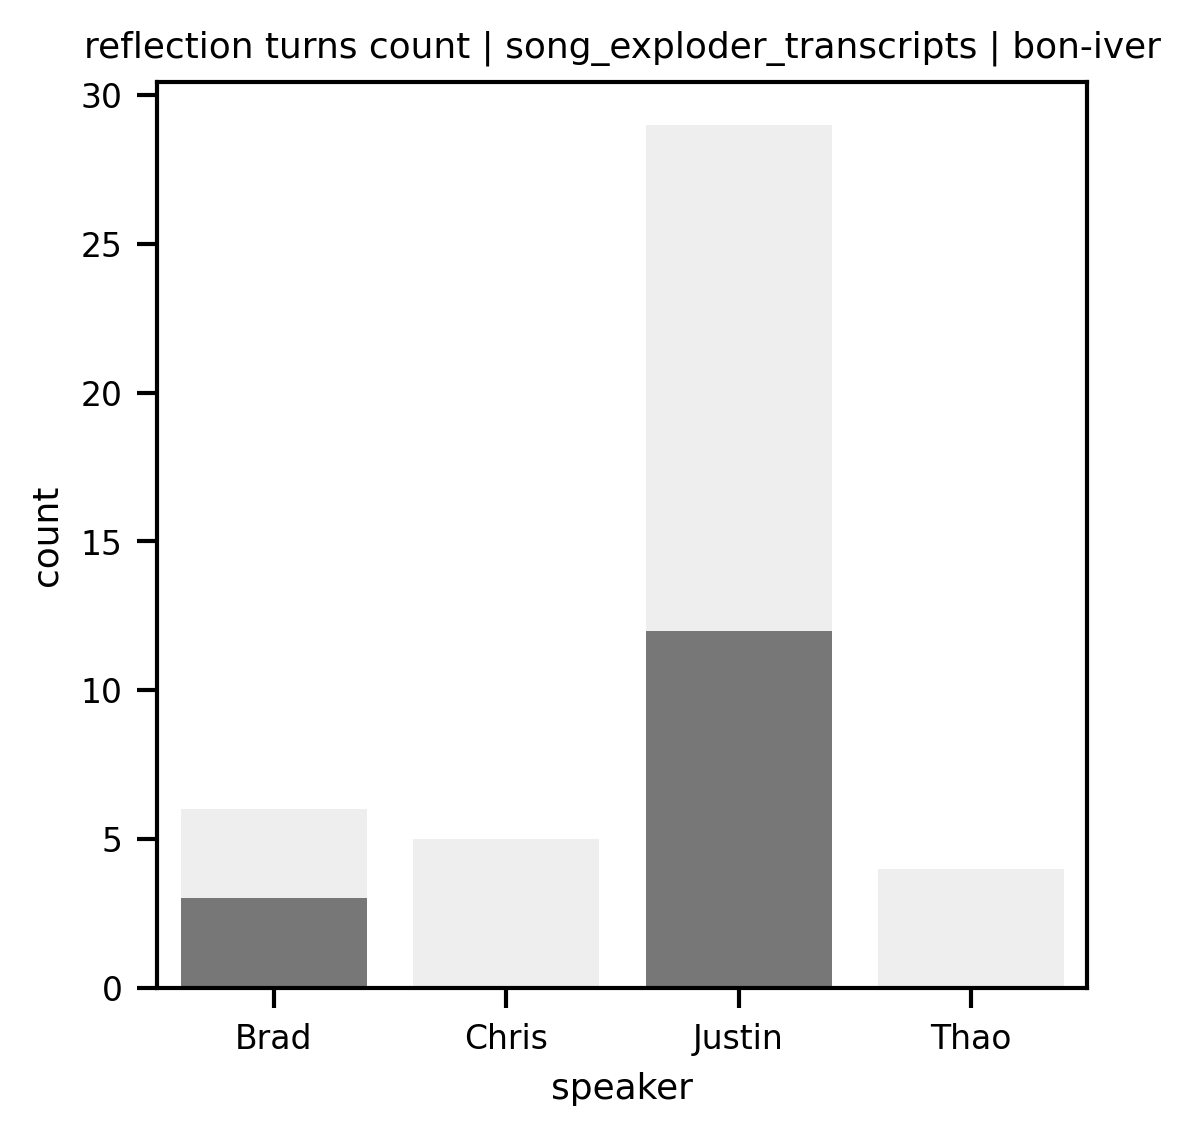

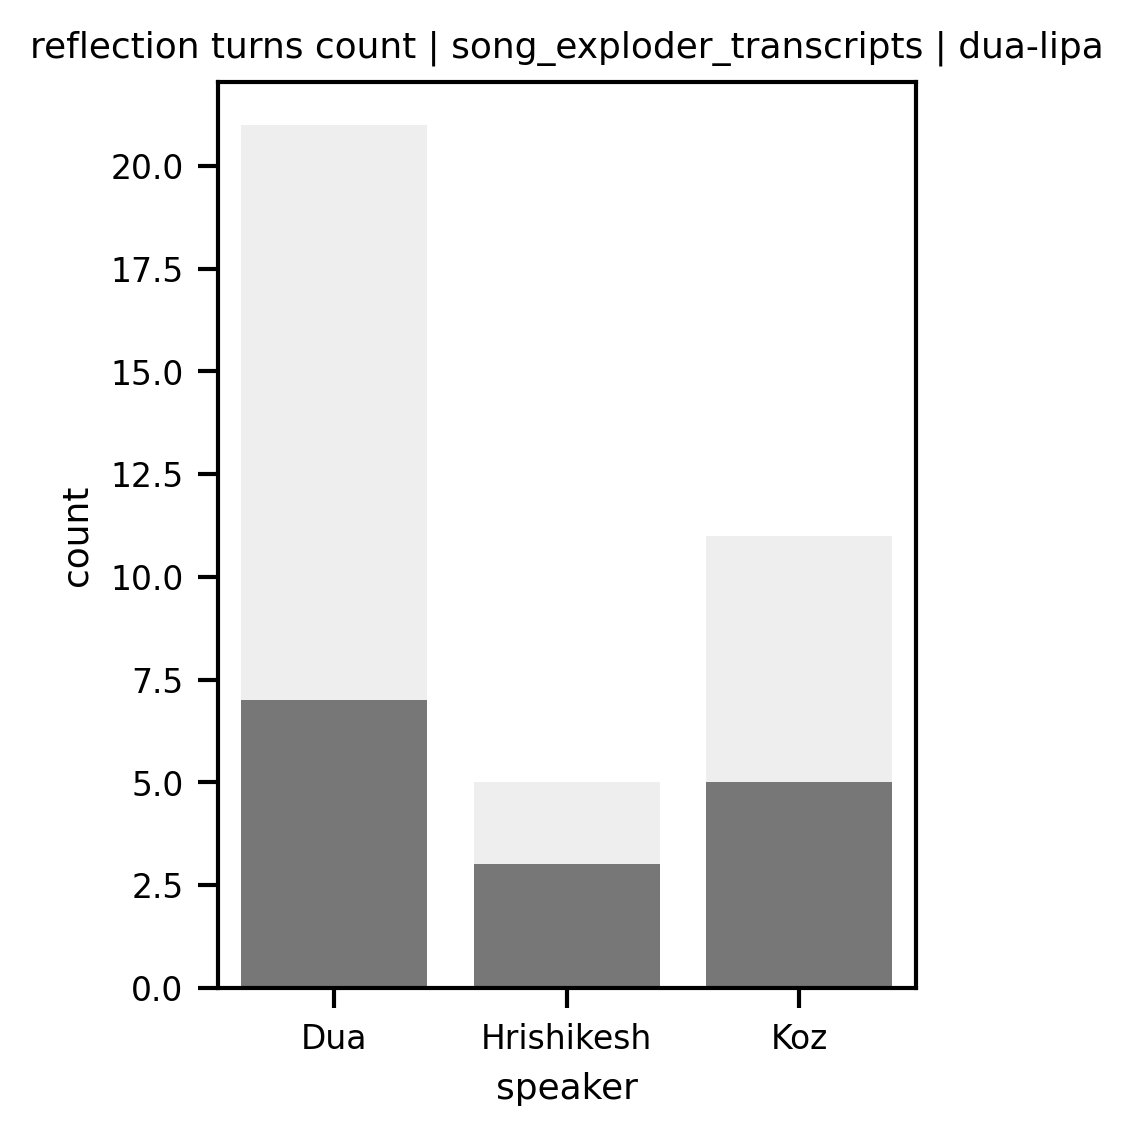

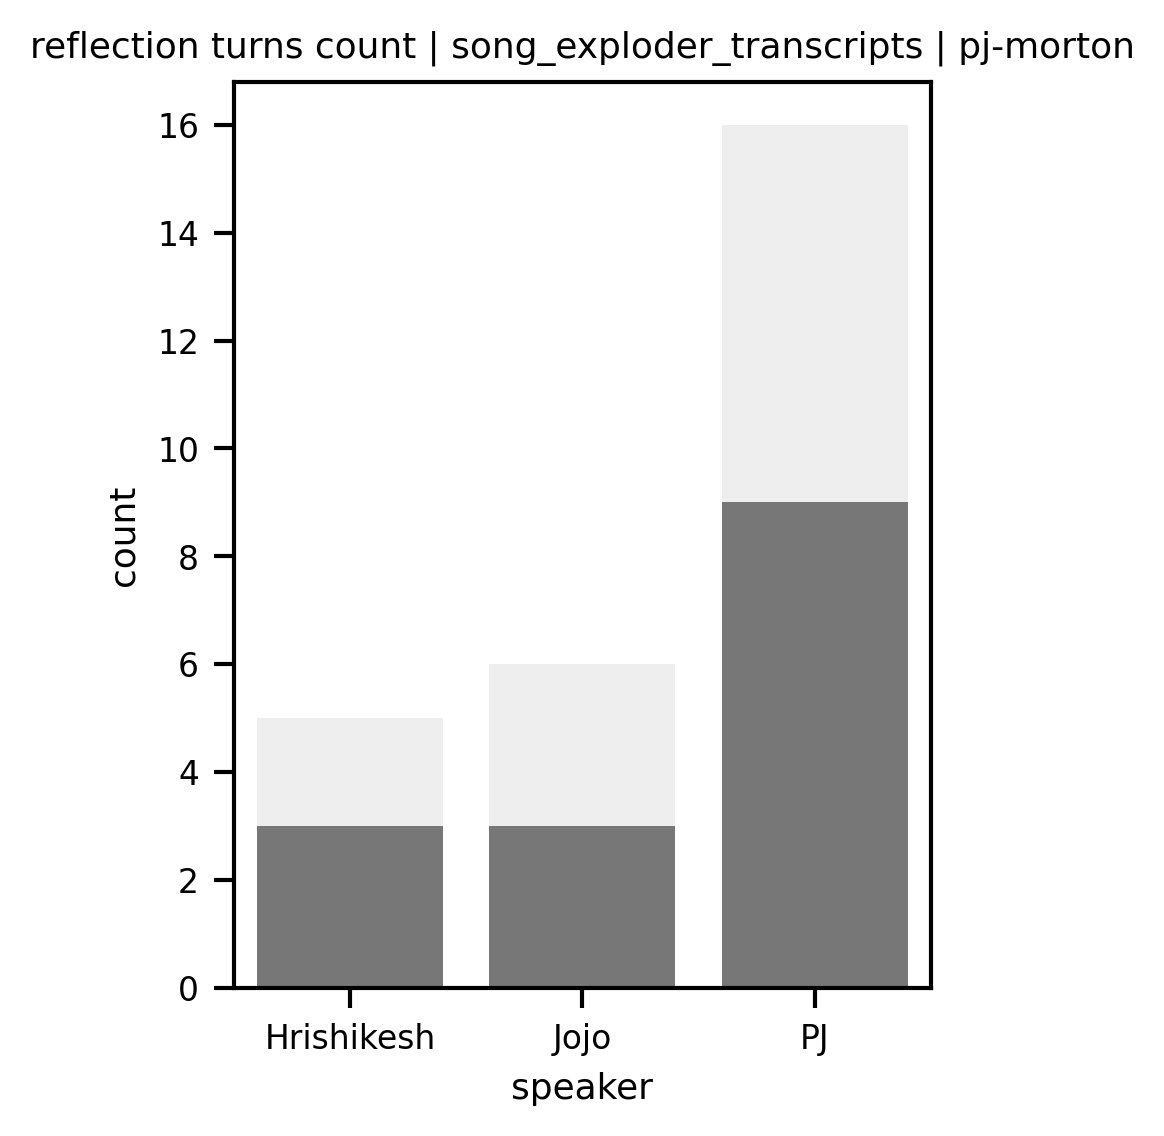

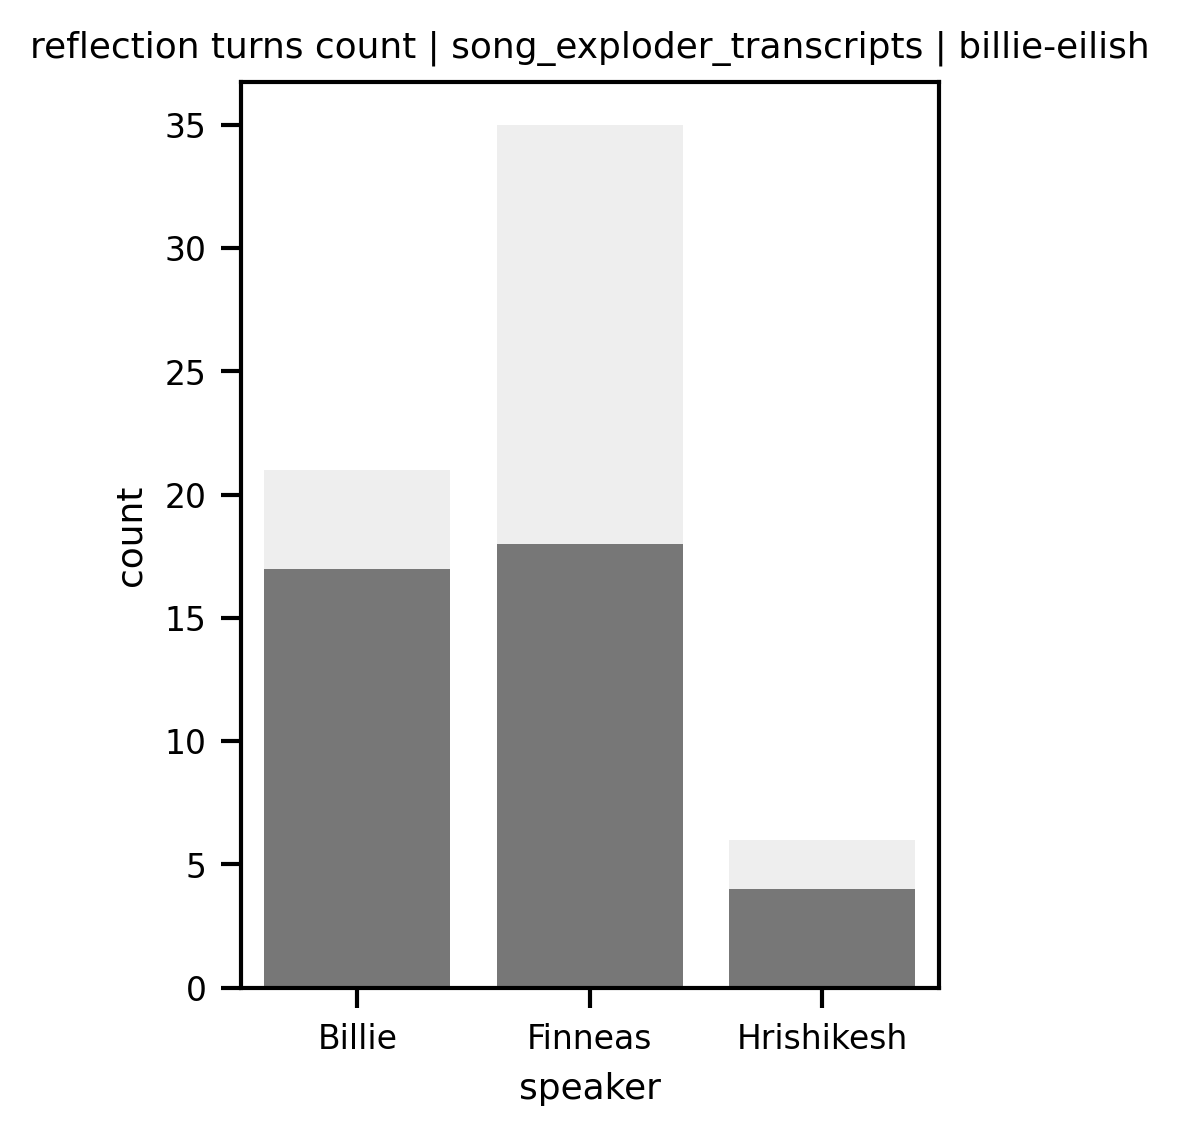

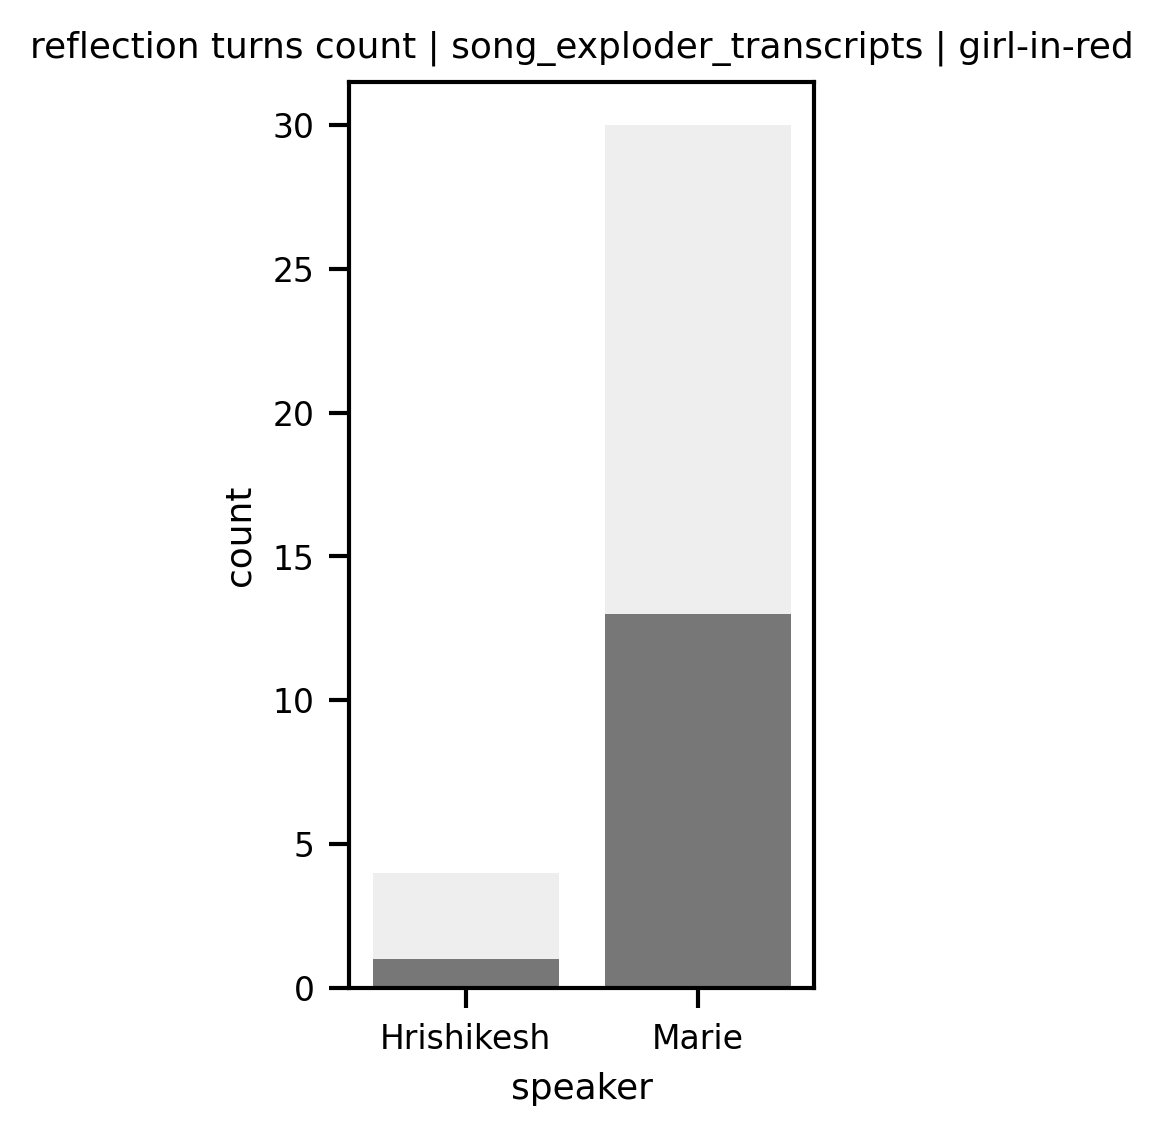

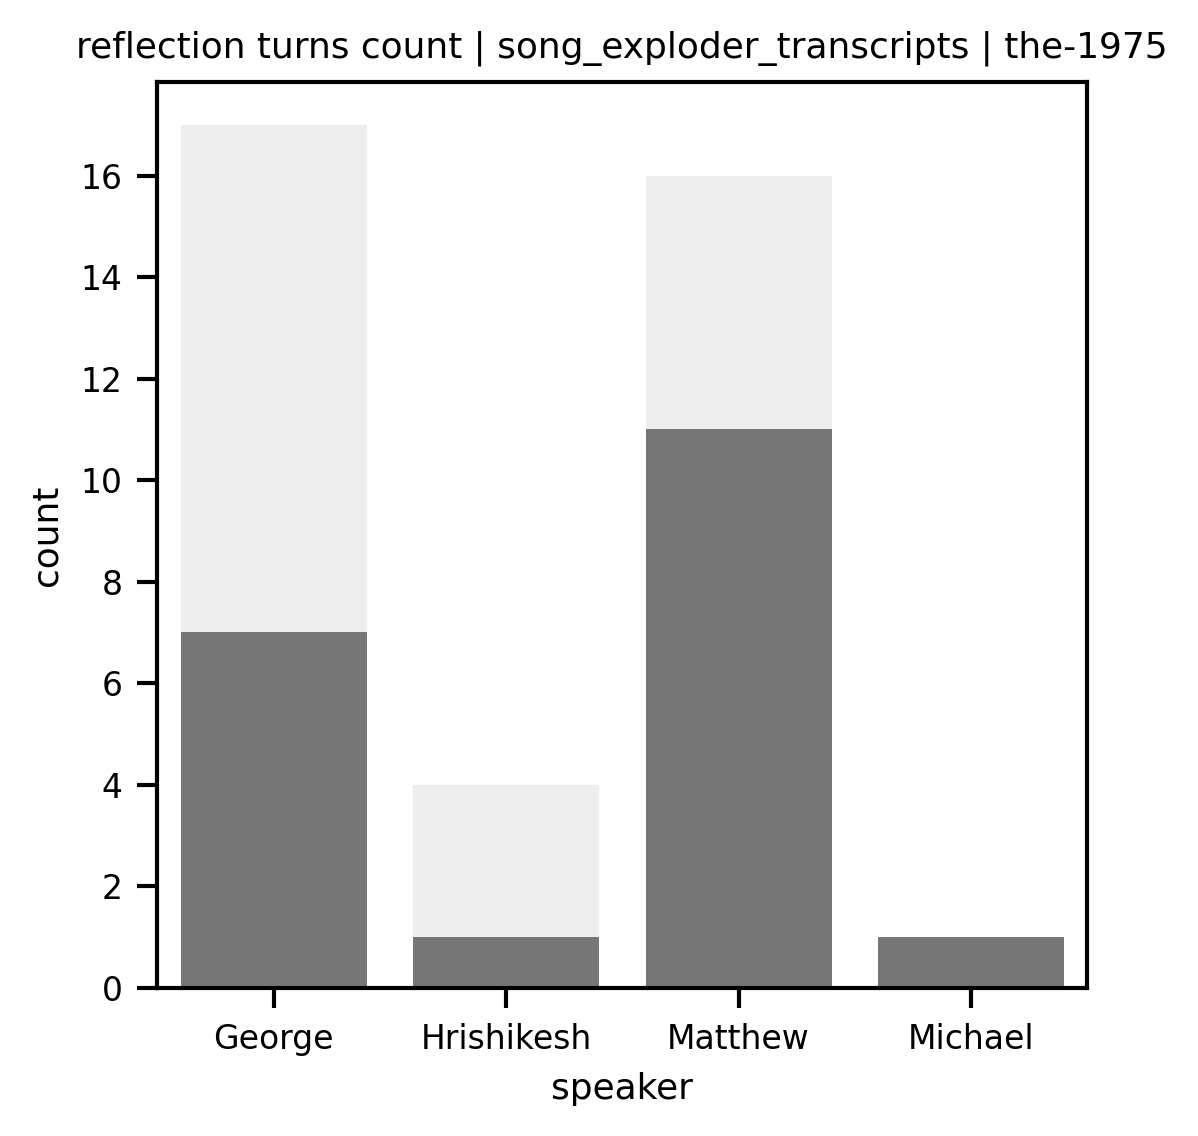

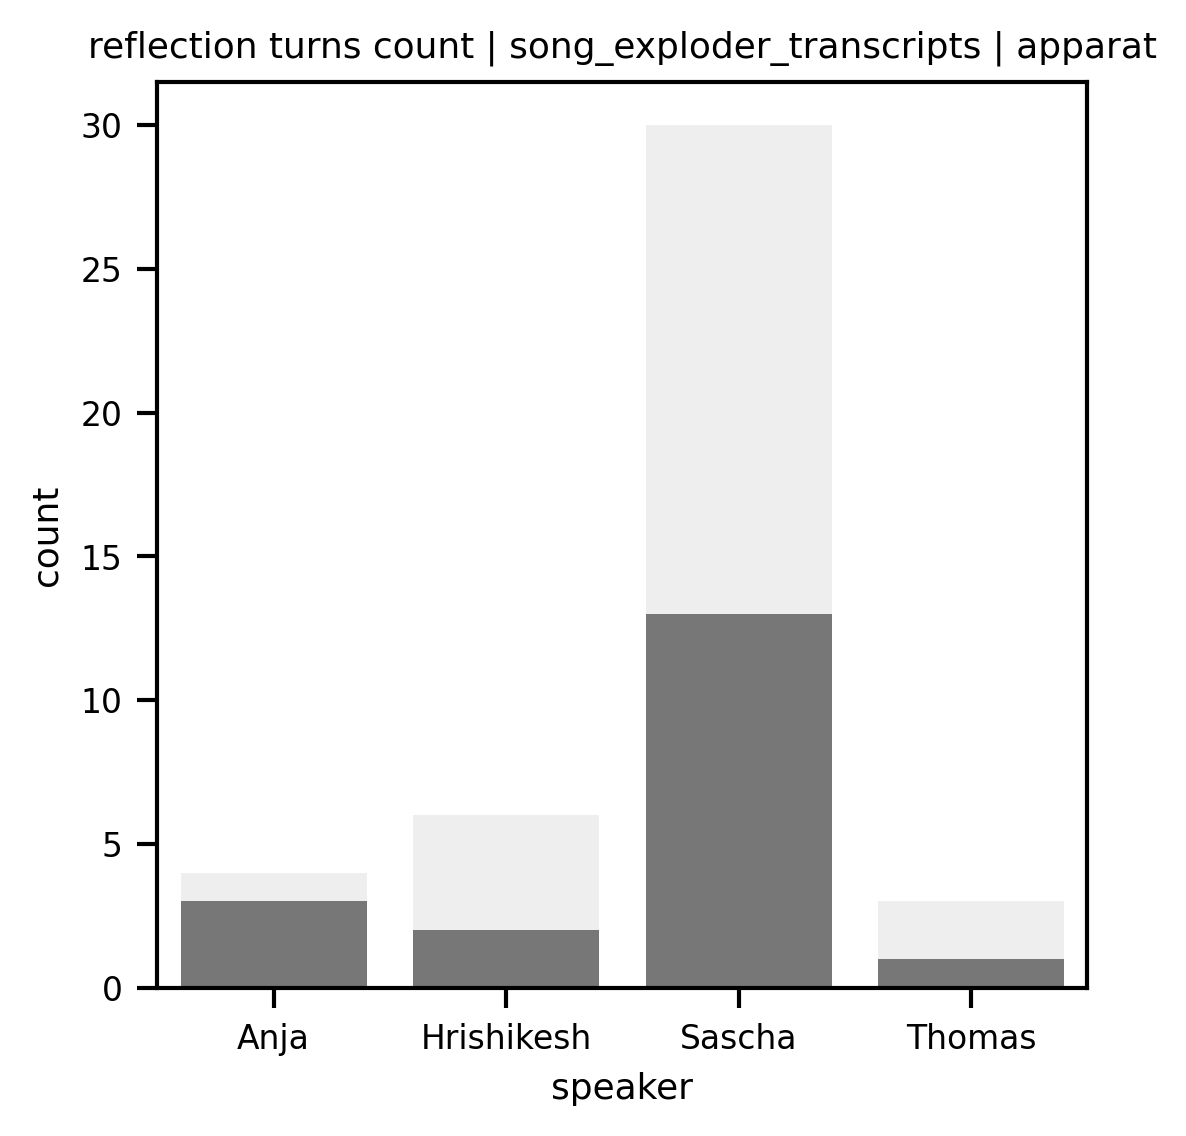

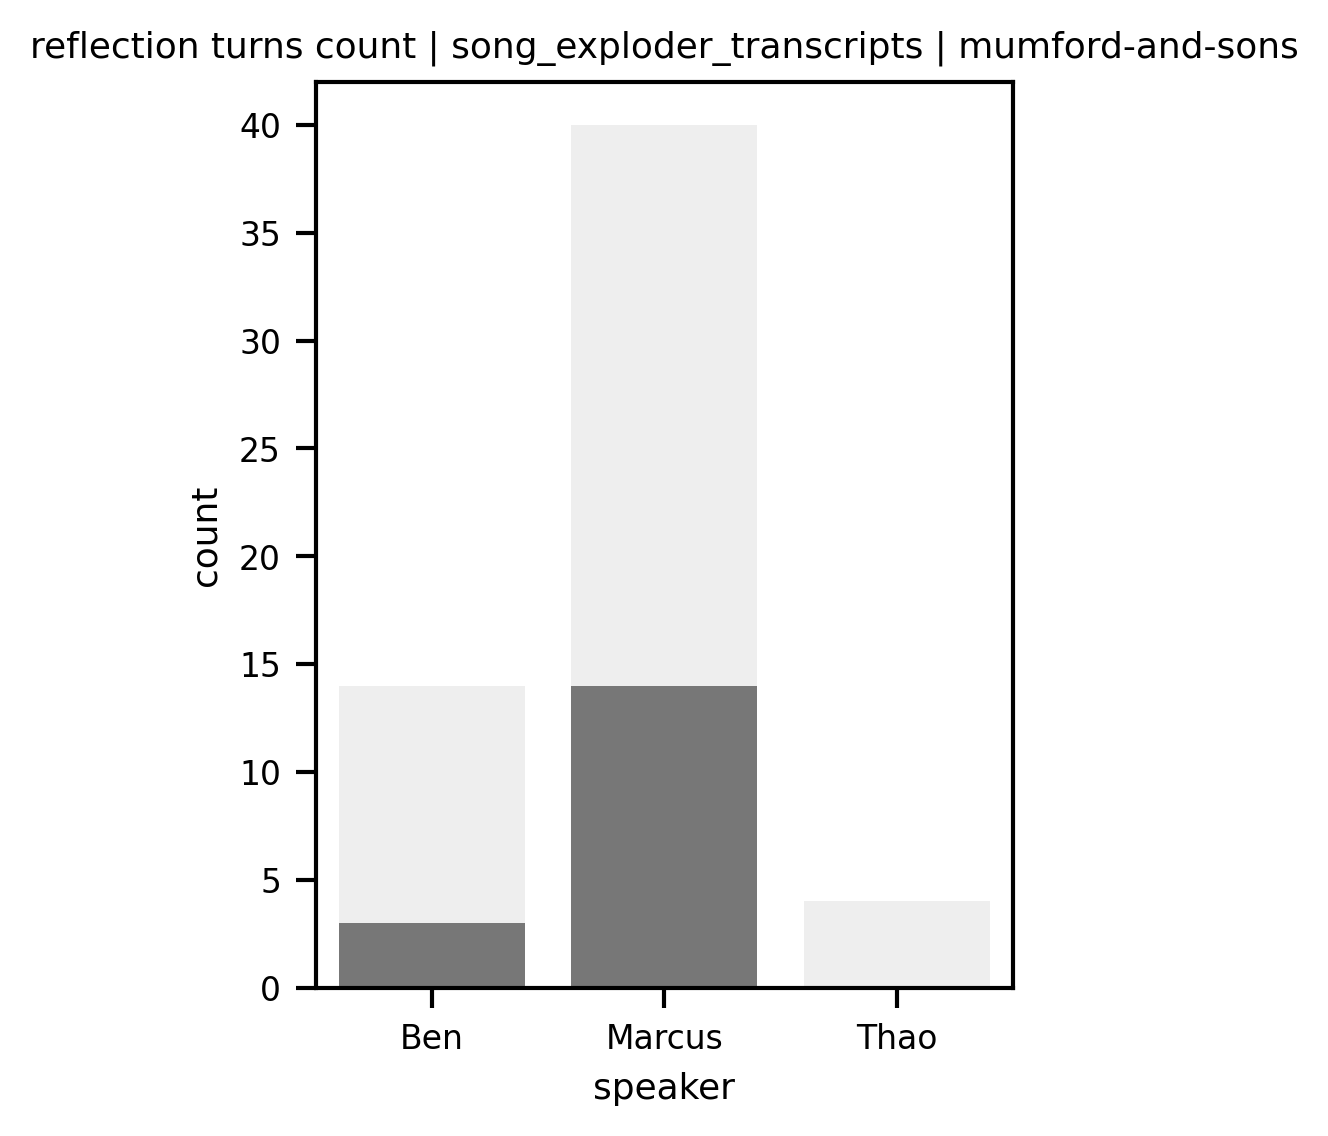

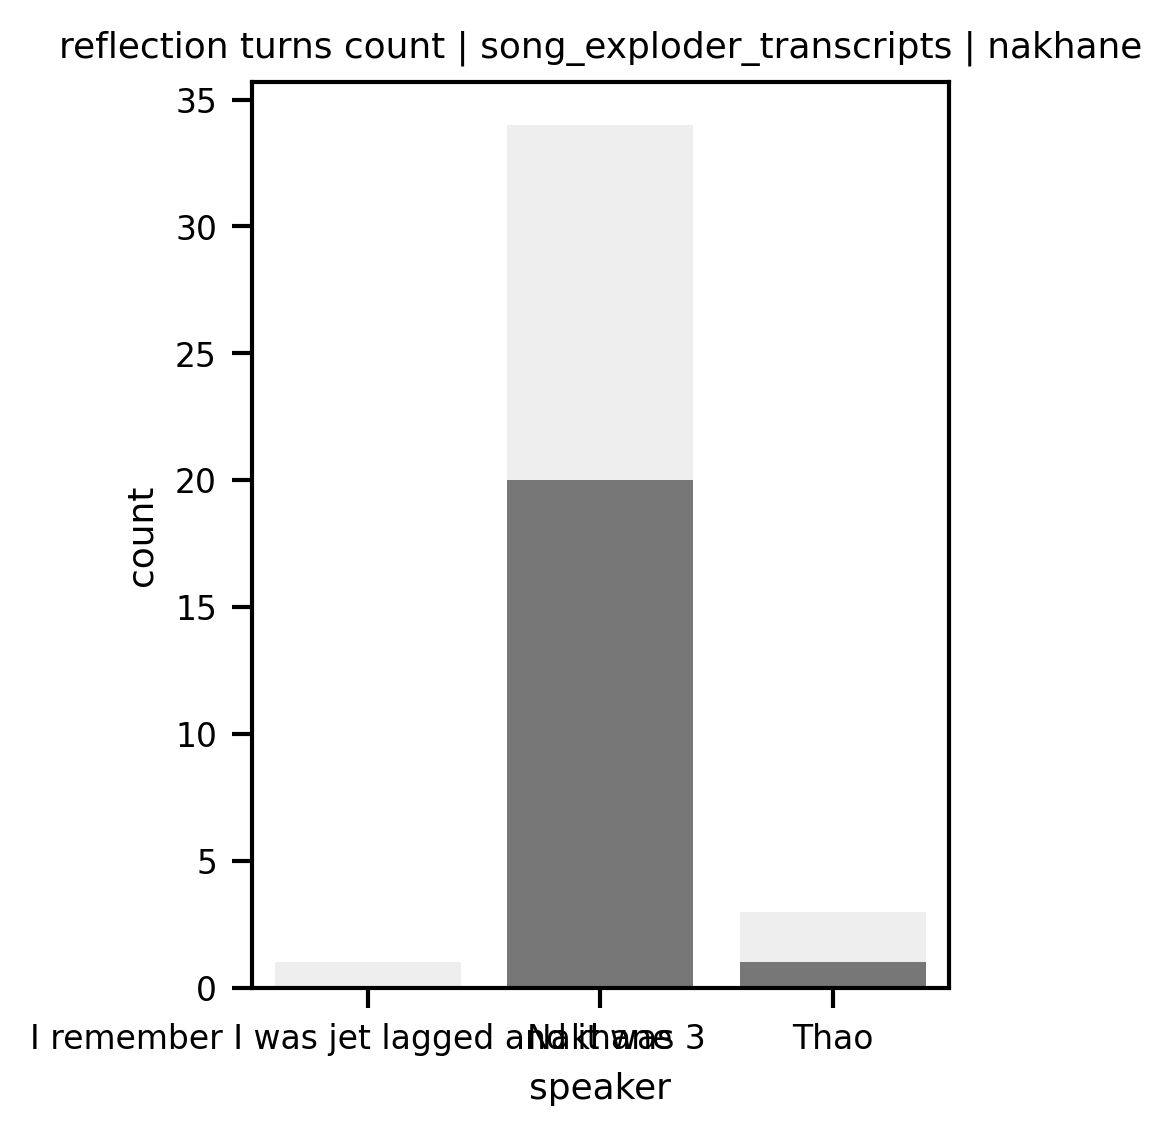

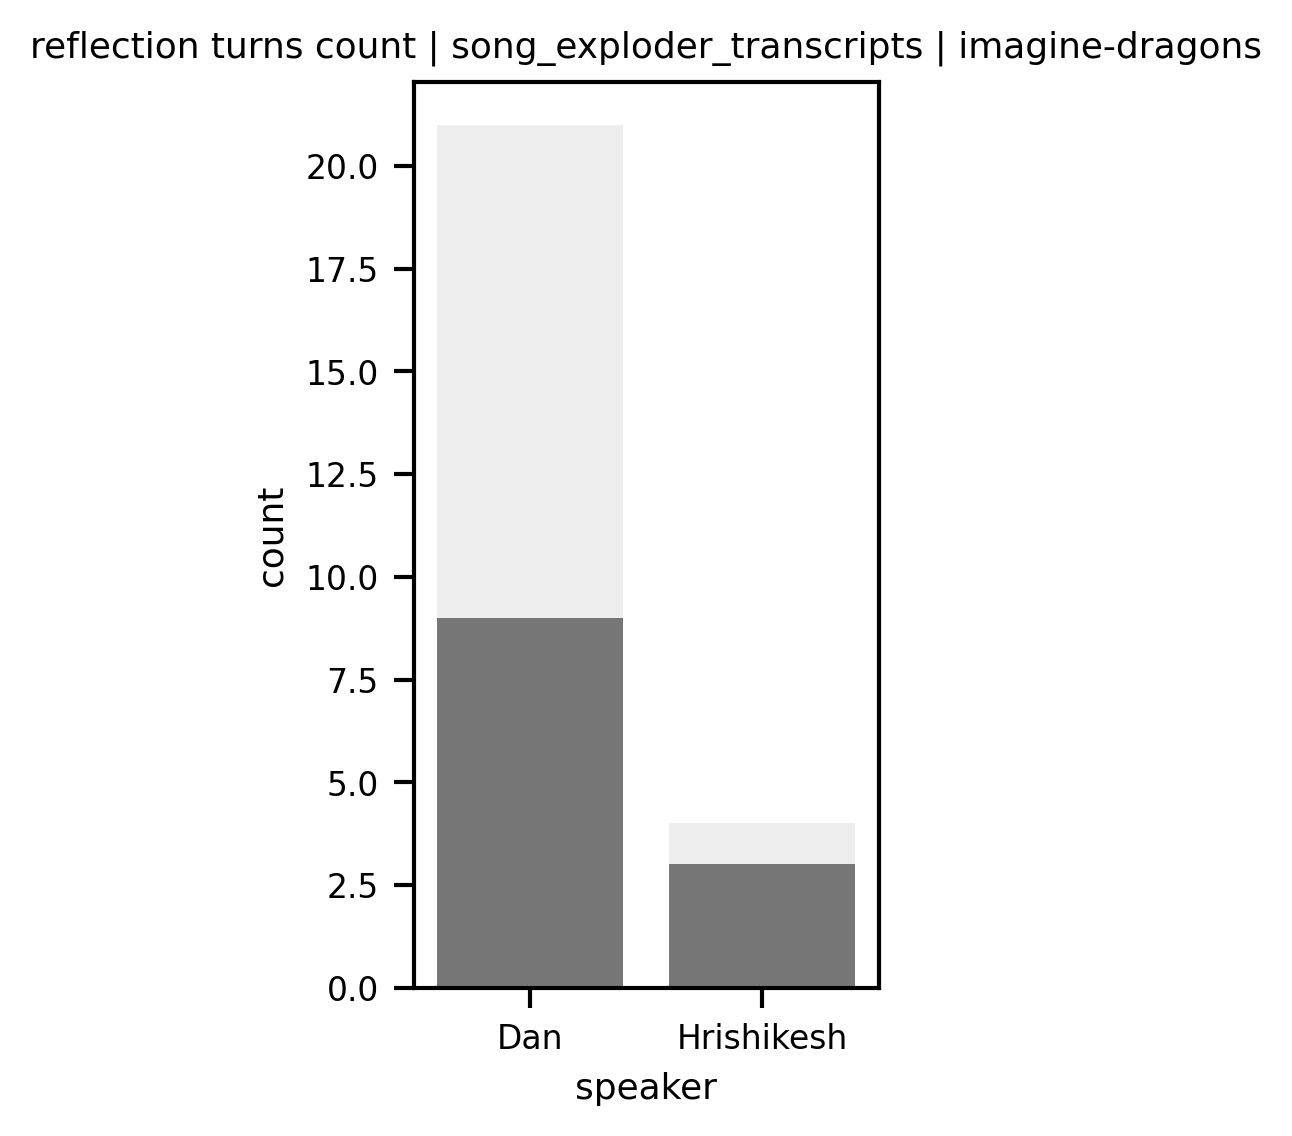

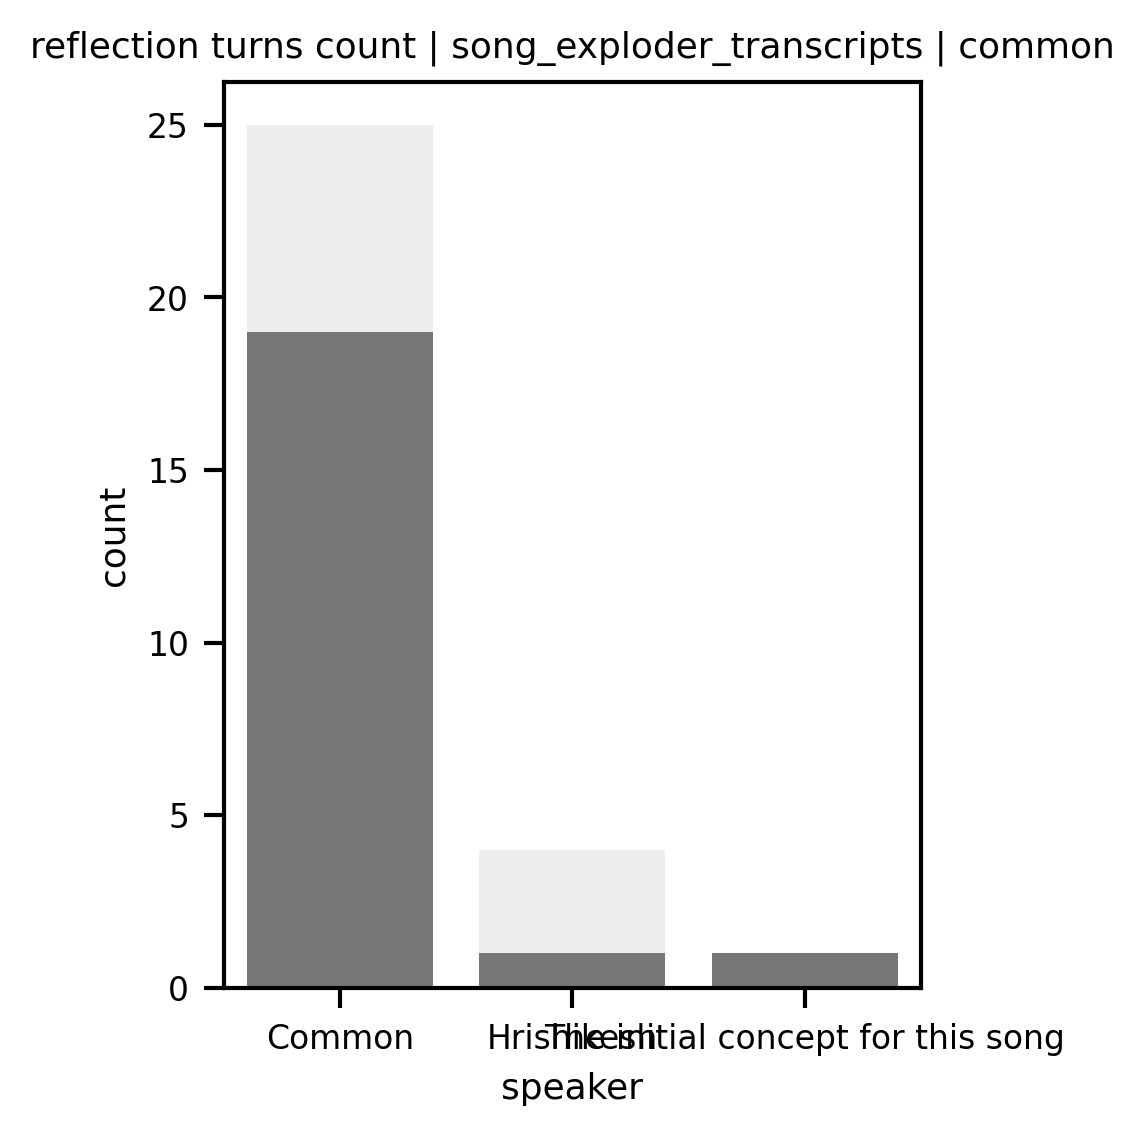

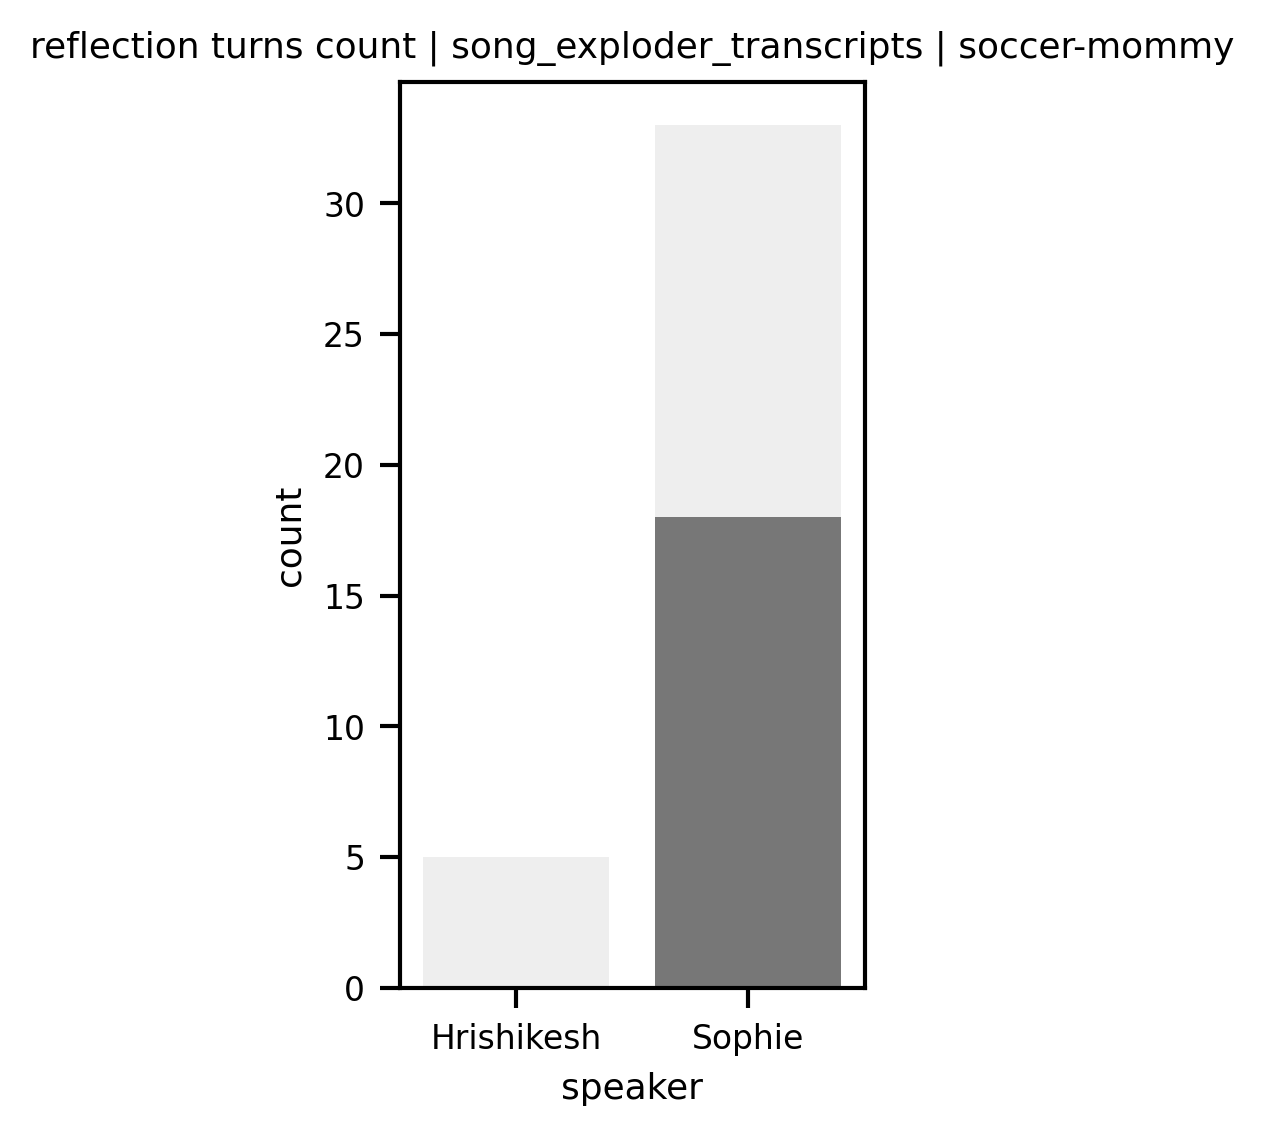

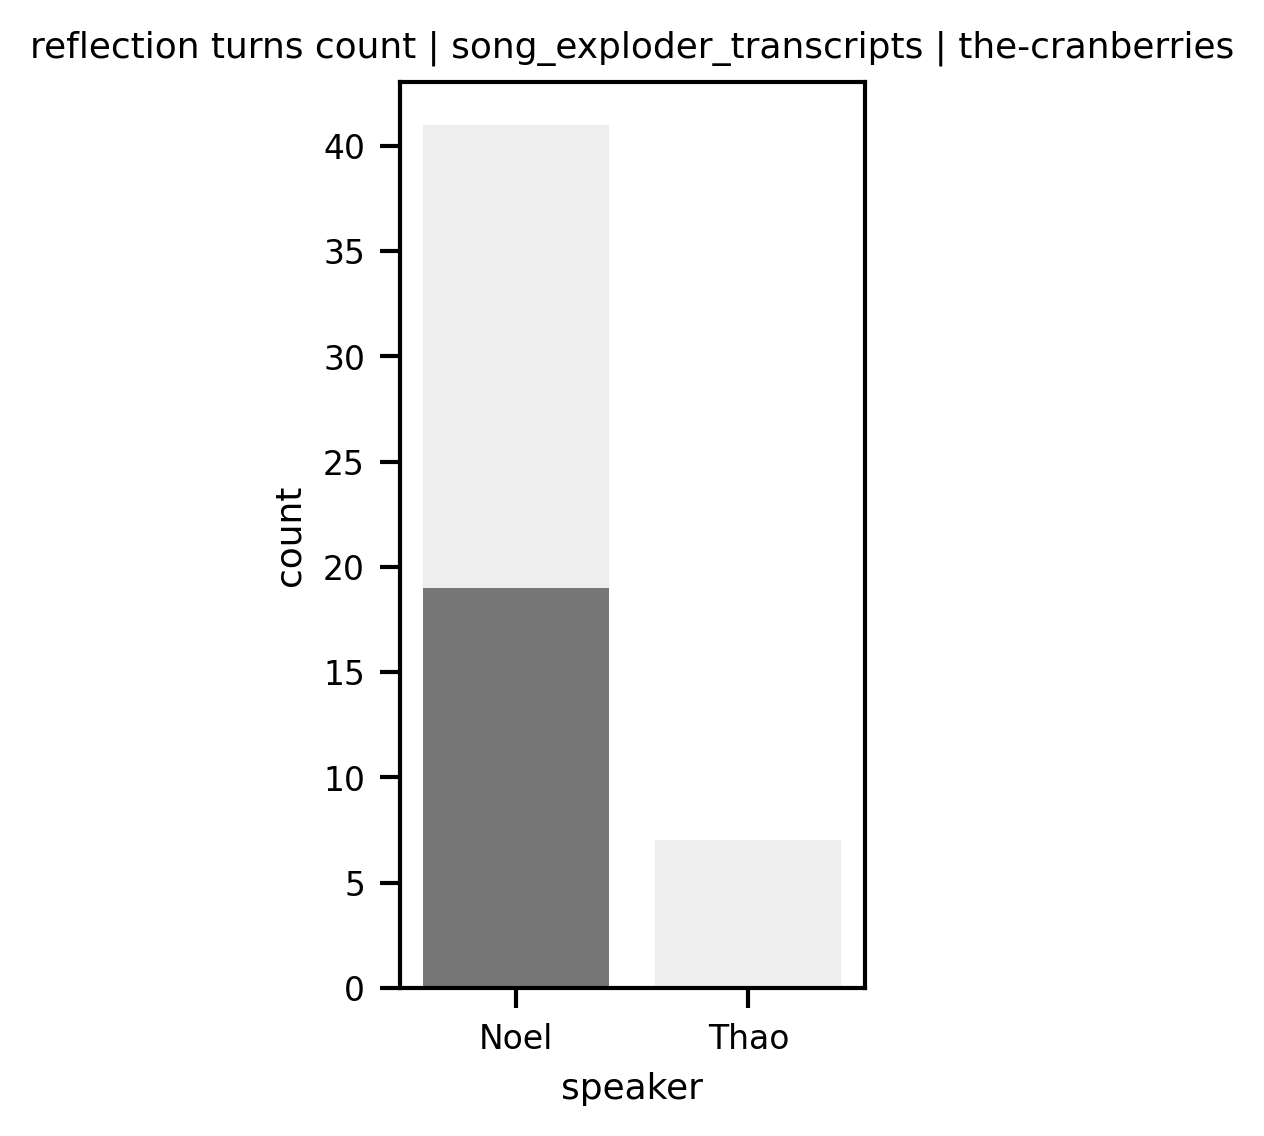

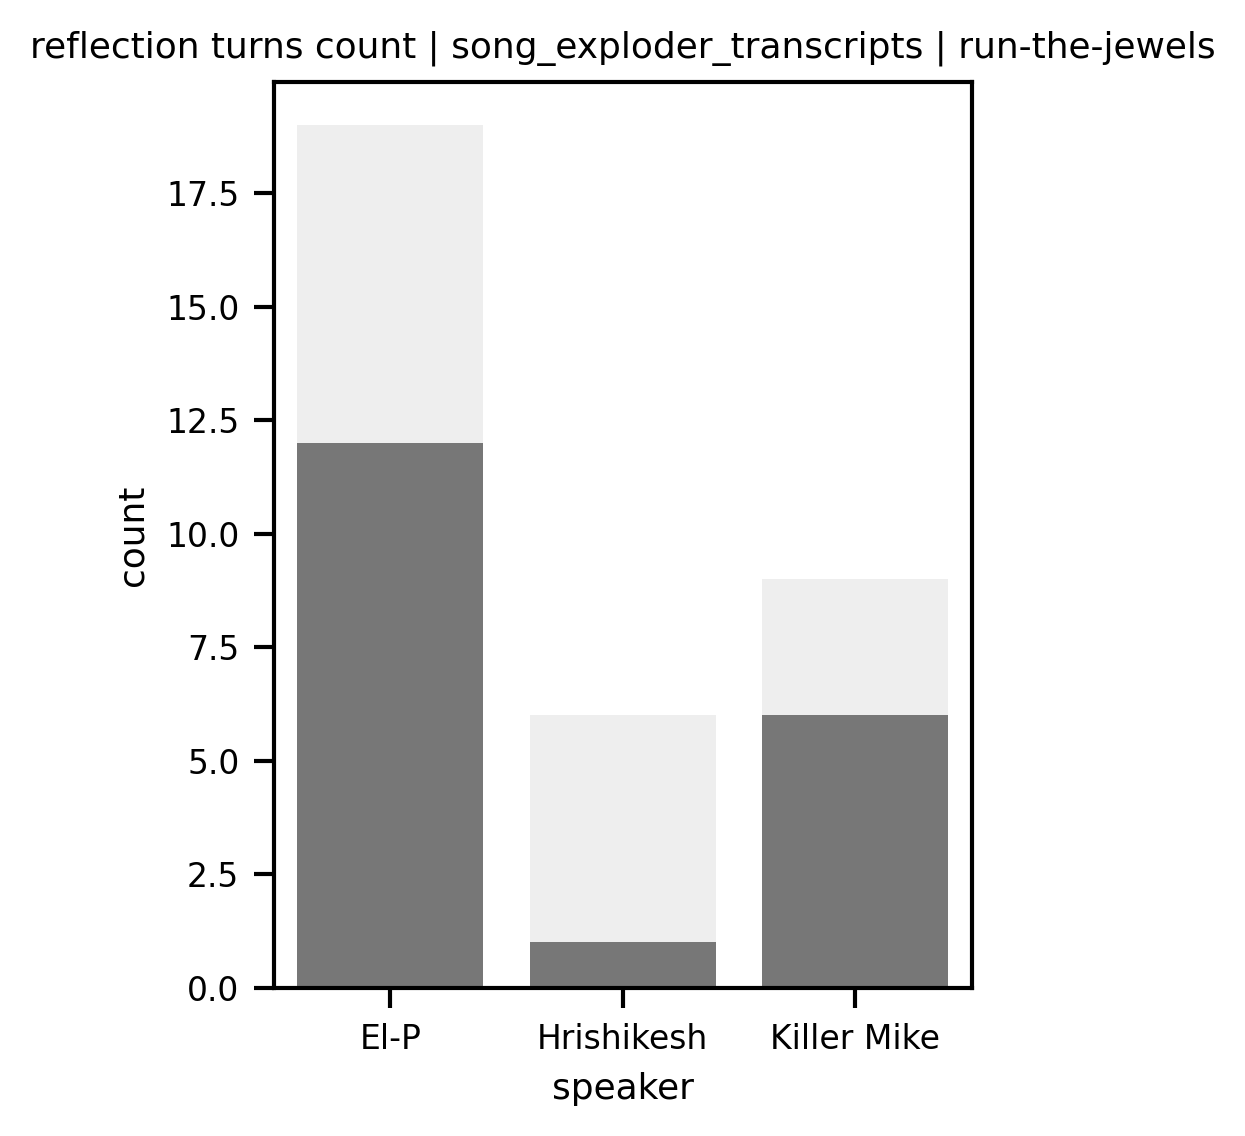

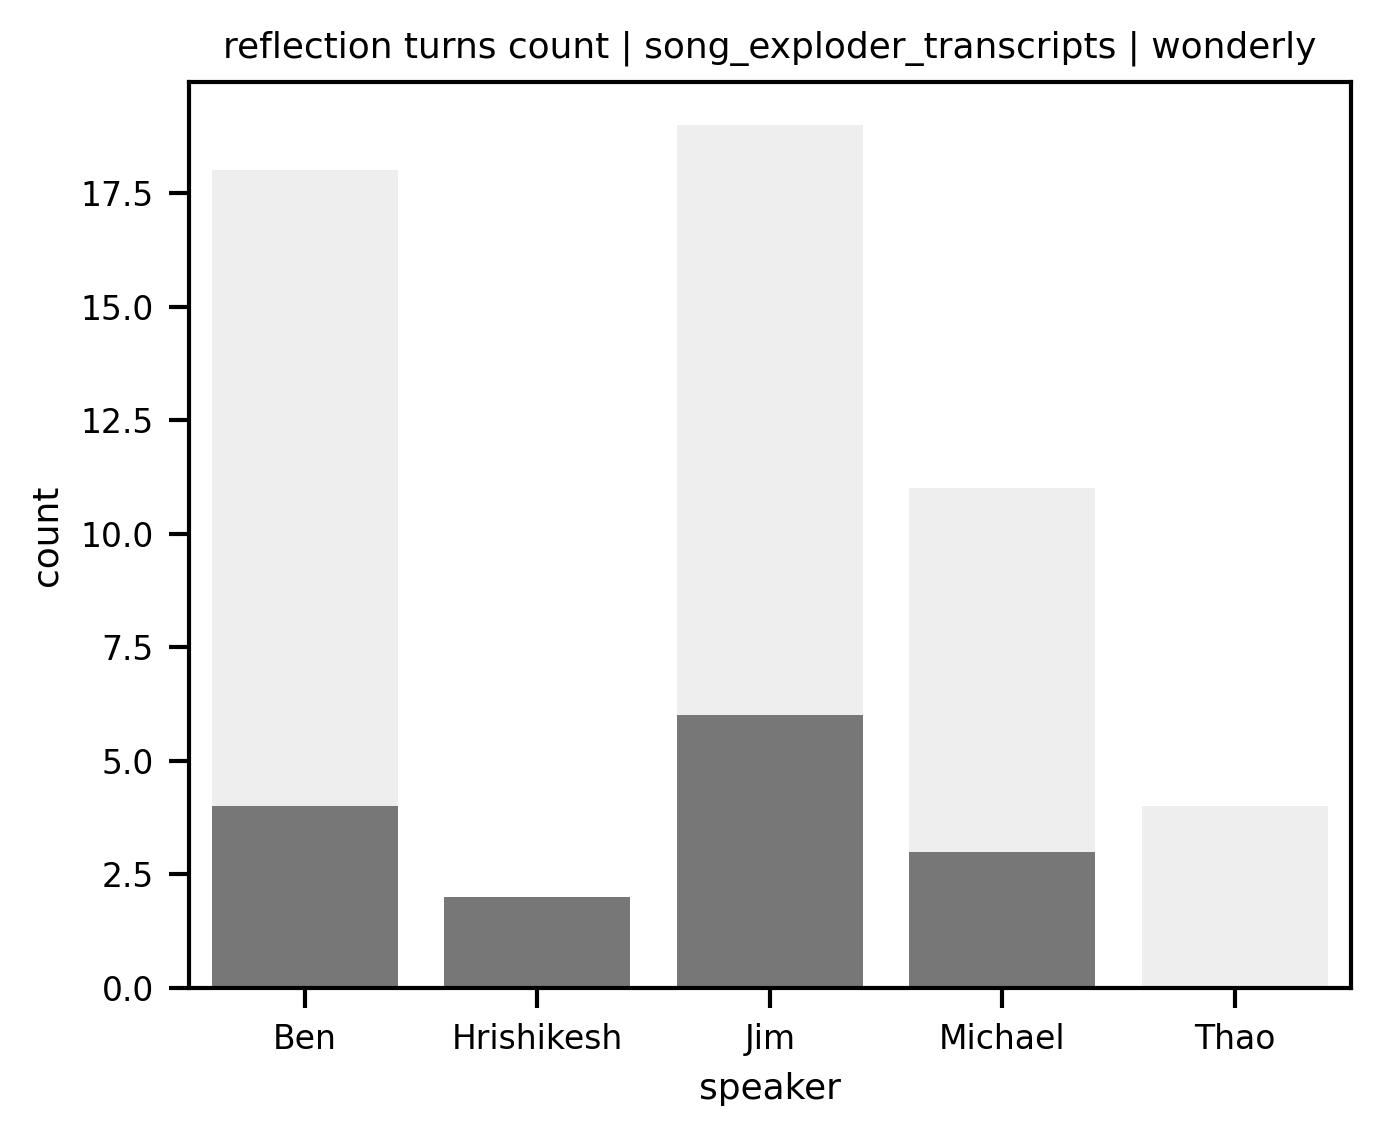

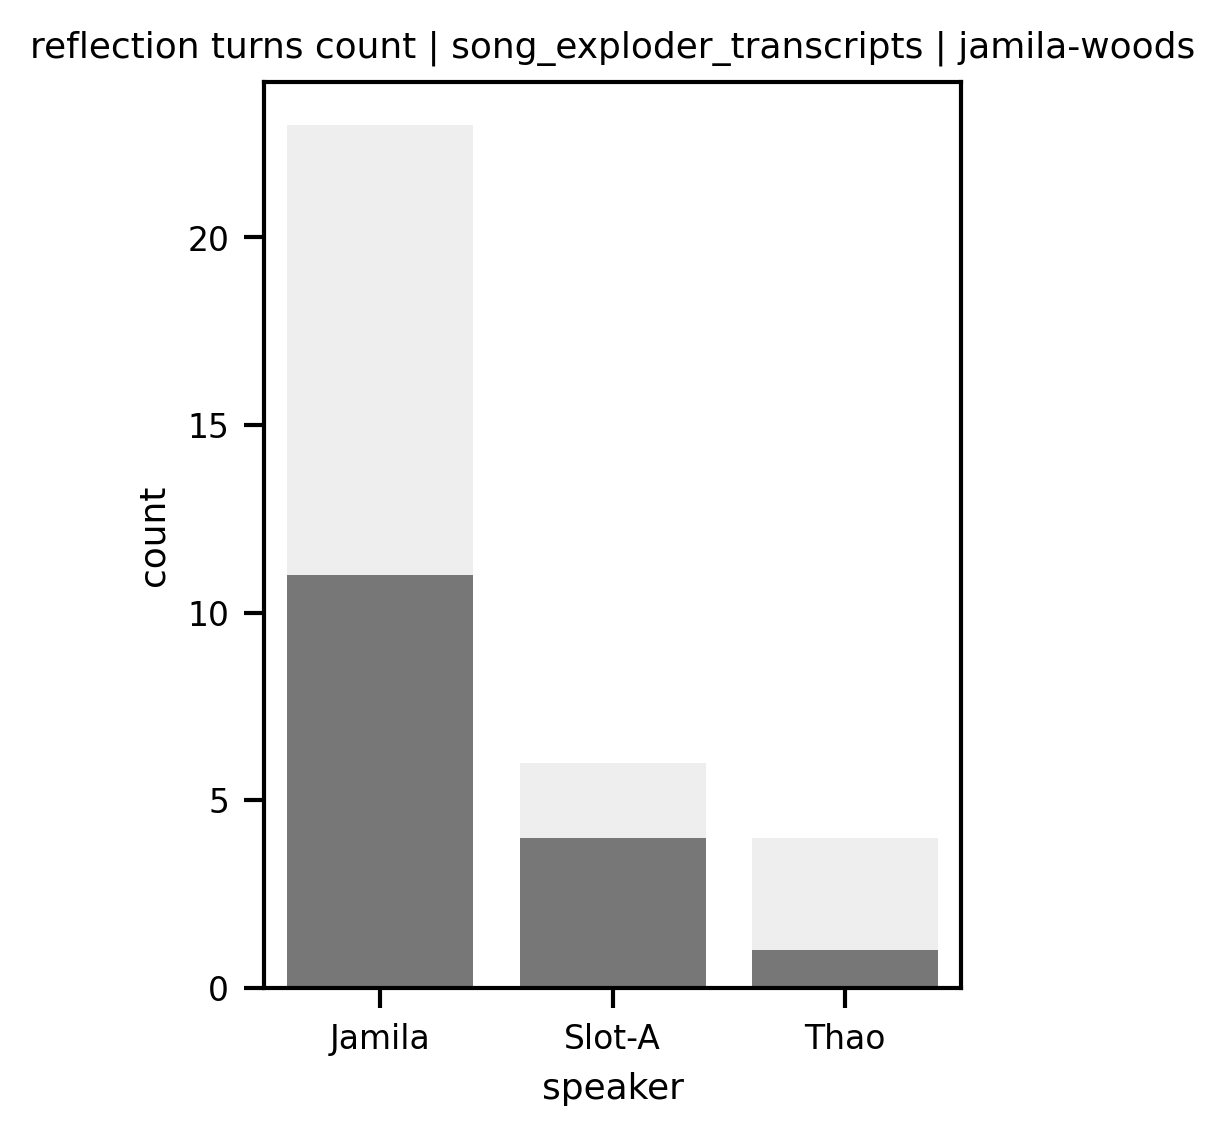

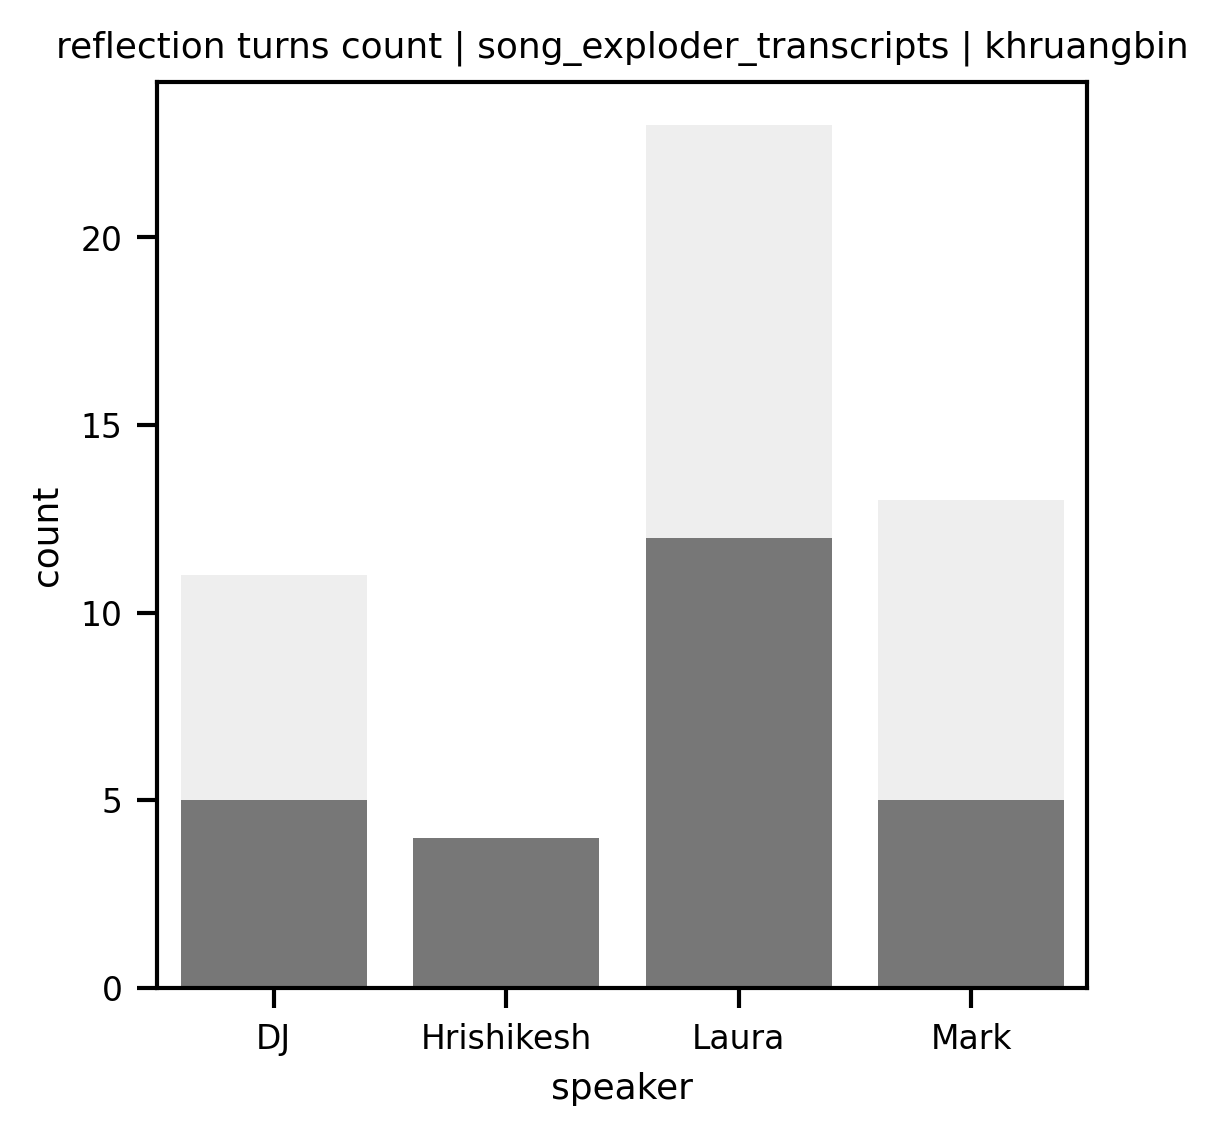

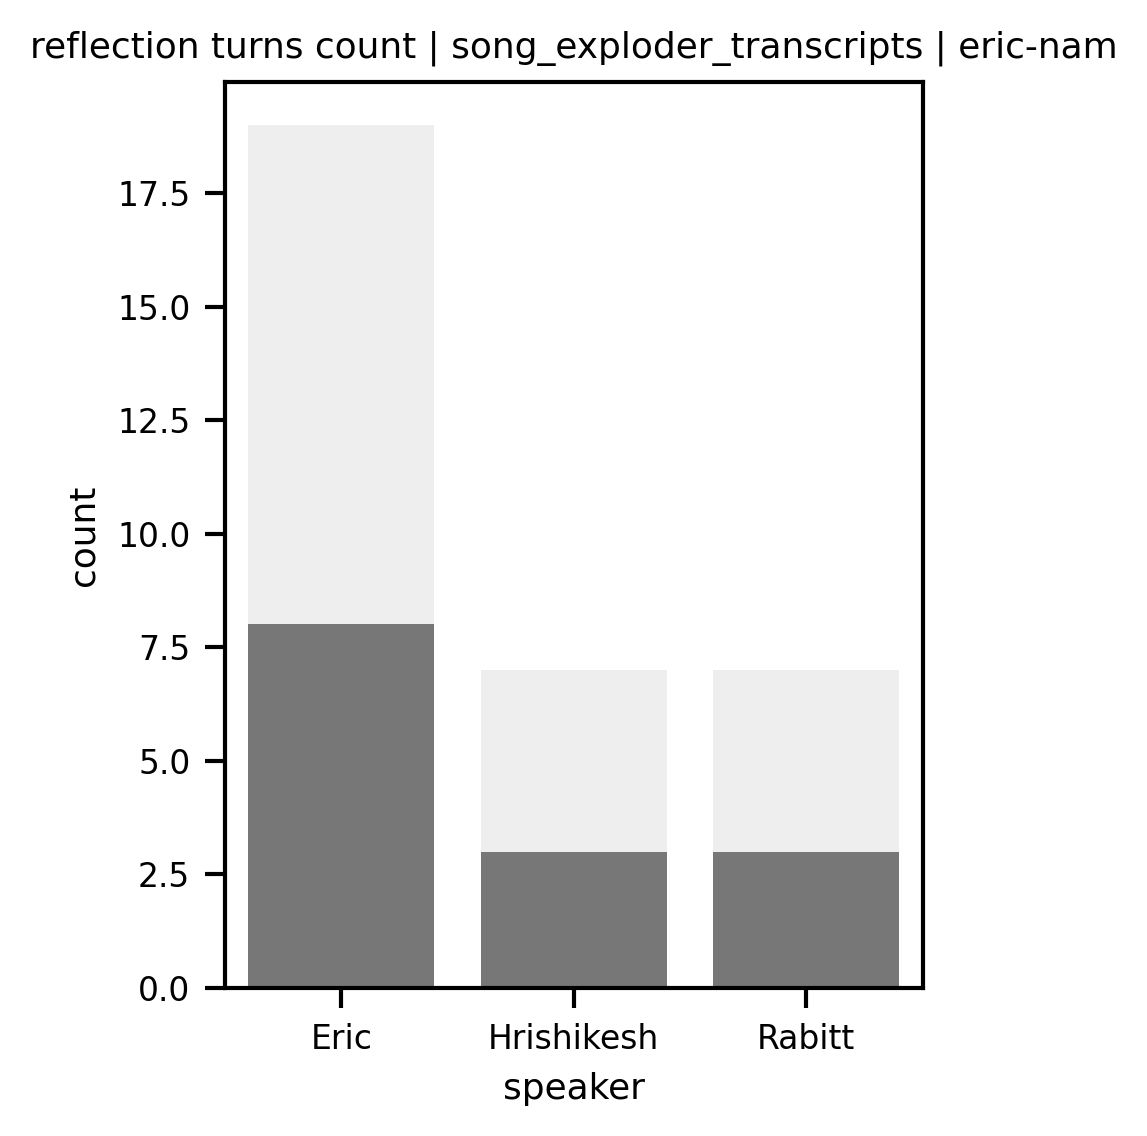

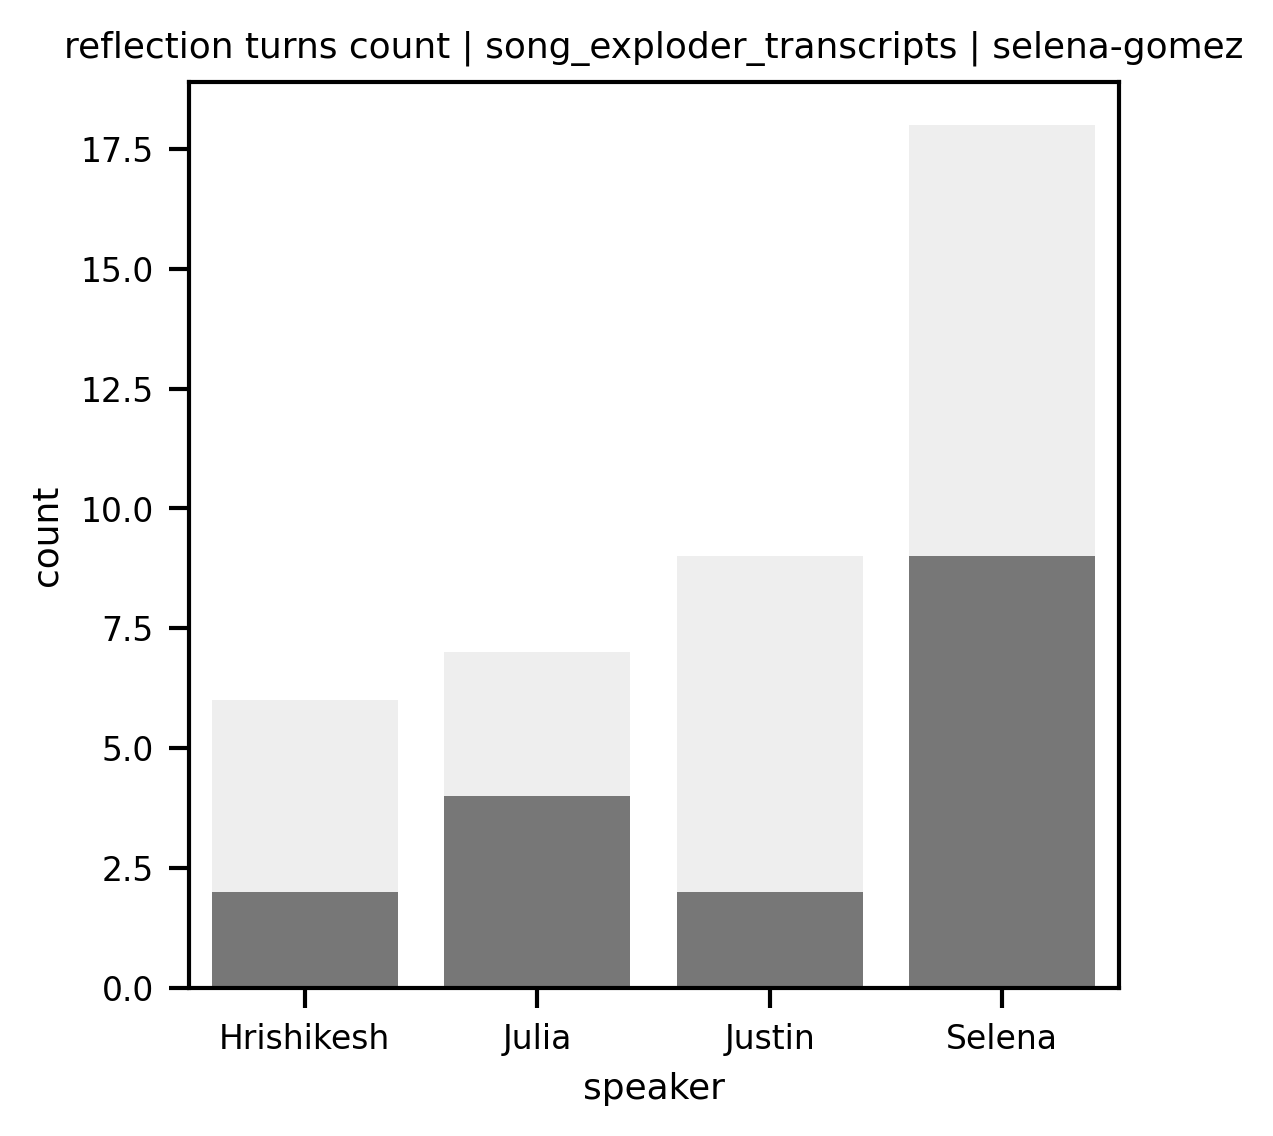

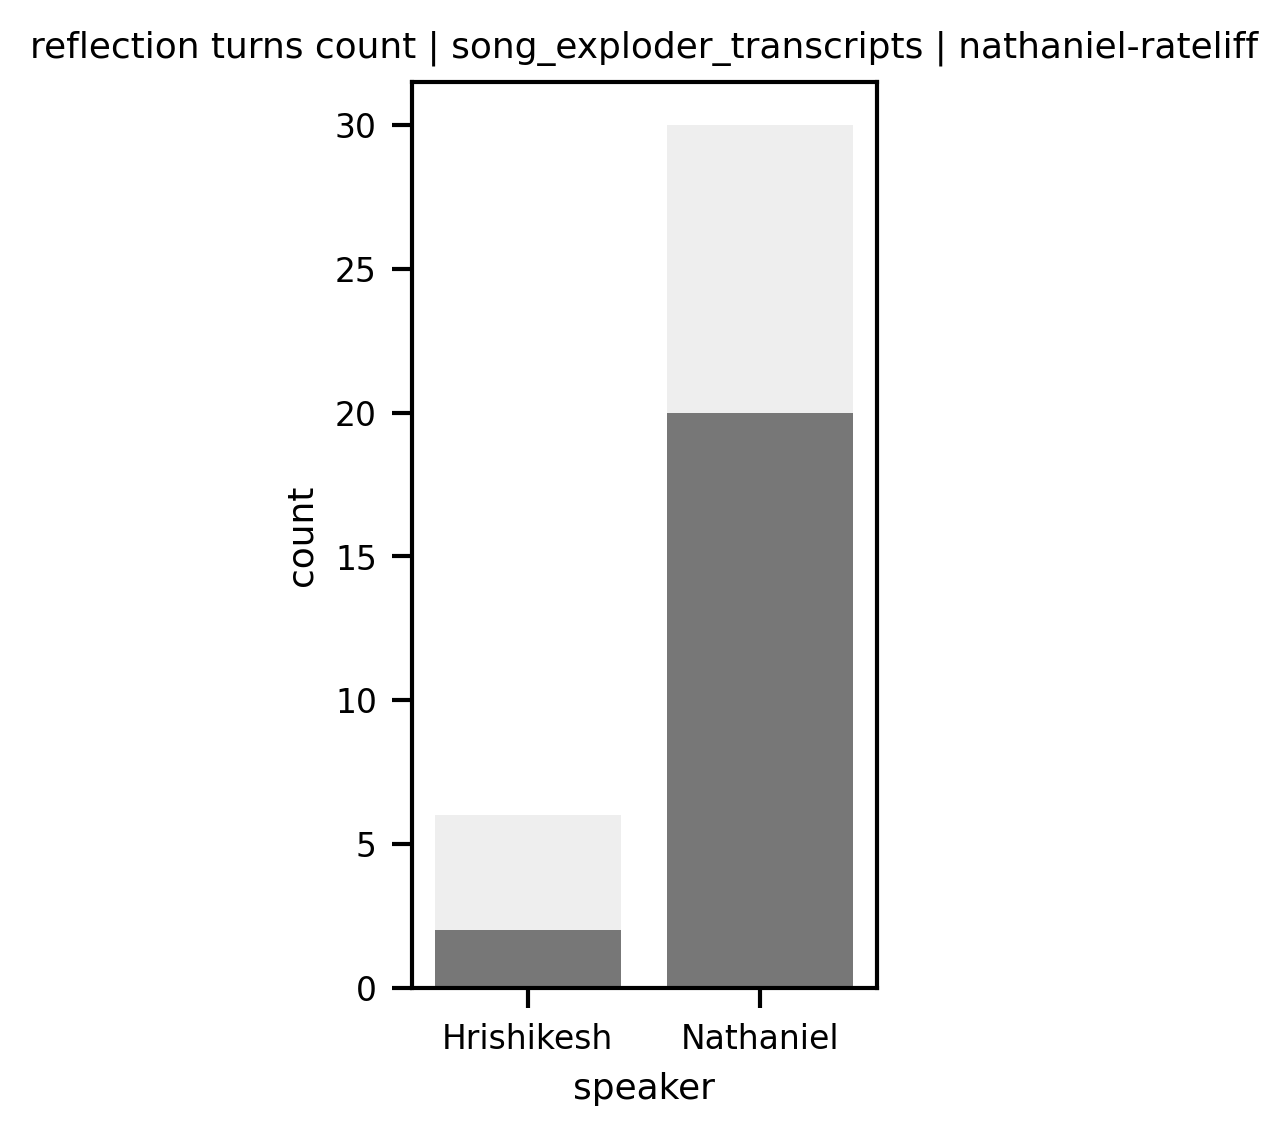

In [23]:
plot_cats_by_speaker(df, 'song_exploder_transcripts', 'reflection')

In [24]:
def plot_occurrences(input_df, dataset, session, category, range=[]):
    sns.set_style('ticks')
    sns.set_context("paper", font_scale=1.3)
    dataset_df = input_df[input_df['dataset'] == dataset]
    df_all = dataset_df[dataset_df['session'] == session]
    if len(range) == 0 :
        df = df_all.copy()
        start_turn = 0
    else :
        df = df_all[range[0]:range[1]]
        start_turn = range[0]
    category_color = '#777'
    none_color = '#eee'
    palette = [none_color, category_color]
    occurrences = []
    turns = []
    category_type = []
    category_occ = list(df[category])
    for ind, t in enumerate(category_occ) :
        if t > 0 : # category occurs in turn
            occ = 2
            kind = category
        else :
            occ = 1
            kind = 'none'
        category_type.append(kind)
        occurrences.append(occ)
        turns.append(ind + start_turn)
    df_plot = pd.DataFrame(list(zip(turns, occurrences, category_type)),
                           columns =['Turn', 'Category Index', 'Category'])
    fig = plt.figure(figsize=[20, 1], dpi=300)
    p = sns.scatterplot(data = df_plot, x = 'Turn', y = 'Category Index', hue='Category', 
                  hue_order = ['none', category], legend=False,
                  palette = palette, marker="|", s=200, lw=10)
#     plt.legend(bbox_to_anchor=(1.001, 1), loc=2)
    plt.ylim(0,3)
    plt.yticks([1,2], ['none', category])
    plt.savefig('plots/'+dataset+'-'+session+'-'+category +'-occurrence-timeline.pdf', bbox_inches='tight')
    plt.show()

/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


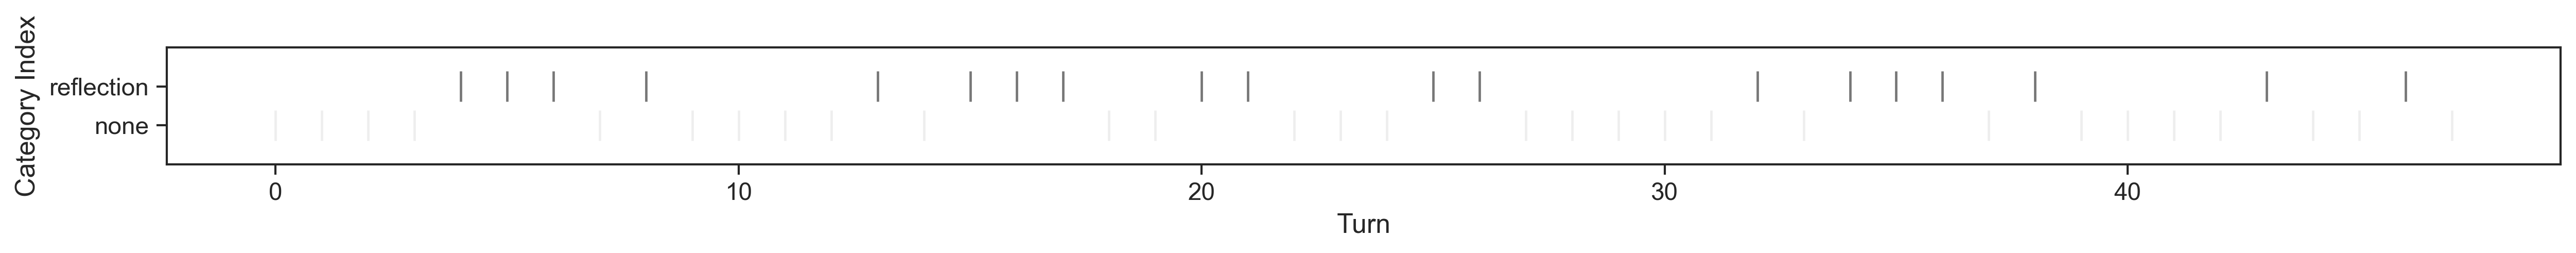

In [25]:
plot_occurrences(df, 'song_exploder_transcripts', 'the-cranberries', 'reflection')

In [ ]:
# plot_occurrences(df, 'dtrs-10', 'ugrad-5-final-review-emily', 'reflection', range=[16,20])

In [27]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['speech_turn'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')
        
def concordance(text, word, width=80, occurrences=10,nospace=False):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        
        if nospace : 
            
            if ind - margin > 0 :
                print(text[ind-margin:ind+len(word)+margin], ":", str(ind))
            else :
                spaces = ' ' * (margin - ind)
                print(spaces + text[0:ind+len(word)+margin], ":", str(ind))
            
        else :
            
            if ind - margin > 0 :
                left_text = text[ind-margin:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
            else :
                left_text = text[0:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
                
            print(left_text + "  " + mid_text + "  " + right_text, ":", str(ind))
            
        start += ind + len(word)
        counter += 1
        

def print_concordances(df, dataset, session, filter_keywords, match_limit=10, nospace=False):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['speech_turn'])
    utt_str = ' '.join(utt)
    if len(filter_keywords) > 0 :
        for term in filter_keywords :
            concordance(utt_str, term, width=80, occurrences=match_limit, nospace=nospace)
            print("-" * 80)

In [28]:
print_lines(df,  'song_exploder_transcripts', 'the-cranberries', reflection_words, 1, num_lines=5)

1 : Thao


the cranberries formed in limerick, ireland in 1989. singer dolores o’riordan joined a year later, and the group went on to become one of the deﬁning bands of the ‘90s, eventually selling over 40 million records worldwide. in january 2018, while the band was working on their eighth album, dolores o’riordan passed away unexpectedly. later that year, remaining members noel hogan, mike hogan, and fergal lawler announced that they would end the band, and that this would be their ﬁnal album. it’s called in the end. it was released in april 2019, and in this episode, guitarist and songwriter noel hogan breaks down a song from the album called “all over now.” you’ll hear how hogan and o’riordan ﬁrst started the song, and how the remaining members worked to ﬁnish it without her. also, after the full song plays, we’ve got more with noel for another installment of our segment, this is instrumental. so stick around for that. here’s the cranberries on song exploder. (“all over now” by the cranberries)

----------
2 : Noel


i'm noel hogan from the cranberries. guitarist and co-songwriter with dolores o’riordan. (music fades out)

----------
3 : Noel


we've always written separately from day one. very ﬁrst day i met dolores, gave her a cassette that had “linger” on it. (“linger” by the cranberries) (“linger” by the cranberries)

----------
4 : Noel


and she took it away, and came back a week later with the version that everybody **knows**.

----------
5 : Noel


and really from that point on, that's how we wrote. it was cassettes for years and years, **even** when we lived in diﬀerent countries. i would courier cassettes over to her and she'd work on them. and it was a kind of a mutual respect in that way, writing-wise that you kind of **knew** what the other one was **thinking** without having to say it. (music fades out)

----------


In [29]:
# lexicon.analyze("I guess I did something wrong", categories=["reflection"], normalize=True)
# # => {'violence': 0.2}


## Analysis via Topic Modeling

In [58]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import gensim
from gensim import corpora, models, utils
from gensim.models import word2vec
from gensim.models import Phrases
from sklearn.manifold import MDS

import matplotlib

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import pprint
import numpy as np
import pyLDAvis.gensim_models
from collections import Counter
pp = pprint.PrettyPrinter(indent=4, width=300)

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import json

# feed the LDA model into the pyLDAvis instance

/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
df[0:5]

/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dataset session     speaker  \
0  song_exploder_transcripts    haim  Hrishikesh   
1  song_exploder_transcripts    haim  Hrishikesh   
2  song_exploder_transcripts    haim    Danielle   
3  song_exploder_transcripts    haim       Ariel   
4  song_exploder_transcripts    haim    Danielle   

                                         speech_turn  reflection  word count  
0  You’re listening to Song Exploder, where music...           0          32  
1  This episode contains explicit language. HAIM ...           1         109  
2                          My name is Danielle Haim.           0           5  
3     My name is Ariel Rechtshaid. (Music fades out)           0           8  
4  I’ll never forget, I had heard a Cass McCombs ...           3         102

In [97]:
bigram = Phrases()
sentences = []
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()
puncts = [ '"', "'", '/', '-', '&', '”', '“']

spoken_stop_words = [
    'ah',
    'em',
    'hm',
    'hmm',
    'like',
    'um',
    'wa',
    'yeah'    
]

complete_stop_words = stopwords.words("english") + spoken_stop_words + puncts

speech_turns = list(df['speech_turn'])

for ind, line in enumerate(speech_turns):
    rawline = line.lower()
    rawline = ''.join([c for c in list(rawline) if c not in string.punctuation])
    tokens = [w for w in tokenizer.tokenize(rawline)]
    lemmas = [lem.lemmatize(token) for token in tokens]
    sentences.append(lemmas)
    bigram.add_vocab([lemmas])
    
uni_bi_gram_tokens = list(bigram[sentences])

print("Uni- and bigram tokens from the first 2 lines:")
print("---------------------------")
for t in uni_bi_gram_tokens[:2]:
    print(t)



/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Uni- and bigram tokens from the first 2 lines:
---------------------------
['you', '’_re', 'listening', 'to', 'song_exploder', 'where_musician', 'take_apart', 'their_song', 'and', 'piece_by', 'piece_tell', 'the', 'story', 'of', 'how_they', 'were_made', 'my_name', 'is_hrishikesh', 'hirway', '“', 'summer_girl', '”_by', 'haim']
['this_episode', 'contains_explicit', 'language', 'haim', 'is', 'a', 'band', 'from', 'los_angeles', 'made', 'up', 'of', 'the', 'sister', 'danielle', 'este', 'and', 'alana', 'haim', 'they', '’_ve', 'released', 'three', 'album', 'and', 'they', '’_ve', 'been_nominated', 'for', 'three', 'grammys', 'over', 'the', 'year', 'they', '’_ve', 'worked', 'extensively', 'with', 'grammywinning', 'producer', 'ariel_rechtshaid', 'he', 'and', 'danielle', 'are', 'also', 'a', 'couple', 'and', 'i', 'only', 'mention', 'that', 'because', 'it', '’_s', 'relevant', 'to', 'the', 'story', 'you', '’_re', 'about', 'to', 'hear', 'i', 'spoke', 'to', 'danielle', 'and', 'ariel', 'about', 'the', 'ma

### Optional: Identify common n-grams in the corpus


In [98]:
# bigram_counter = Counter()
keys_list = [ x for x in bigram.vocab.keys()]
keylist = []
ngram_tokens = []

for x in bigram.vocab.keys():
    if type(x) == bytes :
        keylist.append(x.decode('UTF-8'))
    else :
        keylist.append(x)
        
# print(keylist)



for ind, key in enumerate(keylist):
    if len(key.split("_")) > 1 :
        # the key is a bigram
        subkey_is_stopword = False
        for subkey in key.split("_") :
            # if either of the words constituting the bigram is a stop word, remove the bigram
            if subkey in complete_stop_words :
                subkey_is_stopword = True
        if not subkey_is_stopword :
            ngram_tokens.append(key)
    else :
        # the key is a unigram
        if not key in complete_stop_words :
            ngram_tokens.append(key)
                
print("Number of uni- and bi-grams found: ", len(ngram_tokens))

# Remove non-occurring bigrams from ngram_tokens
all_tokens = []
for sentence_tokens in uni_bi_gram_tokens:
    all_tokens.extend(sentence_tokens)
    for t in sentence_tokens :
        if t == 'landscape_architect' :
            print(sentence_tokens)
    
print(len(all_tokens), "tokens from", len(uni_bi_gram_tokens), "sentences.")
all_unique_tokens = list(set(all_tokens))
print(len(all_unique_tokens), "unique tokens from", len(uni_bi_gram_tokens), "sentences.")

pruned_ngram_tokens = []
for ngram in ngram_tokens :
    if ngram in all_unique_tokens :
        pruned_ngram_tokens.append(ngram)

print(len(pruned_ngram_tokens), "final uni- and bi-grams found in corpus.")

lem = WordNetLemmatizer()
final_tokens_by_line = []
line_tokens_list = []
lines_to_remove = []
for ind, tokenized_sentence in enumerate(uni_bi_gram_tokens) :
    for token in tokenized_sentence :
        if token == 'landscape_architect' or token == 'landscape_architects':
            print(ind, token)
    stopped_tokens = [w for w in tokenized_sentence if w in pruned_ngram_tokens]
    if len(stopped_tokens) > 0 :
        line_tokens_list.append(stopped_tokens)
    else :
        lines_to_remove.append(speech_turns[ind])
        

if len(lines_to_remove) > 0:
    for del_line in lines_to_remove:
        speech_turns.remove(del_line)

unique_tokens = pruned_ngram_tokens

/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of uni- and bi-grams found:  23759
148911 tokens from 2297 sentences.
7867 unique tokens from 2297 sentences.
7454 final uni- and bi-grams found in corpus.


In [101]:
dictionary = corpora.Dictionary(line_tokens_list)
corpus = [dictionary.doc2bow(line) for line in line_tokens_list]
topic_count = 7
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=topic_count, id2word=dictionary, passes=200)

/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
gensimvis.prepare(ldamodel, corpus, dictionary, mds='tsne')

/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/schandrasegara/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2     -29.594002  60.112713       1        1  47.879349
0     -45.996586  11.891685       2        1  11.026190
5      20.368856  70.019325       3        1  10.680928
4      53.928768  31.704309       4        1  10.246619
1     -12.437127 -26.423267       5        1   8.485814
6       3.965971  21.797720       6        1   6.156196
3      37.524284 -16.517805       7        1   5.524904, topic_info=              Term        Freq       Total Category  logprob  loglift
4    song_exploder  231.000000  231.000000  Default  30.0000  30.0000
176           drum  280.000000  280.000000  Default  29.0000  29.0000
37            song  953.000000  953.000000  Default  28.0000  28.0000
697          piano  186.000000  186.000000  Default  27.0000  27.0000
740         string  131.000000  131.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
108            see   21.910508   93.035964   Topic7  -5.0381   1.4499
125            get   25.232754  396.551043   Topic7  -4.8969   0.1412
412           next   17.271783   58.290961   Topic7  -5.2759   1.6795
43            year   17.579382  116.918971   Topic7  -5.2583   1.0011
9            album   16.831300  192.441257   Topic7  -5.3018   0.4594

[482 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3428      5  0.930232        18
2610      4  0.891203      1995
1278      3  0.903139      2003
3096      4  0.960687      2010
145       4  0.944861      2018
...     ...       ...       ...
6292      6  0.966320  ﬁnishing
195       1  0.546290      ﬁrst
195       2  0.090213      ﬁrst
195       4  0.315746      ﬁrst
195       6  0.045107      ﬁrst

[853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 5, 2, 7, 4])